# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


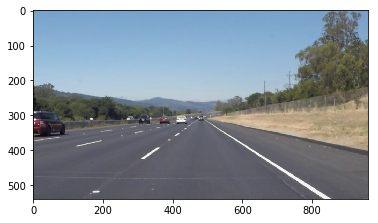

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [43]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def mean(list):
    """
    Calculating mean
    """
    return float(sum(list)) / max(len(list), 1)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Calculating slope and constants
    constantLeftLane = [] 
    constantRightLane = []
    positiveSlope = []
    negativeSlope = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # Calculating values for slope and intercept
            slope = ( ( y2 - y1 ) / ( x2 - x1 ) )
            intercept =  (y1 - (x1 * slope) )
            
            # Checking for unwanted values
            if slope >= 0 and (slope < 0.2 or slope > 4):
                continue
            elif slope < 0 and (slope < -2 or slope > -0.2):
                continue
                
            # Splitting left and right lanes
            if slope > 0:
                positiveSlope.append(slope)
                constantLeftLane.append(intercept)
            else:
                negativeSlope.append(slope)
                constantRightLane.append(intercept)
    
    # Defining the window
    imshape = img.shape
    y_max   = imshape[0]
    y_min   = 330

    # Get the mean of all the lines values
    leftLaneSlope = mean(positiveSlope)
    rightLaneSlope = mean(negativeSlope)
    leftLaneIntercept = mean(constantLeftLane)
    rightLaneIntercept = mean(constantRightLane)

    # Plotting lines by making use of calculated slopes
    if leftLaneSlope != 0:
        x1_LeftLane = (y_max - leftLaneIntercept)/leftLaneSlope
        y1_LeftLane = y_max
        x2_LeftLane = (y_min - leftLaneIntercept)/leftLaneSlope
        y2_LeftLane = y_min
    if rightLaneSlope != 0:
        x1_RightLane = (y_max - rightLaneIntercept)/rightLaneSlope
        y1_RightLane = y_max
        x2_RightLane = (y_min - rightLaneIntercept)/rightLaneSlope
        y2_RightLane = y_min

        # Averaged Lines for left and right lanes
        cv2.line(img, (int(x1_LeftLane), int(y1_LeftLane)), (int(x2_LeftLane), int(y2_LeftLane)), color, thickness) #avg Left Line
        cv2.line(img, (int(x1_RightLane), int(y1_RightLane)), (int(x2_RightLane), int(y2_RightLane)), color, thickness) #avg Right Line
           
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 '.ipynb_checkpoints',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

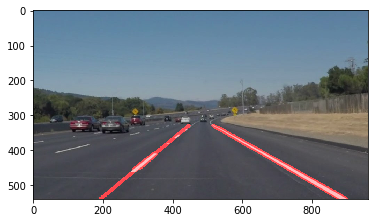

In [61]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Reading the image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
color_bound_img = np.copy(image)

# Step 1 : Color Selection
# Filter white pixels
white_threshold = 200 #130
lower_white = np.array([white_threshold, white_threshold, white_threshold])
upper_white = np.array([255, 255, 255])
white_mask = cv2.inRange(image, lower_white, upper_white)
white_image = cv2.bitwise_and(image, image, mask=white_mask)

# Filter yellow pixels
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([90,100,100])
upper_yellow = np.array([110,255,255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

# Combining the images
white_yellow_img = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

# Step 2 : Grayscaling
greyed_img = grayscale(white_yellow_img)


# Step 3 : Gaussian Transform
blurred_img = gaussian_blur(greyed_img, 5)


# Step 4 : Canny Transform (1:3)
low_threshold = 50
high_threshold = 150
gradient_img = canny(blurred_img, low_threshold, high_threshold)

# Step 5 : Region Selection
imgShape = image.shape
polygon = np.array([ [(50, imgShape[0]), (460, 310), (490, 310), (imgShape[1]-50, imgShape[0]) ] ], dtype=np.int32)
# Checking the selection
#x = [50, 460, 490, imgShape[1]-50]
#y = [imgShape[0], 310, 310, imgShape[0]]
#plt.plot(x, y, 'b--', lw=4)
color_bound_img = region_of_interest(gradient_img, polygon)

# Step 6 : Hough Transform(gradient_img, rho, theta, threshold, min_line_len, max_line_gap)
rho = 1
theta = np.pi/180
threshold = 20
min_line_len = 18
max_line_gap = 1

houghed_lines = cv2.HoughLinesP(color_bound_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
line_image = np.copy(image) * 0
draw_lines(line_image, houghed_lines, [255, 0, 0], 10)

# Step 7 : Adding Weights
weight_img = weighted_img(line_image, image)

# Displaying the image
plt.imshow(weight_img)

#cv2.imwrite('test_images_output/Step5_color_bound_img.jpg', color_bound_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [38]:
def process_image(image):
    
    color_bound_img = np.copy(image)

    # Step 2 : Color Selection
    # Filter white pixels
    white_threshold = 200 #130
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    white_yellow_img = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    # Step 1 : Grayscaling
    greyed_img = grayscale(white_yellow_img)


    # Step 2 : Gaussian Transform
    blurred_img = gaussian_blur(greyed_img, 5)


    # Step 3 : Canny Transform (1:3)
    low_threshold = 50
    high_threshold = 150
    gradient_img = canny(blurred_img, low_threshold, high_threshold)

    # Step 2 : Region Selection
    imgShape = image.shape
    polygon = np.array([ [(50, imgShape[0]), (460, 310), (490, 310), (imgShape[1]-50, imgShape[0]) ] ], dtype=np.int32)
    color_bound_img = region_of_interest(gradient_img, polygon)

    # Step 6 : Hough Transform(gradient_img, rho, theta, threshold, min_line_len, max_line_gap)
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 18
    max_line_gap = 1

    houghed_lines = cv2.HoughLinesP(color_bound_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    line_image = np.copy(image) * 0
    draw_lines(line_image, houghed_lines, [255, 0, 0], 10)

    # Step 7 : Adding Weights
    weight_img = weighted_img(line_image, image)

    return weight_img

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

 +ve slope:  [0.59782608695652173]
 +ve slope:  [0.59782608695652173, 0.62804878048780488]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605]
 -ve slope:  [-0.7021276595744681]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857143]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667, 0.609375]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857143, -0.77272727272727271]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667, 0.609375, 0.61764705882352944]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857


  1%|▏         | 3/222 [00:00<00:09, 23.04it/s]

 +ve slope:  [0.59782608695652173]
 +ve slope:  [0.59782608695652173, 0.62804878048780488]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605]
 -ve slope:  [-0.7021276595744681]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857143]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667, 0.609375]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857143, -0.77272727272727271]
 +ve slope:  [0.59782608695652173, 0.62804878048780488, 0.62790697674418605, 0.61627906976744184, 0.6166666666666667, 0.609375, 0.61764705882352944]
 -ve slope:  [-0.7021276595744681, -0.7570093457943925, -0.7142857142857

 +ve slope:  [0.60402684563758391]
 +ve slope:  [0.60402684563758391, 0.61702127659574468]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867, 0.64406779661016944]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867, 0.64406779661016944, 0.59872611464968151]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867, 0.64406779661016944, 0.59872611464968151, 0.620253164556962]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867, 0.64406779661016944, 0.59872611464968151, 0.620253164556962, 0.63636363636363635]
 +ve slope:  [0.60402684563758391, 0.61702127659574468, 0.62222222222222223, 0.63793103448275867, 0.64406779661016944, 0.598726114649681


  4%|▍         | 9/222 [00:00<00:08, 24.17it/s]

 +ve slope:  [0.64462809917355368]
 +ve slope:  [0.64462809917355368, 0.60377358490566035]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692, 0.64197530864197527]
 -ve slope:  [-0.70370370370370372]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692, 0.64197530864197527, 0.65000000000000002]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692, 0.64197530864197527, 0.65000000000000002, 0.60869565217391308]
 -ve slope:  [-0.70370370370370372, -0.71999999999999997]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692, 0.64197530864197527, 0.65000000000000002, 0.60869565217391308, 0.61904761904761907]
 +ve slope:  [0.64462809917355368, 0.60377358490566035, 0.60240963855421692, 0.64197530864197527, 0.65000000000000002, 0.60869565217391308, 0.61904761904761907, 0.61111111111111116]
 +ve slope:  [0.64462809917355368, 0.6


  7%|▋         | 15/222 [00:00<00:08, 24.50it/s]

 +ve slope:  [0.65000000000000002]
 +ve slope:  [0.65000000000000002, 0.62264150943396224]
 -ve slope:  [-0.70370370370370372]
 +ve slope:  [0.65000000000000002, 0.62264150943396224, 0.62222222222222223]
 +ve slope:  [0.65000000000000002, 0.62264150943396224, 0.62222222222222223, 0.63888888888888884]
 -ve slope:  [-0.70370370370370372, -0.75]
 +ve slope:  [0.65000000000000002, 0.62264150943396224, 0.62222222222222223, 0.63888888888888884, 0.61538461538461542]
 -ve slope:  [-0.70370370370370372, -0.75, -0.69047619047619047]
 -ve slope:  [-0.70370370370370372, -0.75, -0.69047619047619047, -0.74468085106382975]
 +ve slope:  [0.65000000000000002, 0.62264150943396224, 0.62222222222222223, 0.63888888888888884, 0.61538461538461542, 0.62857142857142856]
 +ve slope:  [0.65000000000000002, 0.62264150943396224, 0.62222222222222223, 0.63888888888888884, 0.61538461538461542, 0.62857142857142856, 0.63157894736842102]
 -ve slope:  [-0.70370370370370372, -0.75, -0.69047619047619047, -0.744680851063829


  8%|▊         | 18/222 [00:00<00:08, 24.25it/s]

 +ve slope:  [0.62406015037593987]
 +ve slope:  [0.62406015037593987, 0.647887323943662]
 +ve slope:  [0.62406015037593987, 0.647887323943662, 0.65517241379310343]
 +ve slope:  [0.62406015037593987, 0.647887323943662, 0.65517241379310343, 0.65346534653465349]
 +ve slope:  [0.62406015037593987, 0.647887323943662, 0.65517241379310343, 0.65346534653465349, 0.6257309941520468]
 +ve slope:  [0.62406015037593987, 0.647887323943662, 0.65517241379310343, 0.65346534653465349, 0.6257309941520468, 0.65476190476190477]
 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.70833333333333337]
 +ve slope:  [0.62406015037593987, 0.647887323943662, 0.65517241379310343, 0.65346534653465349, 0.6257309941520468, 0.65476190476190477, 0.62337662337662336]
0.6406363938482762
-0.7178030303030303
 +ve slope:  [0.62403100775193798]
 +ve slope:  [0.62403100775193798, 0.671875]
 +ve slope:  [0.62403100775193798, 0.671875, 0.65625]
 +ve slope:  [0.62403100775193798, 0.671875, 0.65625, 0.692307


  9%|▉         | 21/222 [00:00<00:08, 23.98it/s]

 +ve slope:  [0.62650602409638556]
 +ve slope:  [0.62650602409638556, 0.65161290322580645]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595, 0.60655737704918034]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595, 0.60655737704918034, 0.65853658536585369]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595, 0.60655737704918034, 0.65853658536585369, 0.609375]
 -ve slope:  [-0.67391304347826086]
 -ve slope:  [-0.67391304347826086, -0.73170731707317072]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595, 0.60655737704918034, 0.65853658536585369, 0.609375, 0.6785714285714286]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.64893617021276595, 0.60655737704918034, 0.65853658536585369, 0.609375, 0.6785714285714286, 0.63636363636363635]
 +ve slope:  [0.62650602409638556, 0.65161290322580645, 0.648936170212765


 11%|█         | 24/222 [00:00<00:08, 23.98it/s]

 +ve slope:  [0.62]
 +ve slope:  [0.62, 0.63636363636363635]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926, 0.640625]
 -ve slope:  [-0.73076923076923073]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926, 0.640625, 0.6705882352941176]
 -ve slope:  [-0.73076923076923073, -0.68000000000000005]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926, 0.640625, 0.6705882352941176, 0.67272727272727273]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926, 0.640625, 0.6705882352941176, 0.67272727272727273, 0.64197530864197527]
 +ve slope:  [0.62, 0.63636363636363635, 0.66666666666666663, 0.66990291262135926, 0.640625, 0.6705882352941176, 0.67272727272727273, 0.64197530864197527, 0.67441860465116277]
 +ve slope:  [0.62, 0.6363636

 +ve slope:  [0.6258278145695364]
 +ve slope:  [0.6258278145695364, 0.65346534653465349]
 -ve slope:  [-0.73333333333333328]
 +ve slope:  [0.6258278145695364, 0.65346534653465349, 0.65116279069767447]
 +ve slope:  [0.6258278145695364, 0.65346534653465349, 0.65116279069767447, 0.6506024096385542]
 -ve slope:  [-0.73333333333333328, -0.69736842105263153]
 -ve slope:  [-0.73333333333333328, -0.69736842105263153, -0.73809523809523814]
 +ve slope:  [0.6258278145695364, 0.65346534653465349, 0.65116279069767447, 0.6506024096385542, 0.62105263157894741]
 +ve slope:  [0.6258278145695364, 0.65346534653465349, 0.65116279069767447, 0.6506024096385542, 0.62105263157894741, 0.62068965517241381]
 -ve slope:  [-0.73333333333333328, -0.69736842105263153, -0.73809523809523814, -0.67924528301886788]
 -ve slope:  [-0.73333333333333328, -0.69736842105263153, -0.73809523809523814, -0.67924528301886788, -0.72222222222222221]
 -ve slope:  [-0.73333333333333328, -0.69736842105263153, -0.73809523809523814, -0.6


 14%|█▎        | 30/222 [00:01<00:08, 23.83it/s]

 +ve slope:  [0.625]
 +ve slope:  [0.625, 0.65322580645161288]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663]
 -ve slope:  [-0.75]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663, 0.66000000000000003]
 -ve slope:  [-0.75, -0.6785714285714286]
 -ve slope:  [-0.75, -0.6785714285714286, -0.67567567567567566]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663, 0.66000000000000003, 0.61764705882352944]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663, 0.66000000000000003, 0.61764705882352944, 0.61538461538461542]
 -ve slope:  [-0.75, -0.6785714285714286, -0.67567567567567566, -0.73913043478260865]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663, 0.66000000000000003, 0.61764705882352944, 0.61538461538461542, 0.6333333333333333]
 -ve slope:  [-0.75, -0.6785714285714286, -0.67567567567567566, -0.73913043478260865, -0.69444444444444442]
 +ve slope:  [0.625, 0.65322580645161288, 0.66666666666666663, 0.66000000000000003, 0.617647


 15%|█▍        | 33/222 [00:01<00:07, 23.89it/s]

 +ve slope:  [0.63636363636363635]
 +ve slope:  [0.63636363636363635, 0.6508474576271186]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162, 0.60396039603960394]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162, 0.60396039603960394, 0.60655737704918034]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162, 0.60396039603960394, 0.60655737704918034, 0.64893617021276595]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162, 0.60396039603960394, 0.60655737704918034, 0.64893617021276595, 0.6428571428571429]
 -ve slope:  [-0.70270270270270274]
 -ve slope:  [-0.70270270270270274, -0.72727272727272729]
 +ve slope:  [0.63636363636363635, 0.6508474576271186, 0.61290322580645162, 0.60396039603960394, 0.60655737704918034, 0.64893617021276595, 0.6428571428571429, 0.63793103448275867]
 +ve slope:  [0.63636363636363635, 0.6508474576


 16%|█▌        | 36/222 [00:01<00:07, 24.05it/s]

 +ve slope:  [0.62142857142857144]
 +ve slope:  [0.62142857142857144, 0.65200000000000002]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144]
 -ve slope:  [-0.68518518518518523]
 -ve slope:  [-0.68518518518518523, -0.75]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144, 0.6470588235294118]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144, 0.6470588235294118, 0.65346534653465349]
 -ve slope:  [-0.68518518518518523, -0.75, -0.67647058823529416]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144, 0.6470588235294118, 0.65346534653465349, 0.61764705882352944]
 -ve slope:  [-0.68518518518518523, -0.75, -0.67647058823529416, -0.78260869565217395]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144, 0.6470588235294118, 0.65346534653465349, 0.61764705882352944, 0.6071428571428571]
 +ve slope:  [0.62142857142857144, 0.65200000000000002, 0.62318840579710144, 0.647058823


 18%|█▊        | 39/222 [00:01<00:07, 23.87it/s]

 +ve slope:  [0.6470588235294118]
 +ve slope:  [0.6470588235294118, 0.61864406779661019]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868, 0.66911764705882348]
 -ve slope:  [-0.74647887323943662]
 -ve slope:  [-0.74647887323943662, -0.69306930693069302]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868, 0.66911764705882348, 0.63235294117647056]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868, 0.66911764705882348, 0.63235294117647056, 0.63829787234042556]
 -ve slope:  [-0.74647887323943662, -0.69306930693069302, -0.74509803921568629]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868, 0.66911764705882348, 0.63235294117647056, 0.63829787234042556, 0.68181818181818177]
 +ve slope:  [0.6470588235294118, 0.61864406779661019, 0.64864864864864868, 0.66911764705882348, 0.63235294117647056, 0.63829787234042556, 0.681818

 +ve slope:  [0.62608695652173918]
 +ve slope:  [0.62608695652173918, 0.67222222222222228]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004, 0.64772727272727271]
 -ve slope:  [-0.72727272727272729]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004, 0.64772727272727271, 0.6333333333333333]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004, 0.64772727272727271, 0.6333333333333333, 0.6333333333333333]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004, 0.64772727272727271, 0.6333333333333333, 0.6333333333333333, 0.5714285714285714]
 +ve slope:  [0.62608695652173918, 0.67222222222222228, 0.62745098039215685, 0.67200000000000004, 0.64


 19%|█▉        | 42/222 [00:01<00:07, 23.65it/s]

 +ve slope:  [0.6271186440677966]
 +ve slope:  [0.6271186440677966, 0.671875]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034, 0.67741935483870963]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034, 0.67741935483870963, 0.67142857142857137]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034, 0.67741935483870963, 0.67142857142857137, 0.63043478260869568]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034, 0.67741935483870963, 0.67142857142857137, 0.63043478260869568, 0.65909090909090906]
 -ve slope:  [-0.71999999999999997]
 +ve slope:  [0.6271186440677966, 0.671875, 0.63043478260869568, 0.60655737704918034, 0.67741935483870963, 0.67142857142857137, 0.63043478260869568, 0.65909090909090906, 0.699999999


 20%|██        | 45/222 [00:02<00:11, 14.98it/s]

 +ve slope:  [0.62857142857142856]
 +ve slope:  [0.62857142857142856, 0.64534883720930236]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081, 0.65384615384615385]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081, 0.65384615384615385, 0.65263157894736845]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081, 0.65384615384615385, 0.65263157894736845, 0.6404494382022472]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081, 0.65384615384615385, 0.65263157894736845, 0.6404494382022472, 0.640625]
 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.78787878787878785]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079365079365081, 0.65384615384615385, 0.65263157894736845, 0.6404494382022472, 0.640625, 0.65573770491803274]
 +ve slope:  [0.62857142857142856, 0.64534883720930236, 0.65079


 22%|██▏       | 49/222 [00:02<00:13, 13.14it/s]

 +ve slope:  [0.67256637168141598]
 +ve slope:  [0.67256637168141598, 0.625]
 -ve slope:  [-0.70370370370370372]
 -ve slope:  [-0.70370370370370372, -0.75409836065573765]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663]
 -ve slope:  [-0.70370370370370372, -0.75409836065573765, -0.703125]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663, 0.67073170731707321]
 -ve slope:  [-0.70370370370370372, -0.75409836065573765, -0.703125, -0.75]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663, 0.67073170731707321, 0.61290322580645162]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663, 0.67073170731707321, 0.61290322580645162, 0.67251461988304095]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663, 0.67073170731707321, 0.61290322580645162, 0.67251461988304095, 0.62962962962962965]
 +ve slope:  [0.67256637168141598, 0.625, 0.66666666666666663, 0.67073170731707321, 0.61290322580645162, 0.67251461988304095, 0.62962962962962965, 0.6111111111


 23%|██▎       | 51/222 [00:02<00:13, 12.58it/s]

 +ve slope:  [0.67307692307692313]
 +ve slope:  [0.67307692307692313, 0.62686567164179108]
 -ve slope:  [-0.70229007633587781]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714, 0.62820512820512819]
 -ve slope:  [-0.70229007633587781, -0.75]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714, 0.62820512820512819, 0.69444444444444442]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714, 0.62820512820512819, 0.69444444444444442, 0.61111111111111116]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714, 0.62820512820512819, 0.69444444444444442, 0.61111111111111116, 0.60810810810810811]
 -ve slope:  [-0.70229007633587781, -0.75, -0.76666666666666672]
 +ve slope:  [0.67307692307692313, 0.62686567164179108, 0.6964285714285714, 0.62820512820512819, 0.69444444444444442, 0.61111111111111116, 0.60810810810810811, 0.6190476190476


 25%|██▍       | 55/222 [00:02<00:14, 11.76it/s]

 +ve slope:  [0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878, 0.65591397849462363]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878, 0.65591397849462363, 0.62686567164179108]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878, 0.65591397849462363, 0.62686567164179108, 0.65573770491803274]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878, 0.65591397849462363, 0.62686567164179108, 0.65573770491803274, 0.5714285714285714]
 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.66666666666666663, 0.62878787878787878, 0.65591397849462363, 0.62686567164179108, 0.65573770491803274, 0


 26%|██▌       | 57/222 [00:03<00:14, 11.24it/s]

 +ve slope:  [0.62612612612612617]
 +ve slope:  [0.62612612612612617, 0.671875]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714, 0.62903225806451613]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714, 0.62903225806451613, 0.61904761904761907]
 -ve slope:  [-0.68000000000000005]
 -ve slope:  [-0.68000000000000005, -0.68571428571428572]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714, 0.62903225806451613, 0.61904761904761907, 0.69387755102040816]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714, 0.62903225806451613, 0.61904761904761907, 0.69387755102040816, 0.7142857142857143]
 +ve slope:  [0.62612612612612617, 0.671875, 0.65714285714285714, 0.62903225806451613, 0.61904761904761907, 0.69387755102040816, 0.7142857142857143, 0.6333333333333333]
 -ve slope:  [-0.68000000000000005, -0.68571428571428572, -0.61111111111111116]
 +ve slope:  [0.62612612612612617, 0.6


 27%|██▋       | 59/222 [00:03<00:14, 11.12it/s]

[0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585369, 0.6785714285714286, 0.68965517241379315, 0.65789473684210531]
 +ve slope:  [0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585369, 0.6785714285714286, 0.68965517241379315, 0.65789473684210531, 0.66666666666666663]
 +ve slope:  [0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585369, 0.6785714285714286, 0.68965517241379315, 0.65789473684210531, 0.66666666666666663, 0.62295081967213117]
 +ve slope:  [0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585369, 0.6785714285714286, 0.68965517241379315, 0.65789473684210531, 0.66666666666666663, 0.62295081967213117, 0.63157894736842102]
 +ve slope:  [0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585369, 0.6785714285714286, 0.68965517241379315, 0.65789473684210531, 0.66666666666666663, 0.62295081967213117, 0.63157894736842102, 0.60869565217391308]
 +ve slope:  [0.62, 0.67251461988304095, 0.64462809917355368, 0.65853658536585


 27%|██▋       | 61/222 [00:03<00:14, 11.11it/s]

 +ve slope:  [0.67399267399267404]
 +ve slope:  [0.67399267399267404, 0.64571428571428569]
 -ve slope:  [-0.6987951807228916]
 -ve slope:  [-0.6987951807228916, -0.67500000000000004]
 -ve slope:  [-0.6987951807228916, -0.67500000000000004, -0.68000000000000005]
 -ve slope:  [-0.6987951807228916, -0.67500000000000004, -0.68000000000000005, -0.70370370370370372]
 +ve slope:  [0.67399267399267404, 0.64571428571428569, 0.6470588235294118]
 +ve slope:  [0.67399267399267404, 0.64571428571428569, 0.6470588235294118, 0.64583333333333337]
 +ve slope:  [0.67399267399267404, 0.64571428571428569, 0.6470588235294118, 0.64583333333333337, 0.64864864864864868]
 -ve slope:  [-0.6987951807228916, -0.67500000000000004, -0.68000000000000005, -0.70370370370370372, -0.66666666666666663]
 +ve slope:  [0.67399267399267404, 0.64571428571428569, 0.6470588235294118, 0.64583333333333337, 0.64864864864864868, 0.69230769230769229]
 -ve slope:  [-0.6987951807228916, -0.67500000000000004, -0.68000000000000005, -0.70


 29%|██▉       | 65/222 [00:03<00:13, 11.36it/s]

 +ve slope:  [0.67295597484276726]
 +ve slope:  [0.67295597484276726, 0.65384615384615385]
 +ve slope:  [0.67295597484276726, 0.65384615384615385, 0.640625]
 +ve slope:  [0.67295597484276726, 0.65384615384615385, 0.640625, 0.64550264550264547]
 +ve slope:  [0.67295597484276726, 0.65384615384615385, 0.640625, 0.64550264550264547, 0.64423076923076927]
 -ve slope:  [-0.67307692307692313]
 -ve slope:  [-0.67307692307692313, -0.69999999999999996]
 -ve slope:  [-0.67307692307692313, -0.69999999999999996, -0.72093023255813948]
 -ve slope:  [-0.67307692307692313, -0.69999999999999996, -0.72093023255813948, -0.66666666666666663]
 -ve slope:  [-0.67307692307692313, -0.69999999999999996, -0.72093023255813948, -0.66666666666666663, -0.72727272727272729]
 +ve slope:  [0.67295597484276726, 0.65384615384615385, 0.640625, 0.64550264550264547, 0.64423076923076927, 0.6470588235294118]
 +ve slope:  [0.67295597484276726, 0.65384615384615385, 0.640625, 0.64550264550264547, 0.64423076923076927, 0.6470588235


 30%|███       | 67/222 [00:04<00:13, 11.58it/s]

 +ve slope:  [0.67567567567567566]
 +ve slope:  [0.67567567567567566, 0.65217391304347827]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174, 0.62790697674418605]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174, 0.62790697674418605, 0.67500000000000004]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174, 0.62790697674418605, 0.67500000000000004, 0.66666666666666663]
 -ve slope:  [-0.65625]
 -ve slope:  [-0.65625, -0.65517241379310343]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174, 0.62790697674418605, 0.67500000000000004, 0.66666666666666663, 0.66666666666666663]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.62676056338028174, 0.62790697674418605, 0.67500000000000004, 0.66666666666666663, 0.66666666666666663, 0.68181818181818177]
 +ve slope:  [0.67567567567567566, 0.65217391304347827, 0.6267


 32%|███▏      | 71/222 [00:04<00:12, 11.81it/s]

 +ve slope:  [0.67326732673267331]
 +ve slope:  [0.67326732673267331, 0.64651162790697669]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358]
 -ve slope:  [-0.64150943396226412]
 -ve slope:  [-0.64150943396226412, -0.70588235294117652]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.65555555555555556]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.65555555555555556, 0.65625]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.65555555555555556, 0.65625, 0.68181818181818177]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.65555555555555556, 0.65625, 0.68181818181818177, 0.63636363636363635]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.65555555555555556, 0.65625, 0.68181818181818177, 0.63636363636363635, 0.66666666666666663]
 +ve slope:  [0.67326732673267331, 0.64651162790697669, 0.64356435643564358, 0.6555555


 33%|███▎      | 73/222 [00:04<00:13, 11.39it/s]

 +ve slope:  [0.67521367521367526]
 +ve slope:  [0.67521367521367526, 0.65000000000000002]
 -ve slope:  [-0.69902912621359226]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942528735632188]
 -ve slope:  [-0.69902912621359226, -0.64516129032258063]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942528735632188, 0.67567567567567566]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942528735632188, 0.67567567567567566, 0.65384615384615385]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942528735632188, 0.67567567567567566, 0.65384615384615385, 0.67682926829268297]
 -ve slope:  [-0.69902912621359226, -0.64516129032258063, -0.65625]
 -ve slope:  [-0.69902912621359226, -0.64516129032258063, -0.65625, -0.69999999999999996]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942528735632188, 0.67567567567567566, 0.65384615384615385, 0.67682926829268297, 0.6785714285714286]
 +ve slope:  [0.67521367521367526, 0.65000000000000002, 0.64942


 35%|███▍      | 77/222 [00:04<00:12, 11.55it/s]

 +ve slope:  [0.67666666666666664, 0.64406779661016944, 0.6404494382022472, 0.66666666666666663, 0.66000000000000003, 0.67567567567567566, 0.68181818181818177, 0.67307692307692313, 0.67500000000000004, 0.65625]
 +ve slope:  [0.67666666666666664, 0.64406779661016944, 0.6404494382022472, 0.66666666666666663, 0.66000000000000003, 0.67567567567567566, 0.68181818181818177, 0.67307692307692313, 0.67500000000000004, 0.65625, 0.64583333333333337]
0.6632276983681694
-0.6933458506791701
 +ve slope:  [0.67699115044247793]
 +ve slope:  [0.67699115044247793, 0.64814814814814814]
 -ve slope:  [-0.63157894736842102]
 +ve slope:  [0.67699115044247793, 0.64814814814814814, 0.68041237113402064]
 -ve slope:  [-0.63157894736842102, -0.69230769230769229]
 +ve slope:  [0.67699115044247793, 0.64814814814814814, 0.68041237113402064, 0.64634146341463417]
 +ve slope:  [0.67699115044247793, 0.64814814814814814, 0.68041237113402064, 0.64634146341463417, 0.64814814814814814]
 -ve slope:  [-0.63157894736842102, -0.


 36%|███▌      | 79/222 [00:05<00:12, 11.26it/s]

 +ve slope:  [0.64779874213836475]
 +ve slope:  [0.64779874213836475, 0.64864864864864868]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277, 0.69811320754716977]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277, 0.69811320754716977, 0.63043478260869568]
 -ve slope:  [-0.65384615384615385]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277, 0.69811320754716977, 0.63043478260869568, 0.647887323943662]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277, 0.69811320754716977, 0.63043478260869568, 0.647887323943662, 0.74285714285714288]
 +ve slope:  [0.64779874213836475, 0.64864864864864868, 0.69230769230769229, 0.67441860465116277, 0.


 36%|███▋      | 81/222 [00:05<00:12, 11.34it/s]

 +ve slope:  [0.65432098765432101]
 +ve slope:  [0.65432098765432101, 0.69856459330143539]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.70731707317073167]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.70731707317073167, 0.70370370370370372]
 -ve slope:  [-0.64444444444444449]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.70731707317073167, 0.70370370370370372, 0.75]
 -ve slope:  [-0.64444444444444449, -0.72222222222222221]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.70731707317073167, 0.70370370370370372, 0.75, 0.68571428571428572]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.70731707317073167, 0.70370370370370372, 0.75, 0.68571428571428572, 0.72413793103448276]
 +ve slope:  [0.65432098765432101, 0.69856459330143539, 0.65517241379310343, 0.7073


 38%|███▊      | 85/222 [00:05<00:11, 11.45it/s]

 +ve slope:  [0.69955156950672648]
 +ve slope:  [0.69955156950672648, 0.65161290322580645]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335, 0.65625]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335, 0.65625, 0.65094339622641506]
 -ve slope:  [-0.65476190476190477]
 -ve slope:  [-0.65476190476190477, -0.68181818181818177]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335, 0.65625, 0.65094339622641506, 0.64864864864864868]
 -ve slope:  [-0.65476190476190477, -0.68181818181818177, -0.67901234567901236]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335, 0.65625, 0.65094339622641506, 0.64864864864864868, 0.73015873015873012]
 +ve slope:  [0.69955156950672648, 0.65161290322580645, 0.70329670329670335, 0.65625, 0.65094339622641506, 0.64864864864864868, 0.73015873015873012, 0.76190476190476186]
 +ve slope:  [0.69


 39%|███▉      | 87/222 [00:05<00:11, 11.42it/s]

 +ve slope:  [0.70300751879699253]
 +ve slope:  [0.70300751879699253, 0.671875]
 +ve slope:  [0.70300751879699253, 0.671875, 0.70833333333333337]
 -ve slope:  [-0.63157894736842102]
 +ve slope:  [0.70300751879699253, 0.671875, 0.70833333333333337, 0.6767676767676768]
 -ve slope:  [-0.63157894736842102, -0.67796610169491522]
 -ve slope:  [-0.63157894736842102, -0.67796610169491522, -0.63235294117647056]
 +ve slope:  [0.70300751879699253, 0.671875, 0.70833333333333337, 0.6767676767676768, 0.70370370370370372]
 -ve slope:  [-0.63157894736842102, -0.67796610169491522, -0.63235294117647056, -0.6216216216216216]
 +ve slope:  [0.70300751879699253, 0.671875, 0.70833333333333337, 0.6767676767676768, 0.70370370370370372, 0.69230769230769229]
 -ve slope:  [-0.63157894736842102, -0.67796610169491522, -0.63235294117647056, -0.6216216216216216, -0.63265306122448983]
 +ve slope:  [0.70300751879699253, 0.671875, 0.70833333333333337, 0.6767676767676768, 0.70370370370370372, 0.69230769230769229, 0.69444


 41%|████      | 91/222 [00:06<00:11, 11.56it/s]

 +ve slope:  [0.69999999999999996]
 +ve slope:  [0.69999999999999996, 0.68518518518518523]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571, 0.64444444444444449]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571, 0.64444444444444449, 0.70967741935483875]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571, 0.64444444444444449, 0.70967741935483875, 0.66666666666666663]
 -ve slope:  [-0.65384615384615385]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571, 0.64444444444444449, 0.70967741935483875, 0.66666666666666663, 0.68571428571428572]
 -ve slope:  [-0.65384615384615385, -0.66666666666666663]
 +ve slope:  [0.69999999999999996, 0.68518518518518523, 0.6696428571428571, 0.64444444444444449, 0.70967741935483875, 0.66666666666666663, 0.68571428571428572, 0.71999999999999997]
 +ve slope:  [0.69999999999999996, 0.6851851


 42%|████▏     | 93/222 [00:06<00:11, 11.71it/s]

 +ve slope:  [0.67073170731707321]
 +ve slope:  [0.67073170731707321, 0.7021276595744681]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518, 0.71014492753623193]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518, 0.71014492753623193, 0.69999999999999996]
 -ve slope:  [-0.65909090909090906]
 -ve slope:  [-0.65909090909090906, -0.67441860465116277]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518, 0.71014492753623193, 0.69999999999999996, 0.66666666666666663]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518, 0.71014492753623193, 0.69999999999999996, 0.66666666666666663, 0.71999999999999997]
 -ve slope:  [-0.65909090909090906, -0.67441860465116277, -0.6785714285714286]
 +ve slope:  [0.67073170731707321, 0.7021276595744681, 0.70512820512820518, 0.71014492753623193, 0.69999999999999996, 0.66666666666666663, 0.719999


 44%|████▎     | 97/222 [00:06<00:10, 11.80it/s]

 +ve slope:  [0.67256637168141598]
 +ve slope:  [0.67256637168141598, 0.72395833333333337]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503]
 -ve slope:  [-0.64102564102564108]
 -ve slope:  [-0.64102564102564108, -0.67088607594936711]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503, 0.71794871794871795]
 -ve slope:  [-0.64102564102564108, -0.67088607594936711, -0.60869565217391308]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503, 0.71794871794871795, 0.72549019607843135]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503, 0.71794871794871795, 0.72549019607843135, 0.68055555555555558]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503, 0.71794871794871795, 0.72549019607843135, 0.68055555555555558, 0.69565217391304346]
 +ve slope:  [0.67256637168141598, 0.72395833333333337, 0.68493150684931503, 0.71794871794871795, 0.72549019607843135, 0.68055555555555558, 


 45%|████▍     | 99/222 [00:06<00:10, 11.72it/s]

 +ve slope:  [0.72361809045226133]
 -ve slope:  [-0.64150943396226412]
 +ve slope:  [0.72361809045226133, 0.71794871794871795]
 +ve slope:  [0.72361809045226133, 0.71794871794871795, 0.67836257309941517]
 -ve slope:  [-0.64150943396226412, -0.6776859504132231]
 +ve slope:  [0.72361809045226133, 0.71794871794871795, 0.67836257309941517, 0.67961165048543692]
 -ve slope:  [-0.64150943396226412, -0.6776859504132231, -0.61111111111111116]
 +ve slope:  [0.72361809045226133, 0.71794871794871795, 0.67836257309941517, 0.67961165048543692, 0.67647058823529416]
 -ve slope:  [-0.64150943396226412, -0.6776859504132231, -0.61111111111111116, -0.63013698630136983]
 +ve slope:  [0.72361809045226133, 0.71794871794871795, 0.67836257309941517, 0.67961165048543692, 0.67647058823529416, 0.72619047619047616]
 +ve slope:  [0.72361809045226133, 0.71794871794871795, 0.67836257309941517, 0.67961165048543692, 0.67647058823529416, 0.72619047619047616, 0.65789473684210531]
 +ve slope:  [0.72361809045226133, 0.7179


 46%|████▋     | 103/222 [00:07<00:10, 11.84it/s]

 +ve slope:  [0.68181818181818177]
 +ve slope:  [0.68181818181818177, 0.68000000000000005]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931, 0.69696969696969702]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931, 0.69696969696969702, 0.69565217391304346]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931, 0.69696969696969702, 0.69565217391304346, 0.75]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931, 0.69696969696969702, 0.69565217391304346, 0.75, 0.70270270270270274]
 -ve slope:  [-0.64000000000000001]
 +ve slope:  [0.68181818181818177, 0.68000000000000005, 0.72357723577235777, 0.72566371681415931, 0.69696969696969702, 0.69565


 48%|████▊     | 107/222 [00:07<00:09, 11.51it/s]

 +ve slope:  [0.67251461988304095]
 +ve slope:  [0.67251461988304095, 0.69696969696969702]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777, 0.69827586206896552]
 -ve slope:  [-0.63636363636363635]
 -ve slope:  [-0.63636363636363635, -0.65116279069767447]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777, 0.69827586206896552, 0.72413793103448276]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777, 0.69827586206896552, 0.72413793103448276, 0.72413793103448276]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777, 0.69827586206896552, 0.72413793103448276, 0.72413793103448276, 0.71999999999999997]
 +ve slope:  [0.67251461988304095, 0.69696969696969702, 0.72357723577235777, 0.69827586206896552, 0.72413793103448276, 0.72413793103448276, 0.71999999999999997, 0.72727272727272729]
 +ve slope:  [0.67251461988304095, 0.6


 49%|████▉     | 109/222 [00:07<00:09, 11.50it/s]

 +ve slope:  [0.67500000000000004]
 +ve slope:  [0.67500000000000004, 0.69999999999999996]
 +ve slope:  [0.67500000000000004, 0.69999999999999996, 0.70121951219512191]
 +ve slope:  [0.67500000000000004, 0.69999999999999996, 0.70121951219512191, 0.65517241379310343]
 -ve slope:  [-0.64615384615384619]
 +ve slope:  [0.67500000000000004, 0.69999999999999996, 0.70121951219512191, 0.65517241379310343, 0.65346534653465349]
 +ve slope:  [0.67500000000000004, 0.69999999999999996, 0.70121951219512191, 0.65517241379310343, 0.65346534653465349, 0.7078651685393258]
 -ve slope:  [-0.64615384615384619, -0.68421052631578949]
 -ve slope:  [-0.64615384615384619, -0.68421052631578949, -0.70967741935483875]
 +ve slope:  [0.67500000000000004, 0.69999999999999996, 0.70121951219512191, 0.65517241379310343, 0.65346534653465349, 0.7078651685393258, 0.65671641791044777]
 -ve slope:  [-0.64615384615384619, -0.68421052631578949, -0.70967741935483875, -0.71794871794871795]
 +ve slope:  [0.67500000000000004, 0.699


 50%|█████     | 111/222 [00:07<00:09, 11.55it/s]

 +ve slope:  [0.67241379310344829]
 +ve slope:  [0.67241379310344829, 0.65656565656565657]
 -ve slope:  [-0.67346938775510201]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759, 0.70050761421319796]
 -ve slope:  [-0.67346938775510201, -0.69148936170212771]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759, 0.70050761421319796, 0.64516129032258063]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759, 0.70050761421319796, 0.64516129032258063, 0.6333333333333333]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759, 0.70050761421319796, 0.64516129032258063, 0.6333333333333333, 0.66176470588235292]
 +ve slope:  [0.67241379310344829, 0.65656565656565657, 0.69911504424778759, 0.70050761421319796, 0.64516129032258063, 0.6333333333333333, 0.66176470588235292, 0.65789473684210531]
 +ve slope:  [0.67241379310344829, 0.6565


 52%|█████▏    | 115/222 [00:08<00:09, 11.75it/s]

 +ve slope:  [0.69921875]
 +ve slope:  [0.69921875, 0.67261904761904767]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949, 0.69999999999999996]
 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.61111111111111116]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949, 0.69999999999999996, 0.69565217391304346]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949, 0.69999999999999996, 0.69565217391304346, 0.6785714285714286]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949, 0.69999999999999996, 0.69565217391304346, 0.6785714285714286, 0.67346938775510201]
 +ve slope:  [0.69921875, 0.67261904761904767, 0.66666666666666663, 0.68421052631578949, 0.69999999999999996, 0.


 53%|█████▎    | 117/222 [00:08<00:08, 11.72it/s]

 +ve slope:  [0.65217391304347827]
 +ve slope:  [0.65217391304347827, 0.70833333333333337]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368, 0.68085106382978722]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368, 0.68085106382978722, 0.68235294117647061]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368, 0.68085106382978722, 0.68235294117647061, 0.69724770642201839]
 -ve slope:  [-0.68000000000000005]
 -ve slope:  [-0.68000000000000005, -0.68181818181818177]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368, 0.68085106382978722, 0.68235294117647061, 0.69724770642201839, 0.66666666666666663]
 +ve slope:  [0.65217391304347827, 0.70833333333333337, 0.64462809917355368, 0.68085106382978722, 0.68235294117647061, 0.69724770642201839, 0.66666666666666663, 0.65116279069767447]
 +ve slope:  [0.65217391304347827, 0.7


 55%|█████▍    | 121/222 [00:08<00:08, 11.86it/s]

 +ve slope:  [0.67924528301886788]
 +ve slope:  [0.67924528301886788, 0.64516129032258063]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702]
 -ve slope:  [-0.66249999999999998]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702, 0.69767441860465118]
 -ve slope:  [-0.66249999999999998, -0.67500000000000004]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702, 0.69767441860465118, 0.69811320754716977]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702, 0.69767441860465118, 0.69811320754716977, 0.64935064935064934]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702, 0.69767441860465118, 0.69811320754716977, 0.64935064935064934, 0.68181818181818177]
 +ve slope:  [0.67924528301886788, 0.64516129032258063, 0.69696969696969702, 0.69767441860465118, 0.69811320754716977, 0.64935064935064934, 0.68181818181818177, 0.69999999999999996]
 -ve slope:  [-0.66249999999999998, -0


 55%|█████▌    | 123/222 [00:08<00:08, 11.49it/s]

 +ve slope:  [0.67226890756302526]
 +ve slope:  [0.67226890756302526, 0.625]
 +ve slope:  [0.67226890756302526, 0.625, 0.62658227848101267]
 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.65384615384615385]
 -ve slope:  [-0.70833333333333337, -0.65384615384615385, -0.72093023255813948]
 +ve slope:  [0.67226890756302526, 0.625, 0.62658227848101267, 0.66129032258064513]
 -ve slope:  [-0.70833333333333337, -0.65384615384615385, -0.72093023255813948, -0.65573770491803274]
 +ve slope:  [0.67226890756302526, 0.625, 0.62658227848101267, 0.66129032258064513, 0.6292134831460674]
 -ve slope:  [-0.70833333333333337, -0.65384615384615385, -0.72093023255813948, -0.65573770491803274, -0.66666666666666663]
 +ve slope:  [0.67226890756302526, 0.625, 0.62658227848101267, 0.66129032258064513, 0.6292134831460674, 0.68000000000000005]
 -ve slope:  [-0.70833333333333337, -0.65384615384615385, -0.72093023255813948, -0.65573770491803274, -0.66666666666666663, -0.73684210526315785]
 


 57%|█████▋    | 127/222 [00:09<00:07, 11.88it/s]

 +ve slope:  [0.6512820512820513]
 +ve slope:  [0.6512820512820513, 0.62121212121212122]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022, 0.60606060606060608]
 -ve slope:  [-0.69565217391304346]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022, 0.60606060606060608, 0.65151515151515149]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022, 0.60606060606060608, 0.65151515151515149, 0.61538461538461542]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022, 0.60606060606060608, 0.65151515151515149, 0.61538461538461542, 0.63157894736842102]
 +ve slope:  [0.6512820512820513, 0.62121212121212122, 0.65555555555555556, 0.64367816091954022, 0.60606


 59%|█████▉    | 131/222 [00:09<00:07, 11.85it/s]

 +ve slope:  [0.62105263157894741]
 +ve slope:  [0.62105263157894741, 0.65051903114186849]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488]
 -ve slope:  [-0.69230769230769229]
 -ve slope:  [-0.69230769230769229, -0.70270270270270274]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488, 0.65277777777777779]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488, 0.65277777777777779, 0.63157894736842102]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488, 0.65277777777777779, 0.63157894736842102, 0.61290322580645162]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488, 0.65277777777777779, 0.63157894736842102, 0.61290322580645162, 0.65116279069767447]
 +ve slope:  [0.62105263157894741, 0.65051903114186849, 0.61971830985915488, 0.65277777777777779, 0.63157894736842102, 0.61290322580645162, 0.65116279069767447, 0.63636363636363635]
 +ve slope:  [0.62105263157894741, 0.6


 60%|█████▉    | 133/222 [00:09<00:07, 11.44it/s]

 +ve slope:  [0.65161290322580645]
 +ve slope:  [0.65161290322580645, 0.62555066079295152]
 -ve slope:  [-0.67741935483870963]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568, 0.62903225806451613]
 -ve slope:  [-0.67741935483870963, -0.73239436619718312]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568, 0.62903225806451613, 0.61904761904761907]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568, 0.62903225806451613, 0.61904761904761907, 0.63461538461538458]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568, 0.62903225806451613, 0.61904761904761907, 0.63461538461538458, 0.5714285714285714]
 -ve slope:  [-0.67741935483870963, -0.73239436619718312, -0.7142857142857143]
 +ve slope:  [0.65161290322580645, 0.62555066079295152, 0.63043478260869568, 0.62903225806451613, 0.61904761904761907, 0.63461538461538458, 0.


 61%|██████    | 135/222 [00:09<00:07, 11.23it/s]

 +ve slope:  [0.62658227848101267]
 +ve slope:  [0.62658227848101267, 0.65174129353233834]
 -ve slope:  [-0.72727272727272729]
 +ve slope:  [0.62658227848101267, 0.65174129353233834, 0.62295081967213117]
 -ve slope:  [-0.72727272727272729, -0.69565217391304346]
 +ve slope:  [0.62658227848101267, 0.65174129353233834, 0.62295081967213117, 0.65254237288135597]
 -ve slope:  [-0.72727272727272729, -0.69565217391304346, -0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.69565217391304346, -0.72727272727272729, -0.72093023255813948]
 +ve slope:  [0.62658227848101267, 0.65174129353233834, 0.62295081967213117, 0.65254237288135597, 0.61904761904761907]
 -ve slope:  [-0.72727272727272729, -0.69565217391304346, -0.72727272727272729, -0.72093023255813948, -0.61111111111111116]
 +ve slope:  [0.62658227848101267, 0.65174129353233834, 0.62295081967213117, 0.65254237288135597, 0.61904761904761907, 0.61904761904761907]
 +ve slope:  [0.62658227848101267, 0.65174129353233834, 0.62295081967213117


 63%|██████▎   | 139/222 [00:10<00:07, 11.44it/s]

 +ve slope:  [0.62962962962962965]
 +ve slope:  [0.62962962962962965, 0.65146579804560256]
 +ve slope:  [0.62962962962962965, 0.65146579804560256, 0.62121212121212122]
 +ve slope:  [0.62962962962962965, 0.65146579804560256, 0.62121212121212122, 0.61818181818181817]
 +ve slope:  [0.62962962962962965, 0.65146579804560256, 0.62121212121212122, 0.61818181818181817, 0.63414634146341464]
 -ve slope:  [-0.65000000000000002]
 -ve slope:  [-0.65000000000000002, -0.77272727272727271]
 +ve slope:  [0.62962962962962965, 0.65146579804560256, 0.62121212121212122, 0.61818181818181817, 0.63414634146341464, 0.63636363636363635]
 +ve slope:  [0.62962962962962965, 0.65146579804560256, 0.62121212121212122, 0.61818181818181817, 0.63414634146341464, 0.63636363636363635, 0.625]
0.630857049270889
-0.7113636363636364
 +ve slope:  [0.62303664921465973]
 +ve slope:  [0.62303664921465973, 0.65000000000000002]
 +ve slope:  [0.62303664921465973, 0.65000000000000002, 0.65346534653465349]
 +ve slope:  [0.623036649214


 64%|██████▎   | 141/222 [00:10<00:07, 11.44it/s]

 +ve slope:  [0.61627906976744184]
 +ve slope:  [0.61627906976744184, 0.62195121951219512]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663, 0.63793103448275867]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663, 0.63793103448275867, 0.64864864864864868]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663, 0.63793103448275867, 0.64864864864864868, 0.63934426229508201]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663, 0.63793103448275867, 0.64864864864864868, 0.63934426229508201, 0.63414634146341464]
 +ve slope:  [0.61627906976744184, 0.62195121951219512, 0.65217391304347827, 0.66666666666666663, 0.63793103448275867, 0.64864864864


 65%|██████▌   | 145/222 [00:10<00:06, 11.16it/s]

 +ve slope:  [0.64814814814814814]
 +ve slope:  [0.64814814814814814, 0.62345679012345678]
 +ve slope:  [0.64814814814814814, 0.62345679012345678, 0.62068965517241381]
 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.69999999999999996]
 +ve slope:  [0.64814814814814814, 0.62345679012345678, 0.62068965517241381, 0.64655172413793105]
 +ve slope:  [0.64814814814814814, 0.62345679012345678, 0.62068965517241381, 0.64655172413793105, 0.6428571428571429]
 -ve slope:  [-0.7142857142857143, -0.69999999999999996, -0.73770491803278693]
 -ve slope:  [-0.7142857142857143, -0.69999999999999996, -0.73770491803278693, -0.68181818181818177]
 +ve slope:  [0.64814814814814814, 0.62345679012345678, 0.62068965517241381, 0.64655172413793105, 0.6428571428571429, 0.62857142857142856]
 +ve slope:  [0.64814814814814814, 0.62345679012345678, 0.62068965517241381, 0.64655172413793105, 0.6428571428571429, 0.62857142857142856, 0.63414634146341464]
 +ve slope:  [0.64814814814814814, 0.62345679


 66%|██████▌   | 147/222 [00:11<00:06, 11.27it/s]

 +ve slope:  [0.64838709677419359]
 +ve slope:  [0.64838709677419359, 0.62068965517241381]
 -ve slope:  [-0.7570093457943925]
 -ve slope:  [-0.7570093457943925, -0.70833333333333337]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117, 0.62264150943396224]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117, 0.62264150943396224, 0.63934426229508201]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117, 0.62264150943396224, 0.63934426229508201, 0.64000000000000001]
 -ve slope:  [-0.7570093457943925, -0.70833333333333337, -0.69841269841269837]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117, 0.62264150943396224, 0.63934426229508201, 0.64000000000000001, 0.6470588235294118]
 +ve slope:  [0.64838709677419359, 0.62068965517241381, 0.62295081967213117, 0.62264150943396224, 0.63934426229508201, 0.64000000000000001, 0.64


 68%|██████▊   | 151/222 [00:11<00:06, 11.45it/s]

 +ve slope:  [0.6026200873362445]
 +ve slope:  [0.6026200873362445, 0.6470588235294118]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429, 0.60251046025104604]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429, 0.60251046025104604, 0.6428571428571429]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429, 0.60251046025104604, 0.6428571428571429, 0.60784313725490191]
 -ve slope:  [-0.71999999999999997]
 -ve slope:  [-0.71999999999999997, -0.70833333333333337]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429, 0.60251046025104604, 0.6428571428571429, 0.60784313725490191, 0.58823529411764708]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571428571429, 0.60251046025104604, 0.6428571428571429, 0.60784313725490191, 0.58823529411764708, 0.65714285714285714]
 +ve slope:  [0.6026200873362445, 0.6470588235294118, 0.6428571


 70%|██████▉   | 155/222 [00:11<00:05, 11.86it/s]

 +ve slope:  [0.61818181818181817]
 +ve slope:  [0.61818181818181817, 0.64661654135338342]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082, 0.65079365079365081]
 -ve slope:  [-0.72413793103448276]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082, 0.65079365079365081, 0.61818181818181817]
 -ve slope:  [-0.72413793103448276, -0.72727272727272729]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082, 0.65079365079365081, 0.61818181818181817, 0.61904761904761907]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082, 0.65079365079365081, 0.61818181818181817, 0.61904761904761907, 0.63636363636363635]
 -ve slope:  [-0.72413793103448276, -0.72727272727272729, -0.76666666666666672]
 +ve slope:  [0.61818181818181817, 0.64661654135338342, 0.62135922330097082, 0.65079365079365081, 0.61818181818181817, 0.61904761904761907, 


 71%|███████   | 157/222 [00:11<00:05, 11.69it/s]

 +ve slope:  [0.64682539682539686]
 +ve slope:  [0.64682539682539686, 0.61764705882352944]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447, 0.61870503597122306]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447, 0.61870503597122306, 0.60493827160493829]
 -ve slope:  [-0.77272727272727271]
 -ve slope:  [-0.77272727272727271, -0.70833333333333337]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447, 0.61870503597122306, 0.60493827160493829, 0.64516129032258063]
 -ve slope:  [-0.77272727272727271, -0.70833333333333337, -0.79166666666666663]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447, 0.61870503597122306, 0.60493827160493829, 0.64516129032258063, 0.63265306122448983]
 +ve slope:  [0.64682539682539686, 0.61764705882352944, 0.65116279069767447, 0.61870503597122306, 0.60493827160493829, 0.64516129032258063, 


 73%|███████▎  | 161/222 [00:12<00:05, 11.58it/s]

 +ve slope:  [0.6015625]
 +ve slope:  [0.6015625, 0.64462809917355368]
 -ve slope:  [-0.7592592592592593]
 -ve slope:  [-0.7592592592592593, -0.72499999999999998]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765, 0.60204081632653061]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765, 0.60204081632653061, 0.59722222222222221]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765, 0.60204081632653061, 0.59722222222222221, 0.6067415730337079]
 -ve slope:  [-0.7592592592592593, -0.72499999999999998, -0.77419354838709675]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765, 0.60204081632653061, 0.59722222222222221, 0.6067415730337079, 0.54545454545454541]
 +ve slope:  [0.6015625, 0.64462809917355368, 0.64761904761904765, 0.60204081632653061, 0.59722222222222221, 0.6067415730337079, 0.54545454545454541, 0.65000000000000002]
 +ve slope:  [0.6015625, 0.64462809917355368


 73%|███████▎  | 163/222 [00:12<00:05, 11.30it/s]

 +ve slope:  [0.62139917695473246]
 +ve slope:  [0.62139917695473246, 0.59585492227979275]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377, 0.59090909090909094]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377, 0.59090909090909094, 0.60869565217391308]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377, 0.59090909090909094, 0.60869565217391308, 0.59999999999999998]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377, 0.59090909090909094, 0.60869565217391308, 0.59999999999999998, 0.6216216216216216]
 +ve slope:  [0.62139917695473246, 0.59585492227979275, 0.5977653631284916, 0.61016949152542377, 0.59090909090909094, 0.60869565217391308, 


 74%|███████▍  | 165/222 [00:12<00:05, 11.25it/s]

 +ve slope:  [0.58045977011494254]
 +ve slope:  [0.58045977011494254, 0.60317460317460314]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753, 0.58064516129032262]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753, 0.58064516129032262, 0.59090909090909094]
 -ve slope:  [-0.71052631578947367]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753, 0.58064516129032262, 0.59090909090909094, 0.58730158730158732]
 -ve slope:  [-0.71052631578947367, -0.76470588235294112]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753, 0.58064516129032262, 0.59090909090909094, 0.58730158730158732, 0.58181818181818179]
 +ve slope:  [0.58045977011494254, 0.60317460317460314, 0.57547169811320753, 0.58064516129032262, 0.59090909090909094, 0.58730158730158732, 0.58181818181818179, 0.58333333333333337]
 +ve slope:  [0.58045977011494254, 0.6


 76%|███████▌  | 169/222 [00:12<00:04, 11.49it/s]

 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.57925072046109505]
 +ve slope:  [0.59999999999999998, 0.57925072046109505, 0.59999999999999998]
 -ve slope:  [-0.78125]
 +ve slope:  [0.59999999999999998, 0.57925072046109505, 0.59999999999999998, 0.62]
 -ve slope:  [-0.78125, -0.72222222222222221]
 -ve slope:  [-0.78125, -0.72222222222222221, -0.74468085106382975]
 +ve slope:  [0.59999999999999998, 0.57925072046109505, 0.59999999999999998, 0.62, 0.58620689655172409]
 +ve slope:  [0.59999999999999998, 0.57925072046109505, 0.59999999999999998, 0.62, 0.58620689655172409, 0.57627118644067798]
0.5936214672422495
-0.7493843577620174
 +ve slope:  [0.57894736842105265]
 +ve slope:  [0.57894736842105265, 0.59999999999999998]
 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.78048780487804881]
 +ve slope:  [0.57894736842105265, 0.59999999999999998, 0.58536585365853655]
 +ve slope:  [0.57894736842105265, 0.59999999999999998, 0.58536585365853655, 0.64150943396226412]
 +ve slope:  


 77%|███████▋  | 171/222 [00:13<00:04, 11.57it/s]

 +ve slope:  [0.57446808510638303]
 +ve slope:  [0.57446808510638303, 0.60493827160493829]
 +ve slope:  [0.57446808510638303, 0.60493827160493829, 0.57518796992481203]
 +ve slope:  [0.57446808510638303, 0.60493827160493829, 0.57518796992481203, 0.59999999999999998]
 -ve slope:  [-0.77777777777777779]
 -ve slope:  [-0.77777777777777779, -0.81481481481481477]
 +ve slope:  [0.57446808510638303, 0.60493827160493829, 0.57518796992481203, 0.59999999999999998, 0.601123595505618]
 +ve slope:  [0.57446808510638303, 0.60493827160493829, 0.57518796992481203, 0.59999999999999998, 0.601123595505618, 0.58139534883720934]
 -ve slope:  [-0.77777777777777779, -0.81481481481481477, -0.73999999999999999]
 -ve slope:  [-0.77777777777777779, -0.81481481481481477, -0.73999999999999999, -0.84375]
 -ve slope:  [-0.77777777777777779, -0.81481481481481477, -0.73999999999999999, -0.84375, -0.7407407407407407]
 -ve slope:  [-0.77777777777777779, -0.81481481481481477, -0.73999999999999999, -0.84375, -0.74074074074


 79%|███████▉  | 175/222 [00:13<00:03, 11.80it/s]

 +ve slope:  [0.57947019867549665]
 +ve slope:  [0.57947019867549665, 0.57714285714285718]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663, 0.60278745644599308]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663, 0.60278745644599308, 0.56521739130434778]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663, 0.60278745644599308, 0.56521739130434778, 0.57894736842105265]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663, 0.60278745644599308, 0.56521739130434778, 0.57894736842105265, 0.55000000000000004]
 +ve slope:  [0.57947019867549665, 0.57714285714285718, 0.60416666666666663, 0.60278745644599308, 0.56521739130434778, 0.57894736842105265, 0.55000000000000004, 0.59999999999999998]
 -ve slope:  [-0.84210526315789469]
0.5822164923320517
-0.8421052631578947
 +ve slope:  [0.60063897763578278]
 +ve slope:  [0.600638


 80%|███████▉  | 177/222 [00:13<00:03, 11.67it/s]

 +ve slope:  [0.57651245551601427]
 +ve slope:  [0.57651245551601427, 0.60365853658536583]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741, 0.56818181818181823]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741, 0.56818181818181823, 0.57647058823529407]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741, 0.56818181818181823, 0.57647058823529407, 0.59523809523809523]
 -ve slope:  [-0.83333333333333337]
 -ve slope:  [-0.83333333333333337, -0.78787878787878785]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741, 0.56818181818181823, 0.57647058823529407, 0.59523809523809523, 0.56666666666666665]
 +ve slope:  [0.57651245551601427, 0.60365853658536583, 0.60326086956521741, 0.56818181818181823, 0.57647058823529407, 0.59523809523809523, 0.56666666666666665, 0.57777777777777772]
 -ve slope:  [-0.83333333333333337, -0


 82%|████████▏ | 181/222 [00:13<00:03, 11.61it/s]

 +ve slope:  [0.60251046025104604]
 +ve slope:  [0.60251046025104604, 0.57875457875457881]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262]
 -ve slope:  [-0.77419354838709675]
 -ve slope:  [-0.77419354838709675, -0.82692307692307687]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262, 0.60526315789473684]
 -ve slope:  [-0.77419354838709675, -0.82692307692307687, -0.78947368421052633]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262, 0.60526315789473684, 0.58536585365853655]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262, 0.60526315789473684, 0.58536585365853655, 0.57446808510638303]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262, 0.60526315789473684, 0.58536585365853655, 0.57446808510638303, 0.5714285714285714]
 +ve slope:  [0.60251046025104604, 0.57875457875457881, 0.58064516129032262, 0.60526315789473684, 0.58536585365853655, 0.57446808510638303, 0


 83%|████████▎ | 185/222 [00:14<00:03, 11.81it/s]

 +ve slope:  [0.59420289855072461]
 +ve slope:  [0.59420289855072461, 0.60377358490566035]
 -ve slope:  [-0.84126984126984128]
 -ve slope:  [-0.84126984126984128, -0.7857142857142857]
 +ve slope:  [0.59420289855072461, 0.60377358490566035, 0.6029411764705882]
 +ve slope:  [0.59420289855072461, 0.60377358490566035, 0.6029411764705882, 0.58490566037735847]
 +ve slope:  [0.59420289855072461, 0.60377358490566035, 0.6029411764705882, 0.58490566037735847, 0.60396039603960394]
 -ve slope:  [-0.84126984126984128, -0.7857142857142857, -0.80000000000000004]
 -ve slope:  [-0.84126984126984128, -0.7857142857142857, -0.80000000000000004, -0.8571428571428571]
 +ve slope:  [0.59420289855072461, 0.60377358490566035, 0.6029411764705882, 0.58490566037735847, 0.60396039603960394, 0.58139534883720934]
 +ve slope:  [0.59420289855072461, 0.60377358490566035, 0.6029411764705882, 0.58490566037735847, 0.60396039603960394, 0.58139534883720934, 0.59459459459459463]
 +ve slope:  [0.59420289855072461, 0.6037735849


 84%|████████▍ | 187/222 [00:14<00:02, 11.78it/s]

 +ve slope:  [0.57711442786069655]
 +ve slope:  [0.57711442786069655, 0.60264900662251653]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902, 0.57317073170731703]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902, 0.57317073170731703, 0.60504201680672265]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902, 0.57317073170731703, 0.60504201680672265, 0.60305343511450382]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902, 0.57317073170731703, 0.60504201680672265, 0.60305343511450382, 0.58064516129032262]
 -ve slope:  [-0.80000000000000004]
 +ve slope:  [0.57711442786069655, 0.60264900662251653, 0.58011049723756902, 0.57317073170731703, 0.60504201680672265, 0.60305343511450382, 0.58064516129032262, 0.60759493670886078]
 -ve slope:  [-0.80000000000000004, -0.70833333333333337]
 +ve slope:  [0.57711442786069655, 0.6


 86%|████████▌ | 191/222 [00:14<00:02, 11.77it/s]

 +ve slope:  [0.60130718954248363]
 +ve slope:  [0.60130718954248363, 0.57291666666666663]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708, 0.57446808510638303]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708, 0.57446808510638303, 0.57352941176470584]
 -ve slope:  [-0.83870967741935487]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708, 0.57446808510638303, 0.57352941176470584, 0.59756097560975607]
 -ve slope:  [-0.83870967741935487, -0.75]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708, 0.57446808510638303, 0.57352941176470584, 0.59756097560975607, 0.6071428571428571]
 +ve slope:  [0.60130718954248363, 0.57291666666666663, 0.58823529411764708, 0.57446808510638303, 0.57352941176470584, 0.59756097560975607, 0.6071428571428571, 0.59999999999999998]
0.5893950599938124
-0.7943548387096775
 +ve slope:  [0.


 87%|████████▋ | 193/222 [00:14<00:02, 11.52it/s]

 +ve slope:  [0.55458515283842791]
 +ve slope:  [0.55458515283842791, 0.57894736842105265]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265]
 -ve slope:  [-0.80327868852459017]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265, 0.58241758241758246]
 -ve slope:  [-0.80327868852459017, -0.78125]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265, 0.58241758241758246, 0.5641025641025641]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265, 0.58241758241758246, 0.5641025641025641, 0.550561797752809]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265, 0.58241758241758246, 0.5641025641025641, 0.550561797752809, 0.54838709677419351]
 -ve slope:  [-0.80327868852459017, -0.78125, -0.84999999999999998]
 +ve slope:  [0.55458515283842791, 0.57894736842105265, 0.57894736842105265, 0.58241758241758246, 0.5641025641025641, 0.550561797752809, 0.54838709677419351, 0.57894736842


 89%|████████▊ | 197/222 [00:15<00:02, 11.60it/s]

 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.5758928571428571]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639]
 -ve slope:  [-0.75213675213675213]
 -ve slope:  [-0.75213675213675213, -0.81443298969072164]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639, 0.60360360360360366]
 -ve slope:  [-0.75213675213675213, -0.81443298969072164, -0.77777777777777779]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639, 0.60360360360360366, 0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639, 0.60360360360360366, 0.59999999999999998, 0.54166666666666663]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639, 0.60360360360360366, 0.59999999999999998, 0.54166666666666663, 0.6097560975609756]
 +ve slope:  [0.59999999999999998, 0.5758928571428571, 0.5662650602409639, 0.60360360360360366, 0.59999999999999998, 0.54166666666666663, 0.609756097560


 90%|████████▉ | 199/222 [00:15<00:02, 11.37it/s]

 +ve slope:  [0.59863945578231292]
 +ve slope:  [0.59863945578231292, 0.5714285714285714]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531, 0.60869565217391308]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531, 0.60869565217391308, 0.59090909090909094]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531, 0.60869565217391308, 0.59090909090909094, 0.58139534883720934]
 -ve slope:  [-0.80000000000000004]
 -ve slope:  [-0.80000000000000004, -0.73684210526315785]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531, 0.60869565217391308, 0.59090909090909094, 0.58139534883720934, 0.61111111111111116]
 +ve slope:  [0.59863945578231292, 0.5714285714285714, 0.5752212389380531, 0.60869565217391308, 0.59090909090909094, 0.58139534883720934, 0.61111111111111116, 0.5625]
0.5874875586475328
-0.7684210526315789
 +ve slope:  [0.598615916


 91%|█████████ | 201/222 [00:15<00:01, 11.52it/s]

 +ve slope:  [0.59731543624161076]
 +ve slope:  [0.59731543624161076, 0.57009345794392519]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536, 0.55555555555555558]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536, 0.55555555555555558, 0.57723577235772361]
 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.85185185185185186]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536, 0.55555555555555558, 0.57723577235772361, 0.55555555555555558]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536, 0.55555555555555558, 0.57723577235772361, 0.55555555555555558, 0.58333333333333337]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.59477124183006536, 0.55555555555555558, 0.57723577235772361, 0.55555555555555558, 0.58333333333333337, 0.59090909090909094]
 +ve slope:  [0.59731543624161076, 0.57009345794392519, 0.5947712418


 92%|█████████▏| 205/222 [00:16<00:01, 11.32it/s]

 +ve slope:  [0.59627329192546585]
 +ve slope:  [0.59627329192546585, 0.55555555555555558]
 +ve slope:  [0.59627329192546585, 0.55555555555555558, 0.56164383561643838]
 +ve slope:  [0.59627329192546585, 0.55555555555555558, 0.56164383561643838, 0.59036144578313254]
 -ve slope:  [-0.76363636363636367]
 +ve slope:  [0.59627329192546585, 0.55555555555555558, 0.56164383561643838, 0.59036144578313254, 0.55652173913043479]
 -ve slope:  [-0.76363636363636367, -0.84782608695652173]
 -ve slope:  [-0.76363636363636367, -0.84782608695652173, -0.77272727272727271]
 +ve slope:  [0.59627329192546585, 0.55555555555555558, 0.56164383561643838, 0.59036144578313254, 0.55652173913043479, 0.58823529411764708]
 -ve slope:  [-0.76363636363636367, -0.84782608695652173, -0.77272727272727271, -0.86363636363636365]
 +ve slope:  [0.59627329192546585, 0.55555555555555558, 0.56164383561643838, 0.59036144578313254, 0.55652173913043479, 0.58823529411764708, 0.61111111111111116]
 +ve slope:  [0.59627329192546585, 0.5


 93%|█████████▎| 207/222 [00:16<00:01, 11.40it/s]

 +ve slope:  [0.55504587155963303]
 +ve slope:  [0.55504587155963303, 0.59740259740259738]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.5535714285714286]
 -ve slope:  [-0.80582524271844658]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.5535714285714286, 0.59677419354838712]
 -ve slope:  [-0.80582524271844658, -0.76119402985074625]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.5535714285714286, 0.59677419354838712, 0.55244755244755239]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.5535714285714286, 0.59677419354838712, 0.55244755244755239, 0.58904109589041098]
 -ve slope:  [-0.80582524271844658, -0.76119402985074625, -0.75]
 -ve slope:  [-0.80582524271844658, -0.76119402985074625, -0.75, -0.82758620689655171]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.5535714285714286, 0.59677419354838712, 0.55244755244755239, 0.58904109589041098, 0.58064516129032262]
 +ve slope:  [0.55504587155963303, 0.59740259740259738, 0.553571428571428


 95%|█████████▌| 211/222 [00:16<00:00, 11.62it/s]

 +ve slope:  [0.57692307692307687]
 +ve slope:  [0.57692307692307687, 0.55263157894736847]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714, 0.54000000000000004]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714, 0.54000000000000004, 0.57627118644067798]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714, 0.54000000000000004, 0.57627118644067798, 0.52631578947368418]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714, 0.54000000000000004, 0.57627118644067798, 0.52631578947368418, 0.5757575757575758]
 -ve slope:  [-0.72727272727272729]
 +ve slope:  [0.57692307692307687, 0.55263157894736847, 0.55026455026455023, 0.5714285714285714, 0.540


 96%|█████████▌| 213/222 [00:16<00:00, 11.18it/s]

 +ve slope:  [0.55277777777777781]
 +ve slope:  [0.55277777777777781, 0.5752212389380531]
 -ve slope:  [-0.84375]
 +ve slope:  [0.55277777777777781, 0.5752212389380531, 0.57333333333333336]
 +ve slope:  [0.55277777777777781, 0.5752212389380531, 0.57333333333333336, 0.56818181818181823]
 +ve slope:  [0.55277777777777781, 0.5752212389380531, 0.57333333333333336, 0.56818181818181823, 0.58333333333333337]
 +ve slope:  [0.55277777777777781, 0.5752212389380531, 0.57333333333333336, 0.56818181818181823, 0.58333333333333337, 0.55555555555555558]
0.5680671761866453
-0.84375
 +ve slope:  [0.5524861878453039]
 +ve slope:  [0.5524861878453039, 0.56999999999999995]
 +ve slope:  [0.5524861878453039, 0.56999999999999995, 0.55440414507772018]
 +ve slope:  [0.5524861878453039, 0.56999999999999995, 0.55440414507772018, 0.58139534883720934]
 -ve slope:  [-0.7857142857142857]
 +ve slope:  [0.5524861878453039, 0.56999999999999995, 0.55440414507772018, 0.58139534883720934, 0.59292035398230092]
 -ve slope:  


 98%|█████████▊| 217/222 [00:17<00:00, 11.45it/s]

 +ve slope:  [0.55371900826446285]
 +ve slope:  [0.55371900826446285, 0.57971014492753625]
 +ve slope:  [0.55371900826446285, 0.57971014492753625, 0.55555555555555558]
 +ve slope:  [0.55371900826446285, 0.57971014492753625, 0.55555555555555558, 0.55140186915887845]
 -ve slope:  [-0.7846153846153846]
 +ve slope:  [0.55371900826446285, 0.57971014492753625, 0.55555555555555558, 0.55140186915887845, 0.57746478873239437]
 -ve slope:  [-0.7846153846153846, -0.81666666666666665]
 +ve slope:  [0.55371900826446285, 0.57971014492753625, 0.55555555555555558, 0.55140186915887845, 0.57746478873239437, 0.57499999999999996]
 +ve slope:  [0.55371900826446285, 0.57971014492753625, 0.55555555555555558, 0.55140186915887845, 0.57746478873239437, 0.57499999999999996, 0.55102040816326525]
0.5634102535431561
-0.8006410256410257
 +ve slope:  [0.5545023696682464]
 +ve slope:  [0.5545023696682464, 0.57602339181286555]
 +ve slope:  [0.5545023696682464, 0.57602339181286555, 0.54545454545454541]
 -ve slope:  [-0.8


100%|█████████▉| 221/222 [00:17<00:00, 11.85it/s]

 +ve slope:  [0.57784431137724546]
 +ve slope:  [0.57784431137724546, 0.55555555555555558]
 +ve slope:  [0.57784431137724546, 0.55555555555555558, 0.55555555555555558]
 +ve slope:  [0.57784431137724546, 0.55555555555555558, 0.55555555555555558, 0.55160142348754448]
 -ve slope:  [-0.80701754385964908]
 -ve slope:  [-0.80701754385964908, -0.78350515463917525]
 -ve slope:  [-0.80701754385964908, -0.78350515463917525, -0.82051282051282048]
 -ve slope:  [-0.80701754385964908, -0.78350515463917525, -0.82051282051282048, -0.7857142857142857]
 +ve slope:  [0.57784431137724546, 0.55555555555555558, 0.55555555555555558, 0.55160142348754448, 0.55263157894736847]
 -ve slope:  [-0.80701754385964908, -0.78350515463917525, -0.82051282051282048, -0.7857142857142857, -0.80952380952380953]
 +ve slope:  [0.57784431137724546, 0.55555555555555558, 0.55555555555555558, 0.55160142348754448, 0.55263157894736847, 0.56000000000000005]
0.5588647374872117
-0.801254722849948
 +ve slope:  [0.55474452554744524]
 +ve

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.03 s, sys: 370 ms, total: 6.4 s
Wall time: 19.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

 -ve slope:  [-0.59210526315789469]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608]
 +ve slope:  [0.69565217391304346]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638]
 +ve slope:  [0.69565217391304346, 0.65000000000000002]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429, -0.56818181818181823]
 +ve slope:  [0.69565217391304346, 0.65000000000000002, 0.71153846153846156]
 +ve slope:  [0.69565217391304346, 0.65000000000000002, 0.71153846153846156, 0.65217391304347827]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429, -0.56818181818181823, -0.66666666666666663]
 -ve slope:  [-0.5921052631


  0%|          | 3/682 [00:00<00:29, 23.38it/s]

 -ve slope:  [-0.59210526315789469]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608]
 +ve slope:  [0.69565217391304346]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638]
 +ve slope:  [0.69565217391304346, 0.65000000000000002]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429, -0.56818181818181823]
 +ve slope:  [0.69565217391304346, 0.65000000000000002, 0.71153846153846156]
 +ve slope:  [0.69565217391304346, 0.65000000000000002, 0.71153846153846156, 0.65217391304347827]
 -ve slope:  [-0.59210526315789469, -0.66666666666666663, -0.60606060606060608, -0.5957446808510638, -0.6428571428571429, -0.56818181818181823, -0.66666666666666663]
 -ve slope:  [-0.5921052631

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944, -0.65217391304347827]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944, -0.65217391304347827, -0.64583333333333337]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944, -0.65217391304347827, -0.64583333333333337, -0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944, -0.65217391304347827, -0.64583333333333337, -0.59999999999999998, -0.61538461538461542]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.61764705882352944, -0.65217391304347827, -0.64583333333333337, -0.59999999999999998, -0.61538461538461542, -0.61111111111111116]
 -ve slope:  [-0.66666666666666663, -0.61333333333333329, -0.6


  1%|▏         | 9/682 [00:00<00:27, 24.42it/s]

 -ve slope:  [-0.60869565217391308]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714, -0.6216216216216216]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714, -0.6216216216216216, -0.61818181818181817]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714, -0.6216216216216216, -0.61818181818181817, -0.59999999999999998]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714, -0.6216216216216216, -0.61818181818181817, -0.59999999999999998, -0.61764705882352944]
 -ve slope:  [-0.60869565217391308, -0.64516129032258063, -0.61111111111111116, -0.5714285714285714, -0.6


  2%|▏         | 15/682 [00:00<00:27, 24.41it/s]

 -ve slope:  [-0.63414634146341464]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817]
 +ve slope:  [0.66666666666666663]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817, -0.6785714285714286]
 +ve slope:  [0.66666666666666663, 0.62068965517241381]
 +ve slope:  [0.66666666666666663, 0.62068965517241381, 0.625]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817, -0.6785714285714286, -0.69999999999999996]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817, -0.6785714285714286, -0.69999999999999996, -0.64000000000000001]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817, -0.6785714285714286, -0.69999999999999996, -0.64000000000000001, -0.58536585365853655]
 -ve slope:  [-0.63414634146341464, -0.69444444444444442, -0.61818181818181817, -0.6785714285714286, -0.69999999999999996, -0.6400000000

 -ve slope:  [-0.65384615384615385]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416, -0.63076923076923075]
 +ve slope:  [0.61111111111111116]
 +ve slope:  [0.61111111111111116, 0.65217391304347827]
 +ve slope:  [0.61111111111111116, 0.65217391304347827, 0.64864864864864868]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416, -0.63076923076923075, -0.69230769230769229]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416, -0.63076923076923075, -0.69230769230769229, -0.73529411764705888]
 +ve slope:  [0.61111111111111116, 0.65217391304347827, 0.64864864864864868, 0.62068965517241381]
 +ve slope:  [0.61111111111111116, 0.65217391304347827, 0.64864864864864868, 0.62068965517241381, 0.59090909090909094]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416, -0.63076923076923075, -0.69230769230769229, -0.73529411764705888, -0.61111111111111116]
 -ve slope:  [-0.65384615384615385, -0.67647058823529416, -0.63076923


  3%|▎         | 18/682 [00:00<00:27, 24.41it/s]

 -ve slope:  [-0.6607142857142857]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308]
 +ve slope:  [0.61111111111111116]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308, -0.6333333333333333]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308, -0.6333333333333333, -0.69565217391304346]
 +ve slope:  [0.61111111111111116, 0.6071428571428571]
 +ve slope:  [0.61111111111111116, 0.6071428571428571, 0.660377358490566]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308, -0.6333333333333333, -0.69565217391304346, -0.69230769230769229]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308, -0.6333333333333333, -0.69565217391304346, -0.69230769230769229, -0.58333333333333337]
 -ve slope:  [-0.6607142857142857, -0.69230769230769229, -0.60869565217391308, -0.6333333333333333, -0.69565217391304346, -0.69230769


  3%|▎         | 21/682 [00:00<00:26, 24.73it/s]

 -ve slope:  [-0.65217391304347827]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114, -0.66666666666666663]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114, -0.66666666666666663, -0.68181818181818177]
 +ve slope:  [0.68965517241379315]
 +ve slope:  [0.68965517241379315, 0.63636363636363635]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114, -0.66666666666666663, -0.68181818181818177, -0.63636363636363635]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114, -0.66666666666666663, -0.68181818181818177, -0.63636363636363635, -0.62068965517241381]
 -ve slope:  [-0.65217391304347827, -0.73684210526315785, -0.71111111111111114, -0.66666666666666663, -0.68181818181818177, -0.63636363636363635, -0.62068965517241381, -0.66666666666666663]
 -ve 


  4%|▎         | 24/682 [00:00<00:26, 24.95it/s]

 -ve slope:  [-0.70503597122302153]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6875]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6875, -0.76190476190476186]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6875, -0.76190476190476186, -0.65217391304347827]
 +ve slope:  [0.63636363636363635]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6875, -0.76190476190476186, -0.65217391304347827, -0.65000000000000002]
 +ve slope:  [0.63636363636363635, 0.61818181818181817]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6875, -0.76190476190476186, -0.65217391304347827, -0.65000000000000002, -0.625]
 -ve slope:  [-0.70503597122302153, -0.68181818181818177, -0.64102564102564108, -0.6


  4%|▍         | 27/682 [00:01<00:26, 24.79it/s]


 -ve slope:  [-0.67272727272727273, -0.66666666666666663, -0.72222222222222221, -0.65753424657534243, -0.68421052631578949, -0.73684210526315785, -0.64102564102564108, -0.73913043478260865]
 +ve slope:  [0.59036144578313254, 0.64912280701754388, 0.65625, 0.61111111111111116, 0.6428571428571429, 0.57692307692307687, 0.57894736842105265]
 -ve slope:  [-0.67272727272727273, -0.66666666666666663, -0.72222222222222221, -0.65753424657534243, -0.68421052631578949, -0.73684210526315785, -0.64102564102564108, -0.73913043478260865, -0.66666666666666663]
 +ve slope:  [0.59036144578313254, 0.64912280701754388, 0.65625, 0.61111111111111116, 0.6428571428571429, 0.57692307692307687, 0.57894736842105265, 0.61538461538461542]
 -ve slope:  [-0.67272727272727273, -0.66666666666666663, -0.72222222222222221, -0.65753424657534243, -0.68421052631578949, -0.73684210526315785, -0.64102564102564108, -0.73913043478260865, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.59036144578313254, 0.649122807


  4%|▍         | 30/682 [00:01<00:26, 24.49it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714]
 +ve slope:  [0.6428571428571429, 0.60377358490566035]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714, -0.75]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714, -0.75, -0.69444444444444442]
 +ve slope:  [0.6428571428571429, 0.60377358490566035, 0.625]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714, -0.75, -0.69444444444444442, -0.65217391304347827]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714, -0.75, -0.69444444444444442, -0.65217391304347827, -0.6470588235294118]
 +ve slope:  [0.6428571428571429, 0.60377358490566035, 0.625, 0.68181818181818177]
 -ve slope:  [-0.7407407407407407, -0.65789473684210531, -0.65714285714285714, -0.75, -0.69444444444444442, -0.652173913

 [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.660377358490566]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996, -0.69047619047619047]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996, -0.69047619047619047, -0.74358974358974361]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996, -0.69047619047619047, -0.74358974358974361, -0.7142857142857143]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996, -0.69047619047619047, -0.74358974358974361, -0.7142857142857143, -0.75]
 +ve slope:  [0.55555555555555558]
 +ve slope:  [0.55555555555555558, 0.61111111111111116]
 -ve slope:  [-0.73333333333333328, -0.660377358490566, -0.69999999999999996, -0.69047619047619047, -0.74358974358974361, -0.7142857142857143, -0.75, -0.65000000000000002]
 +ve slope:  [0.55555555555555558, 0.61111111111111116, 0.588235


  5%|▌         | 36/682 [00:01<00:26, 24.79it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702, -0.69230769230769229]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702, -0.69230769230769229, -0.71999999999999997]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702, -0.69230769230769229, -0.71999999999999997, -0.76190476190476186]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702, -0.69230769230769229, -0.71999999999999997, -0.76190476190476186, -0.75]
 -ve slope:  [-0.66666666666666663, -0.7407407407407407, -0.69696969696969702, -0.69230769230769229, -0.71999999999999997, -0.76190476190476186, -0.75, -0.7857142857142857]
 +ve slope:  [0.58536585365853655]
 +ve slope:  [0.58536585365853655, 0.64864864864864868]
 -ve slope:  [-0.66666666666666663, -0.7407


  6%|▌         | 39/682 [00:01<00:26, 24.58it/s]

 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.73076923076923073]
 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.73076923076923073, -0.7142857142857143]
 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.73076923076923073, -0.7142857142857143, -0.72222222222222221]
 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.73076923076923073, -0.7142857142857143, -0.72222222222222221, -0.6875]
 +ve slope:  [0.55555555555555558, 0.60215053763440862, 0.6262626262626263]
 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.73076923076923073, -0.7142857142857143, -0.72222222222222221, -0.6875, -0.77777777777777779]
 -ve slope:  [-0.75471698113207553, -0.70454545454545459, -0.79166666666666663, -0.78260869565217395, -0.730769230


  6%|▌         | 42/682 [00:01<00:26, 24.21it/s]

 -ve slope:  [-0.70886075949367089]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785, -0.68000000000000005]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.63157894736842102]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785, -0.68000000000000005, -0.79166666666666663]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785, -0.68000000000000005, -0.79166666666666663, -0.71794871794871795]
 +ve slope:  [0.5714285714285714, 0.63157894736842102, 0.60465116279069764]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785, -0.68000000000000005, -0.79166666666666663, -0.71794871794871795, -0.66666666666666663]
 -ve slope:  [-0.70886075949367089, -0.77083333333333337, -0.73684210526315785, -0.68000000000000005, -0.7916666666666666

 -ve slope:  [-0.70270270270270274]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004, -0.68421052631578949]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004, -0.68421052631578949, -0.72222222222222221]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004, -0.68421052631578949, -0.72222222222222221, -0.80000000000000004]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004, -0.68421052631578949, -0.72222222222222221, -0.80000000000000004, -0.66666666666666663]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.70270270270270274, -0.7567567567567568, -0.75, -0.80000000000000004, -0.68421052631578949, -0.72222222222222221, -0.80000000000000004, -0.666


  7%|▋         | 45/682 [00:02<00:42, 15.00it/s]

 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337, -0.72916666666666663]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337, -0.72916666666666663, -0.72727272727272729]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337, -0.72916666666666663, -0.72727272727272729, -0.72222222222222221]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337, -0.72916666666666663, -0.72727272727272729, -0.72222222222222221, -0.66666666666666663]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.70833333333333337, -0.73913043478260865, -0.78125, -0.70833333333333337, -0.72916666666666663, -0.72727272727272729, -0.72222222222222221, -0.66666666666666663, -0.68421052631578949]
 +ve slope:  [0.59999999999


  7%|▋         | 49/682 [00:02<00:47, 13.47it/s]

 -ve slope:  [-0.76923076923076927]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702, -0.71794871794871795]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702, -0.71794871794871795, -0.72727272727272729]
 +ve slope:  [0.59259259259259256]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702, -0.71794871794871795, -0.72727272727272729, -0.7142857142857143]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702, -0.71794871794871795, -0.72727272727272729, -0.7142857142857143, -0.77777777777777779]
 +ve slope:  [0.59259259259259256, 0.63043478260869568]
 -ve slope:  [-0.76923076923076927, -0.69696969696969702, -0.71794871794871795, -0.72727272727272729, -0.7142857142857143, -0.77777777777777779, -0.77777777777777779]
 +ve slope:  [0.59259259259259256, 0.63043478260869568, 0.59090909090909094]
0.6046454887034597
-0.7401804544661689
 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.7063492


  7%|▋         | 51/682 [00:02<00:49, 12.82it/s]

 -ve slope:  [-0.78125]
 -ve slope:  [-0.78125, -0.70588235294117652]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865, -0.73913043478260865]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865, -0.73913043478260865, -0.73076923076923073]
 +ve slope:  [0.62222222222222223]
 +ve slope:  [0.62222222222222223, 0.58974358974358976]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865, -0.73913043478260865, -0.73076923076923073, -0.77777777777777779]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865, -0.73913043478260865, -0.73076923076923073, -0.77777777777777779, -0.66666666666666663]
 -ve slope:  [-0.78125, -0.70588235294117652, -0.73913043478260865, -0.73913043478260865, -0.73076923076923073, -0.77777777777777779, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.62222222222222223, 0.58974358974358976, 0.59090909090909094]
0.6009583009583009
-0.72


  8%|▊         | 55/682 [00:02<00:51, 12.25it/s]

 +ve slope:  [0.61333333333333329]
 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865]
 +ve slope:  [0.61333333333333329, 0.58730158730158732]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001, -0.70175438596491224]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001, -0.70175438596491224, -0.73684210526315785]
 +ve slope:  [0.61333333333333329, 0.58730158730158732, 0.62365591397849462]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001, -0.70175438596491224, -0.73684210526315785, -0.78787878787878785]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001, -0.70175438596491224, -0.73684210526315785, -0.78787878787878785, -0.68181818181818177]
 -ve slope:  [-0.7142857142857143, -0.73913043478260865, -0.76000000000000001, -0.70175438596491224, -0.73684210526315785, -0


  8%|▊         | 57/682 [00:03<00:52, 11.88it/s]

 -ve slope:  [-0.69230769230769229]
 -ve slope:  [-0.69230769230769229, -0.75]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416, -0.67924528301886788]
 +ve slope:  [0.64000000000000001]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416, -0.67924528301886788, -0.80000000000000004]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416, -0.67924528301886788, -0.80000000000000004, -0.77777777777777779]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416, -0.67924528301886788, -0.80000000000000004, -0.77777777777777779, -0.7407407407407407]
 +ve slope:  [0.64000000000000001, 0.56666666666666665]
 -ve slope:  [-0.69230769230769229, -0.75, -0.74698795180722888, -0.67647058823529416, -0.67924528301886788, -0


  9%|▊         | 59/682 [00:03<00:54, 11.48it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286, -0.75362318840579712]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286, -0.75362318840579712, -0.73170731707317072]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286, -0.75362318840579712, -0.73170731707317072, -0.73809523809523814]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286, -0.75362318840579712, -0.73170731707317072, -0.73809523809523814, -0.65000000000000002]
 +ve slope:  [0.60465116279069764]
 -ve slope:  [-0.7142857142857143, -0.66666666666666663, -0.70149253731343286, -0.75362318840579712, -0.73170731707317072, -0.73809523809523814, -0.65000000000000002, -0.68181818181818177]
 +ve slope:  [0.60465116279069764, 0.6071428571428571]
 -ve slope:  [


  9%|▉         | 63/682 [00:03<00:53, 11.54it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75, -0.68518518518518523]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75, -0.68518518518518523, -0.71052631578947367]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75, -0.68518518518518523, -0.71052631578947367, -0.73333333333333328]
 +ve slope:  [0.61111111111111116]
 +ve slope:  [0.61111111111111116, 0.61842105263157898]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75, -0.68518518518518523, -0.71052631578947367, -0.73333333333333328, -0.69999999999999996]
 +ve slope:  [0.61111111111111116, 0.61842105263157898, 0.58333333333333337]
 -ve slope:  [-0.7142857142857143, -0.68181818181818177, -0.75, -0.68518518518518523, -0.71052631578947367, -0.73333333333333328, -0.69999999999999996, -0.68421052631578949]
 -ve slope:  [-0.714285714


 10%|▉         | 65/682 [00:03<00:52, 11.65it/s]

 -ve slope:  [-0.71794871794871795]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663]
 +ve slope:  [0.6283783783783784]
 +ve slope:  [0.6283783783783784, 0.60344827586206895]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.6283783783783784, 0.60344827586206895, 0.59259259259259256]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337, -0.64912280701754388]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337, -0.64912280701754388, -0.78260869565217395]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337, -0.64912280701754388, -0.78260869565217395, -0.65909090909090906]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337, -0.6491228070175438


 10%|█         | 69/682 [00:04<00:55, 11.02it/s]

 -ve slope:  [-0.67460317460317465]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273, -0.70270270270270274]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273, -0.70270270270270274, -0.76190476190476186]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273, -0.70270270270270274, -0.76190476190476186, -0.74285714285714288]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273, -0.70270270270270274, -0.76190476190476186, -0.74285714285714288, -0.66666666666666663]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.61538461538461542]
 -ve slope:  [-0.67460317460317465, -0.72881355932203384, -0.68292682926829273, -0.70270270270270274, -0.76190476190476186, -0.74285714285714288, -0.66666666666666663, -0.84999999999999998]
 -ve sl


 10%|█         | 71/682 [00:04<00:53, 11.34it/s]

[-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997, -0.74285714285714288]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997, -0.74285714285714288, -0.6428571428571429]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997, -0.74285714285714288, -0.6428571428571429, -0.65957446808510634]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997, -0.74285714285714288, -0.6428571428571429, -0.65957446808510634, -0.75]
 +ve slope:  [0.61764705882352944]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999999999999997, -0.74285714285714288, -0.6428571428571429, -0.65957446808510634, -0.75, -0.72222222222222221]
 +ve slope:  [0.61764705882352944, 0.625]
 -ve slope:  [-0.66666666666666663, -0.67741935483870963, -0.71999


 11%|█         | 73/682 [00:04<00:52, 11.50it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865, -0.73684210526315785]
 +ve slope:  [0.64814814814814814]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865, -0.73684210526315785, -0.65217391304347827]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865, -0.73684210526315785, -0.65217391304347827, -0.73529411764705888]
 +ve slope:  [0.64814814814814814, 0.5714285714285714]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865, -0.73684210526315785, -0.65217391304347827, -0.73529411764705888, -0.77777777777777779]
 -ve slope:  [-0.66666666666666663, -0.67441860465116277, -0.73913043478260865, -0.73684210526315785, -0.65217391304347827, -0.73529411764705888, -0.77777777777777779, -0.66666666666666663]
 -ve s


 11%|█▏        | 77/682 [00:04<00:52, 11.60it/s]

 -ve slope:  [-0.71794871794871795]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663]
 +ve slope:  [0.59740259740259738]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337]
 +ve slope:  [0.59740259740259738, 0.62650602409638556]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337, -0.73076923076923073]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337, -0.73076923076923073, -0.77777777777777779]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337, -0.73076923076923073, -0.77777777777777779, -0.76666666666666672]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337, -0.73076923076923073, -0.77777777777777779, -0.76666666666666672, -0.66666666666666663]
 +ve slope:  [0.59740259740259738, 0.62650602409638556, 0.59999999999999998]
 -ve slope:  [-0.71794871794871795, -0.66666666666666663, -0.70833333333333337, -0.73076923076923073, -0.7777777777777


 12%|█▏        | 79/682 [00:05<00:52, 11.59it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047, -0.73333333333333328]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047, -0.73333333333333328, -0.73333333333333328]
 +ve slope:  [0.60416666666666663]
 +ve slope:  [0.60416666666666663, 0.60784313725490191]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047, -0.73333333333333328, -0.73333333333333328, -0.76190476190476186]
 +ve slope:  [0.60416666666666663, 0.60784313725490191, 0.5957446808510638]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047, -0.73333333333333328, -0.73333333333333328, -0.76190476190476186, -0.67391304347826086]
 -ve slope:  [-0.66666666666666663, -0.69047619047619047, -0.73333333333333328, -0.73333333333333328, -0.76190476190476186, -0.67391304347826086, -0.63636363636363635]
 +ve slope:  [0.60416666666666663, 0.60784313725490191, 0.5957446808510638, 0.65909090909090906]
 -ve slope:  [-0.66666


 12%|█▏        | 83/682 [00:05<00:50, 11.86it/s]

 -ve slope:  [-0.67532467532467533]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75, -0.75862068965517238]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75, -0.75862068965517238, -0.660377358490566]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75, -0.75862068965517238, -0.660377358490566, -0.7142857142857143]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75, -0.75862068965517238, -0.660377358490566, -0.7142857142857143, -0.71999999999999997]
 +ve slope:  [0.64516129032258063]
 +ve slope:  [0.64516129032258063, 0.65625]
 -ve slope:  [-0.67532467532467533, -0.73076923076923073, -0.7142857142857143, -0.75, -0.75862068965517238


 12%|█▏        | 85/682 [00:05<00:50, 11.92it/s]

 -ve slope:  [-0.67924528301886788]
 -ve slope:  [-0.67924528301886788, -0.71875]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75, -0.69230769230769229]
 +ve slope:  [0.64000000000000001]
 +ve slope:  [0.64000000000000001, 0.62264150943396224]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75, -0.69230769230769229, -0.66666666666666663]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75, -0.69230769230769229, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75, -0.69230769230769229, -0.66666666666666663, -0.66666666666666663, -0.65625]
 -ve slope:  [-0.67924528301886788, -0.71875, -0.75, -0.75, -0.69230769230769229, -0.66666666666666663, -0.66666666666666663, -0.65625, -0.7441860465116279]
0.6313207547169811
-0.702674706130169
 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663,


 13%|█▎        | 89/682 [00:05<00:51, 11.55it/s]

 -ve slope:  [-0.67142857142857137]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288]
 +ve slope:  [0.58333333333333337]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288, -0.65306122448979587]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288, -0.65306122448979587, -0.69999999999999996]
 +ve slope:  [0.58333333333333337, 0.64406779661016944]
 +ve slope:  [0.58333333333333337, 0.64406779661016944, 0.62222222222222223]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288, -0.65306122448979587, -0.69999999999999996, -0.72727272727272729]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288, -0.65306122448979587, -0.69999999999999996, -0.72727272727272729, -0.63888888888888884]
 -ve slope:  [-0.67142857142857137, -0.68421052631578949, -0.74285714285714288, -0.65306122448979587, -0.6999999999999


 13%|█▎        | 91/682 [00:06<00:51, 11.44it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086]
 +ve slope:  [0.65853658536585369]
 +ve slope:  [0.65853658536585369, 0.60526315789473684]
 +ve slope:  [0.65853658536585369, 0.60526315789473684, 0.63157894736842102]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086, -0.68000000000000005]
 +ve slope:  [0.65853658536585369, 0.60526315789473684, 0.63157894736842102, 0.620253164556962]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086, -0.68000000000000005, -0.75]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086, -0.68000000000000005, -0.75, -0.66666666666666663]
 +ve slope:  [0.65853658536585369, 0.60526315789473684, 0.63157894736842102, 0.620253164556962, 0.61111111111111116]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086, -0.68000000000000005, -0.75, -0.66666666666666663, -0.76190476190476186]
 -ve slope:  [-0.70454545454545459, -0.67391304347826086, -0.68000000000000005, -0.75, -0.66666666666666663, -0.761904


 14%|█▍        | 95/682 [00:06<00:49, 11.74it/s]

 -ve slope:  [-0.69444444444444442]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663, -0.61111111111111116]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663, -0.61111111111111116, -0.72727272727272729]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663, -0.61111111111111116, -0.72727272727272729, -0.660377358490566]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663, -0.61111111111111116, -0.72727272727272729, -0.660377358490566, -0.75]
 -ve slope:  [-0.69444444444444442, -0.67647058823529416, -0.71052631578947367, -0.66666666666666663, -0.6111111111


 15%|█▍        | 99/682 [00:06<00:49, 11.81it/s]

 -ve slope:  [-0.69565217391304346]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875]
 +ve slope:  [0.6470588235294118]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875, -0.61538461538461542]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875, -0.61538461538461542, -0.6785714285714286]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875, -0.61538461538461542, -0.6785714285714286, -0.66666666666666663]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875, -0.61538461538461542, -0.6785714285714286, -0.66666666666666663, -0.62857142857142856]
 -ve slope:  [-0.69565217391304346, -0.67441860465116277, -0.71875, -0.61538461538461542, -0.6785714285714286, -0.66666666666666663, -0.62857142857142856, -0.64516129032258063]
 +ve slope:  [0.6470588235294118, 0.73076923076923073]
 +ve slope:  [0.6470588235294118, 0.73076923076923073, 0.68421052631578949]
 -ve sl


 15%|█▍        | 101/682 [00:06<00:50, 11.51it/s]

 -ve slope:  [-0.67241379310344829]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221, -0.67692307692307696]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221, -0.67692307692307696, -0.73076923076923073]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221, -0.67692307692307696, -0.73076923076923073, -0.72549019607843135]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221, -0.67692307692307696, -0.73076923076923073, -0.72549019607843135, -0.65217391304347827]
 +ve slope:  [0.63157894736842102]
 +ve slope:  [0.63157894736842102, 0.66666666666666663]
 +ve slope:  [0.63157894736842102, 0.66666666666666663, 0.59090909090909094]
 -ve slope:  [-0.67241379310344829, -0.72222222222222221, -0.72222222222222221, -0.67692307692307696, -0.7307692307692


 15%|█▌        | 103/682 [00:07<00:50, 11.44it/s]

 +ve slope:  [0.61764705882352944]
 -ve slope:  [-0.65000000000000002]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221, -0.7142857142857143]
 +ve slope:  [0.61764705882352944, 0.64912280701754388]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221, -0.7142857142857143, -0.69565217391304346]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221, -0.7142857142857143, -0.69565217391304346, -0.66666666666666663]
 +ve slope:  [0.61764705882352944, 0.64912280701754388, 0.65517241379310343]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221, -0.7142857142857143, -0.69565217391304346, -0.66666666666666663, -0.65384615384615385]
 -ve slope:  [-0.65000000000000002, -0.73684210526315785, -0.72222222222222221, -0.7142857142857143, -0.69565217391304346,


 15%|█▌        | 105/682 [00:07<00:52, 10.93it/s]

 -ve slope:  [-0.63636363636363635]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313]
 +ve slope:  [0.62068965517241381]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313, -0.67647058823529416]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313, -0.67647058823529416, -0.7142857142857143]
 +ve slope:  [0.62068965517241381, 0.65217391304347827]
 +ve slope:  [0.62068965517241381, 0.65217391304347827, 0.5957446808510638]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313, -0.67647058823529416, -0.7142857142857143, -0.6428571428571429]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313, -0.67647058823529416, -0.7142857142857143, -0.6428571428571429, -0.73684210526315785]
 -ve slope:  [-0.63636363636363635, -0.70422535211267601, -0.67307692307692313, -0.67647058823529416, -0.7142857142857143, -


 16%|█▌        | 109/682 [00:07<00:51, 11.12it/s]

 -ve slope:  [-0.65277777777777779]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652, -0.71186440677966101]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652, -0.71186440677966101, -0.66666666666666663]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652, -0.71186440677966101, -0.66666666666666663, -0.7142857142857143]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652, -0.71186440677966101, -0.66666666666666663, -0.7142857142857143, -0.68421052631578949]
 -ve slope:  [-0.65277777777777779, -0.70588235294117652, -0.71186440677966101, -0.66666666666666663, -0.7142857142857143, -0.68421052631578949, -0.65957446808510634]
 +ve slope:  [0.61904761904761907]
 +ve slope:  [0.61904761904761907, 0.70370370370370372]
0.6613756613756614
-0.6850374161216989
 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.6470588235294118]
 -ve slope:  [-0.7142857142857143, -0.6470588235294118, -0.666666666


 17%|█▋        | 113/682 [00:08<00:49, 11.43it/s]

 -ve slope:  [-0.64516129032258063]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75, -0.73684210526315785]
 +ve slope:  [0.62]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75, -0.73684210526315785, -0.65625]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75, -0.73684210526315785, -0.65625, -0.73684210526315785]
 +ve slope:  [0.62, 0.66666666666666663]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75, -0.73684210526315785, -0.65625, -0.73684210526315785, -0.73684210526315785]
 -ve slope:  [-0.64516129032258063, -0.72222222222222221, -0.63157894736842102, -0.75, -0.73684210526315785, -0.65625, -0.73684210526315785, -0.73


 17%|█▋        | 115/682 [00:08<00:50, 11.20it/s]

 -ve slope:  [-0.67105263157894735]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998, -0.67741935483870963]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998, -0.67741935483870963, -0.65476190476190477]
 +ve slope:  [0.61111111111111116]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998, -0.67741935483870963, -0.65476190476190477, -0.72499999999999998]
 +ve slope:  [0.61111111111111116, 0.66000000000000003]
 +ve slope:  [0.61111111111111116, 0.66000000000000003, 0.61111111111111116]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998, -0.67741935483870963, -0.65476190476190477, -0.72499999999999998, -0.69565217391304346]
 +ve slope:  [0.61111111111111116, 0.66000000000000003, 0.61111111111111116, 0.65853658536585369]
 -ve slope:  [-0.67105263157894735, -0.72499999999999998, -0.67741935483870963, -0.65476190476190477, -0.72499999999999998, -0.69565217391304346, -0.77777777777777779]
 +ve slope:  [0.6111


 17%|█▋        | 117/682 [00:08<00:50, 11.25it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073, -0.67500000000000004]
 +ve slope:  [0.62]
 +ve slope:  [0.62, 0.64601769911504425]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073, -0.67500000000000004, -0.73076923076923073]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073, -0.67500000000000004, -0.73076923076923073, -0.64864864864864868]
 +ve slope:  [0.62, 0.64601769911504425, 0.59523809523809523]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073, -0.67500000000000004, -0.73076923076923073, -0.64864864864864868, -0.71052631578947367]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.73076923076923073, -0.67500000000000004, -0.73076923076923073, -0.64864864864864868, -0.71052631578947


 18%|█▊        | 121/682 [00:08<00:48, 11.54it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.70967741935483875]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.70967741935483875, -0.67647058823529416]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.70967741935483875, -0.67647058823529416, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.70967741935483875, -0.67647058823529416, -0.73684210526315785, -0.77777777777777779]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.70967741935483875, -0.67647058823529416, -0.73684210526315785, -0.77777777777777779, -0.69696969696969702]
 -ve slope:  [-0.66666666666666663, -0.73684210526315785, -0.70731707317073167, -0.7096774193548


 18%|█▊        | 123/682 [00:08<00:49, 11.41it/s]

 -ve slope:  [-0.66990291262135926]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165, -0.74468085106382975]
 +ve slope:  [0.63829787234042556]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165, -0.74468085106382975, -0.76923076923076927]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165, -0.74468085106382975, -0.76923076923076927, -0.73684210526315785]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165, -0.74468085106382975, -0.76923076923076927, -0.73684210526315785, -0.75]
 -ve slope:  [-0.66990291262135926, -0.66666666666666663, -0.71698113207547165, -0.74468085106382975, -0.76923076923076927, -0.73684210526315785, -0.75, -0.6875]
 +ve slope:  [0.63829787234042556, 0.61363636363636365]
0.6259671179883946
-0.7177255546151567
 -ve slop


 19%|█▊        | 127/682 [00:09<00:47, 11.59it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875]
 +ve slope:  [0.6506024096385542]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201, -0.7407407407407407]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201, -0.7407407407407407, -0.75555555555555554]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201, -0.7407407407407407, -0.75555555555555554, -0.68000000000000005]
 +ve slope:  [0.6506024096385542, 0.61111111111111116]
 +ve slope:  [0.6506024096385542, 0.61111111111111116, 0.61538461538461542]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201, -0.7407407407407407, -0.75555555555555554, -0.68000000000000005, -0.70370370370370372]
 -ve slope:  [-0.73684210526315785, -0.70967741935483875, -0.67346938775510201, -0.7407407407407407, -0.75555555555555554, -0


 19%|█▉        | 129/682 [00:09<00:47, 11.59it/s]

 -ve slope:  [-0.68085106382978722]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.64646464646464652]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177, -0.73170731707317072]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177, -0.73170731707317072, -0.73684210526315785]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177, -0.73170731707317072, -0.73684210526315785, -0.66666666666666663]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177, -0.73170731707317072, -0.73684210526315785, -0.66666666666666663, -0.69999999999999996]
 -ve slope:  [-0.68085106382978722, -0.73170731707317072, -0.68181818181818177, -0.73170731707317072, -0.73684210526315785, -0.66666666666666663, -0.69999999999999996, -0.72222222222222221]
 -ve 


 20%|█▉        | 133/682 [00:09<00:47, 11.57it/s]

 -ve slope:  [-0.74193548387096775]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522, -0.71739130434782605]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522, -0.71739130434782605, -0.69811320754716977]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522, -0.71739130434782605, -0.69811320754716977, -0.68571428571428572]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522, -0.71739130434782605, -0.69811320754716977, -0.68571428571428572, -0.61538461538461542]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.67796610169491522, -0.71739130434782605, -0.69811320754716977, -0.68571428571428572, -0.61538461538461542, -0.72727272727272729]
 +ve slope:  [0.5714285714285714]
 -ve slope:  [-0.74193548387096775, -0.6785714285714286, -0.677966101


 20%|█▉        | 135/682 [00:09<00:48, 11.35it/s]

 -ve slope:  [-0.67567567567567566]
 -ve slope:  [-0.67567567567567566, -0.71111111111111114]
 -ve slope:  [-0.67567567567567566, -0.71111111111111114, -0.73684210526315785]
 -ve slope:  [-0.67567567567567566, -0.71111111111111114, -0.73684210526315785, -0.69512195121951215]
 -ve slope:  [-0.67567567567567566, -0.71111111111111114, -0.73684210526315785, -0.69512195121951215, -0.72222222222222221]
 +ve slope:  [0.625]
 +ve slope:  [0.625, 0.61363636363636365]
 +ve slope:  [0.625, 0.61363636363636365, 0.66666666666666663]
0.63510101010101
-0.7081946130983358
 -ve slope:  [-0.66981132075471694]
 -ve slope:  [-0.66981132075471694, -0.72815533980582525]
 -ve slope:  [-0.66981132075471694, -0.72815533980582525, -0.68181818181818177]
 -ve slope:  [-0.66981132075471694, -0.72815533980582525, -0.68181818181818177, -0.68000000000000005]
 -ve slope:  [-0.66981132075471694, -0.72815533980582525, -0.68181818181818177, -0.68000000000000005, -0.65573770491803274]
 +ve slope:  [0.64583333333333337]
 -


 20%|██        | 139/682 [00:10<00:48, 11.26it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963]
 +ve slope:  [0.63636363636363635]
 +ve slope:  [0.63636363636363635, 0.65277777777777779]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963, -0.70833333333333337]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963, -0.70833333333333337, -0.73684210526315785]
 +ve slope:  [0.63636363636363635, 0.65277777777777779, 0.59493670886075944]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963, -0.70833333333333337, -0.73684210526315785, -0.75]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963, -0.70833333333333337, -0.73684210526315785, -0.75, -0.69047619047619047]
 -ve slope:  [-0.66666666666666663, -0.7321428571428571, -0.67741935483870963, -0.70833333333333337, -0.73684210526315785, -0.75, -0.69047619047619047, -0


 21%|██        | 141/682 [00:10<00:48, 11.23it/s]

 -ve slope:  [-0.67441860465116277]
 +ve slope:  [0.59090909090909094]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231, -0.71999999999999997]
 +ve slope:  [0.59090909090909094, 0.65217391304347827]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231, -0.71999999999999997, -0.73076923076923073]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231, -0.71999999999999997, -0.73076923076923073, -0.69230769230769229]
 +ve slope:  [0.59090909090909094, 0.65217391304347827, 0.62745098039215685]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231, -0.71999999999999997, -0.73076923076923073, -0.69230769230769229, -0.72499999999999998]
 +ve slope:  [0.59090909090909094, 0.65217391304347827, 0.62745098039215685, 0.59649122807017541]
 -ve slope:  [-0.67441860465116277, -0.6776859504132231, -0.71999999999999997, -0.73076923076923073, -0.69230769230769229, -0.72499999999999998, -0.68421052631578949]
 +ve slope:  [0.5909090909


 21%|██▏       | 145/682 [00:10<00:47, 11.26it/s]

 -ve slope:  [-0.67567567567567566]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663, -0.75]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663, -0.75, -0.68292682926829273]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663, -0.75, -0.68292682926829273, -0.69230769230769229]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663, -0.75, -0.68292682926829273, -0.69230769230769229, -0.68965517241379315]
 +ve slope:  [0.625]
 +ve slope:  [0.625, 0.57692307692307687]
 -ve slope:  [-0.67567567567567566, -0.72413793103448276, -0.66666666666666663, -0.75, -0.68292682926829273, -0.69230769230769229, -0.68965517241379315, -0.7142857142857143]
0.6009615384615384
-0.6994569602065398
 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785


 22%|██▏       | 147/682 [00:11<00:48, 11.11it/s]

 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273, -0.73684210526315785]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273, -0.73684210526315785, -0.7407407407407407]
 +ve slope:  [0.69230769230769229]
 +ve slope:  [0.69230769230769229, 0.58974358974358976]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273, -0.73684210526315785, -0.7407407407407407, -0.64000000000000001]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273, -0.73684210526315785, -0.7407407407407407, -0.64000000000000001, -0.75]
 -ve slope:  [-0.72727272727272729, -0.67741935483870963, -0.67272727272727273, -0.73684210526315785, -0.7407407407407407, -0.64000000000000001, -0.75, -0.63636363636363635]
 -ve slope:  [-0.72727272727272729, -0.


 22%|██▏       | 149/682 [00:11<00:50, 10.54it/s]

[-0.73076923076923073, -0.66666666666666663, -0.69230769230769229]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073, -0.66666666666666663]
 +ve slope:  [0.61818181818181817]
 +ve slope:  [0.61818181818181817, 0.625]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073, -0.66666666666666663, -0.69565217391304346]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073, -0.66666666666666663, -0.69565217391304346, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073, -0.66666666666666663, -0.69565217391304346, -0.66666666666666663, -0.63636363636363635]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.69230769230769229, -0.73076923076923073, -0.66666666666666663, -0


 22%|██▏       | 151/682 [00:11<00:53,  9.88it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.71875]
 +ve slope:  [0.64634146341463417]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663]
 +ve slope:  [0.64634146341463417, 0.5957446808510638]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663, -0.73076923076923073]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663, -0.73076923076923073, -0.67441860465116277]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663, -0.73076923076923073, -0.67441860465116277, -0.68000000000000005]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663, -0.73076923076923073, -0.67441860465116277, -0.68000000000000005, -0.76190476190476186]
 +ve slope:  [0.64634146341463417, 0.5957446808510638, 0.57692307692307687]
 -ve slope:  [-0.66666666666666663, -0.71875, -0.66666666666666663, -0.73076923076923073, -0.67441860465116277, -0.68000000000000005, -0.76190476190476186, -0.67567567567567566]
 +ve slope:  [


 23%|██▎       | 154/682 [00:11<00:59,  8.92it/s]

 -ve slope:  [-0.73170731707317072]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75]
 +ve slope:  [0.62184873949579833]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75, -0.63157894736842102]
 +ve slope:  [0.62184873949579833, 0.59210526315789469]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75, -0.63157894736842102, -0.70370370370370372]
 +ve slope:  [0.62184873949579833, 0.59210526315789469, 0.58333333333333337]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75, -0.63157894736842102, -0.70370370370370372, -0.65000000000000002]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75, -0.63157894736842102, -0.70370370370370372, -0.65000000000000002, -0.81818181818181823]
 -ve slope:  [-0.73170731707317072, -0.67441860465116277, -0.75, -0.63157894736842102, -0.70370370370370372, -0.65000000000000002, -0.81818181818181823, -0.65000000000000002]
 -ve slope:  [-0.7


 23%|██▎       | 156/682 [00:12<01:01,  8.51it/s]

 -ve slope:  [-0.68253968253968256]
 -ve slope:  [-0.68253968253968256, -0.7232142857142857]
 +ve slope:  [0.62222222222222223]
 -ve slope:  [-0.68253968253968256, -0.7232142857142857, -0.68181818181818177]
 +ve slope:  [0.62222222222222223, 0.60416666666666663]
 -ve slope:  [-0.68253968253968256, -0.7232142857142857, -0.68181818181818177, -0.74285714285714288]
 -ve slope:  [-0.68253968253968256, -0.7232142857142857, -0.68181818181818177, -0.74285714285714288, -0.65000000000000002]
 +ve slope:  [0.62222222222222223, 0.60416666666666663, 0.5714285714285714]
 -ve slope:  [-0.68253968253968256, -0.7232142857142857, -0.68181818181818177, -0.74285714285714288, -0.65000000000000002, -0.65517241379310343]
 +ve slope:  [0.62222222222222223, 0.60416666666666663, 0.5714285714285714, 0.58620689655172409]
 +ve slope:  [0.62222222222222223, 0.60416666666666663, 0.5714285714285714, 0.58620689655172409, 0.54545454545454541]
 +ve slope:  [0.62222222222222223, 0.60416666666666663, 0.5714285714285714, 0


 23%|██▎       | 158/682 [00:12<01:04,  8.19it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229, -0.73684210526315785]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229, -0.73684210526315785, -0.71999999999999997]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229, -0.73684210526315785, -0.71999999999999997, -0.65789473684210531]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229, -0.73684210526315785, -0.71999999999999997, -0.65789473684210531, -0.61904761904761907]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.69230769230769229, -0.73684210526315785, -0.71999999999999997, -0.65789473684210531, -0.61904761904761907, -0.65384615384615385]
 +ve slope:  [0.58620689655172409]
 -ve slope:  [-0.73076923076923073, -0.68055555555555558, -0.


 23%|██▎       | 160/682 [00:12<01:04,  8.13it/s]

 -ve slope:  [-0.67619047619047623]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566, -0.64516129032258063]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566, -0.64516129032258063, -0.65217391304347827]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566, -0.64516129032258063, -0.65217391304347827, -0.69999999999999996]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566, -0.64516129032258063, -0.65217391304347827, -0.69999999999999996, -0.72222222222222221]
 +ve slope:  [0.57894736842105265, 0.56521739130434778]
 -ve slope:  [-0.67619047619047623, -0.73684210526315785, -0.75, -0.660377358490566, -0.64516129032258063


 24%|██▍       | 162/682 [00:12<01:02,  8.27it/s]

 -ve slope:  [-0.68055555555555558]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663, -0.65853658536585369]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663, -0.65853658536585369, -0.75]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663, -0.65853658536585369, -0.75, -0.73684210526315785]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663, -0.65853658536585369, -0.75, -0.73684210526315785, -0.7441860465116279]
 +ve slope:  [0.62]
 -ve slope:  [-0.68055555555555558, -0.72222222222222221, -0.69999999999999996, -0.66666666666666663, -0.65853658536585369


 24%|██▍       | 164/682 [00:13<01:06,  7.79it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328, -0.68421052631578949]
 +ve slope:  [0.60317460317460314]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328, -0.68421052631578949, -0.64583333333333337]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328, -0.68421052631578949, -0.64583333333333337, -0.76000000000000001]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328, -0.68421052631578949, -0.64583333333333337, -0.76000000000000001, -0.66666666666666663]
 +ve slope:  [0.60317460317460314, 0.5714285714285714]
 +ve slope:  [0.60317460317460314, 0.5714285714285714, 0.5714285714285714]
 -ve slope:  [-0.66666666666666663, -0.73170731707317072, -0.73333333333333328, -0.68421052631578949, -0.6458333333333333


 24%|██▍       | 166/682 [00:13<01:05,  7.93it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086]
 +ve slope:  [0.61702127659574468]
 +ve slope:  [0.61702127659574468, 0.55172413793103448]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775, -0.68000000000000005]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775, -0.68000000000000005, -0.69999999999999996]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775, -0.68000000000000005, -0.69999999999999996, -0.75]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775, -0.68000000000000005, -0.69999999999999996, -0.75, -0.73076923076923073]
 -ve slope:  [-0.73684210526315785, -0.67391304347826086, -0.74193548387096775, -0.68000000000000005, -0.69999999999999996, -0.75, -0.73076923076923073, -0.68181818181818177]
 -ve slope:  [-0.73684210526315785, -0.67391304347


 25%|██▍       | 168/682 [00:13<01:05,  7.88it/s]

 -ve slope:  [-0.68518518518518523]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566, -0.71999999999999997]
 +ve slope:  [0.58181818181818179]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566, -0.71999999999999997, -0.7142857142857143]
 +ve slope:  [0.58181818181818179, 0.59459459459459463]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566, -0.71999999999999997, -0.7142857142857143, -0.6785714285714286]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566, -0.71999999999999997, -0.7142857142857143, -0.6785714285714286, -0.66666666666666663]
 -ve slope:  [-0.68518518518518523, -0.73076923076923073, -0.660377358490566, -0.71999999999999997, -0.7142857142857143, -0.6785714285714286, -0.66666666666666663, -0.75]
 -ve slope:  [-0.68518518518518523, -0.


 25%|██▍       | 170/682 [00:13<01:03,  8.02it/s]

 -ve slope:  [-0.6811594202898551]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785, -0.65384615384615385]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785, -0.65384615384615385, -0.66666666666666663]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785, -0.65384615384615385, -0.66666666666666663, -0.76190476190476186]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785, -0.65384615384615385, -0.66666666666666663, -0.76190476190476186, -0.64000000000000001]
 -ve slope:  [-0.6811594202898551, -0.73417721518987344, -0.68181818181818177, -0.73684210526315785, -0.


 25%|██▌       | 172/682 [00:14<01:01,  8.23it/s]

 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949, -0.76923076923076927]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949, -0.76923076923076927, -0.69696969696969702]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949, -0.76923076923076927, -0.69696969696969702, -0.68292682926829273]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949, -0.76923076923076927, -0.69696969696969702, -0.68292682926829273, -0.66666666666666663]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.76190476190476186, -0.68181818181818177, -0.68421052631578949, -0.76923076923076927, -0.69696969696969702, -0.68292682926829273, -0.66666666666666663, -0.77272727272727271]
 +ve slope:  [0.57894736842105265, 0.63636363636363635]
 -ve 


 26%|██▌       | 174/682 [00:14<01:00,  8.46it/s]

 -ve slope:  [-0.76923076923076927]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229, -0.75]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229, -0.75, -0.68421052631578949]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229, -0.75, -0.68421052631578949, -0.72222222222222221]
 +ve slope:  [0.61363636363636365]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229, -0.75, -0.68421052631578949, -0.72222222222222221, -0.76190476190476186]
 -ve slope:  [-0.76923076923076927, -0.69999999999999996, -0.76666666666666672, -0.69230769230769229, -0.75, -0.684210526


 26%|██▌       | 176/682 [00:14<01:03,  8.03it/s]

 -ve slope:  [-0.70967741935483875]
 -ve slope:  [-0.70967741935483875, -0.759493670886076]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004]
 +ve slope:  [0.6029411764705882]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875, -0.66666666666666663]
 +ve slope:  [0.6029411764705882, 0.56716417910447758]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875, -0.66666666666666663, -0.71999999999999997]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875, -0.66666666666666663, -0.71999999999999997, -0.80000000000000004]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875, -0.66666666666666663, -0.71999999999999997, -0.80000000000000004, -0.72727272727272729]
 -ve slope:  [-0.70967741935483875, -0.759493670886076, -0.67500000000000004, -0.6875,


 26%|██▌       | 178/682 [00:14<01:03,  7.95it/s]

 -ve slope:  [-0.7567567567567568]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165]
 +ve slope:  [0.55555555555555558]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165, -0.76000000000000001]
 +ve slope:  [0.55555555555555558, 0.59999999999999998]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165, -0.76000000000000001, -0.70967741935483875]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165, -0.76000000000000001, -0.70967741935483875, -0.80952380952380953]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165, -0.76000000000000001, -0.70967741935483875, -0.80952380952380953, -0.78666666666666663]
 -ve slope:  [-0.7567567567567568, -0.7142857142857143, -0.71698113207547165, -0.76000000000000001, -0.70967741935483875, -0.80952380952380953, -0.78666666666666663, -0.73684210526315785]
 -ve slope:  [-0.756


 26%|██▋       | 180/682 [00:15<01:03,  7.89it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.80000000000000004]
 +ve slope:  [0.59836065573770492]
 +ve slope:  [0.59836065573770492, 0.55102040816326525]
 -ve slope:  [-0.73076923076923073, -0.80000000000000004, -0.78125]
 -ve slope:  [-0.73076923076923073, -0.80000000000000004, -0.78125, -0.7068965517241379]
 -ve slope:  [-0.73076923076923073, -0.80000000000000004, -0.78125, -0.7068965517241379, -0.81578947368421051]
 -ve slope:  [-0.73076923076923073, -0.80000000000000004, -0.78125, -0.7068965517241379, -0.81578947368421051, -0.7857142857142857]
 +ve slope:  [0.59836065573770492, 0.55102040816326525, 0.59793814432989689]
 +ve slope:  [0.59836065573770492, 0.55102040816326525, 0.59793814432989689, 0.52631578947368418]
 +ve slope:  [0.59836065573770492, 0.55102040816326525, 0.59793814432989689, 0.52631578947368418, 0.54054054054054057]
 +ve slope:  [0.59836065573770492, 0.55102040816326525, 0.59793814432989689, 0.52631578947368418, 0.54054054054054057, 0.


 27%|██▋       | 182/682 [00:15<01:02,  7.96it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351]
 +ve slope:  [0.58536585365853655]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351, -0.82051282051282048]
 +ve slope:  [0.58536585365853655, 0.55172413793103448]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351, -0.82051282051282048, -0.75862068965517238]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351, -0.82051282051282048, -0.75862068965517238, -0.78260869565217395]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351, -0.82051282051282048, -0.75862068965517238, -0.78260869565217395, -0.71794871794871795]
 -ve slope:  [-0.73333333333333328, -0.80769230769230771, -0.7192982456140351, -0.82051282051282048, -0.75862068965517238, -0.78260869565217395, -0.71794871794871795, -0.84999999999999998]
 +ve slope:


 27%|██▋       | 184/682 [00:15<01:01,  8.14it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75, -0.75]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75, -0.75, -0.74545454545454548]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75, -0.75, -0.74545454545454548, -0.80000000000000004]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75, -0.75, -0.74545454545454548, -0.80000000000000004, -0.8214285714285714]
 +ve slope:  [0.55555555555555558]
 -ve slope:  [-0.73076923076923073, -0.79069767441860461, -0.83333333333333337, -0.75, -0.75, -0.74545454545454548, -0.80000000000000004, -0.8214285714285714, -0.83333333333333337]
 -ve slope:  [-0


 27%|██▋       | 186/682 [00:15<01:01,  8.06it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785]
 +ve slope:  [0.55263157894736847]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, -0.75]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, -0.75, -0.69999999999999996]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, -0.75, -0.69999999999999996, -0.73913043478260865]
 +ve slope:  [0.55263157894736847, 0.53846153846153844]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, -0.75, -0.69999999999999996, -0.73913043478260865, -0.80000000000000004]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, -0.75, -0.69999999999999996, -0.73913043478260865, -0.80000000000000004, -0.84210526315789469]
 -ve slope:  [-0.73333333333333328, -0.83333333333333337, -0.73684210526315785, 


 28%|██▊       | 188/682 [00:16<01:02,  7.95it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633]
 +ve slope:  [0.53846153846153844]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785, -0.69999999999999996]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785, -0.69999999999999996, -0.75862068965517238]
 +ve slope:  [0.53846153846153844, 0.54285714285714282]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785, -0.69999999999999996, -0.75862068965517238, -0.75]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785, -0.69999999999999996, -0.75862068965517238, -0.75, -0.79545454545454541]
 -ve slope:  [-0.73333333333333328, -0.78947368421052633, -0.73684210526315785, -0.69999999999999996, -0.75862068965517238, -0.75, -0.79545454545454541, -0.72222222222222221]
 +ve slope:  [0.53846153846153844, 0.5428571428571


 28%|██▊       | 190/682 [00:16<01:01,  7.95it/s]

 -ve slope:  [-0.73999999999999999]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337]
 +ve slope:  [0.56578947368421051]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337, -0.74736842105263157]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337, -0.74736842105263157, -0.80000000000000004]
 +ve slope:  [0.56578947368421051, 0.53125]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337, -0.74736842105263157, -0.80000000000000004, -0.8214285714285714]
 +ve slope:  [0.56578947368421051, 0.53125, 0.5714285714285714]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337, -0.74736842105263157, -0.80000000000000004, -0.8214285714285714, -0.84210526315789469]
 +ve slope:  [0.56578947368421051, 0.53125, 0.5714285714285714, 0.53125]
 -ve slope:  [-0.73999999999999999, -0.83333333333333337, -0.74736842105263157, -0.80000000000000004, -0.8214285714285714, -0.84210526315789469, -0.75]
 +ve slope:  [0.56578947368421051, 0.53125, 0.5714285714285714, 0.53125, 0.5813953488372


 28%|██▊       | 192/682 [00:16<01:00,  8.06it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633]
 +ve slope:  [0.57425742574257421]
 +ve slope:  [0.57425742574257421, 0.52380952380952384]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633, -0.73684210526315785]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633, -0.73684210526315785, -0.83333333333333337]
 +ve slope:  [0.57425742574257421, 0.52380952380952384, 0.55102040816326525]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633, -0.73684210526315785, -0.83333333333333337, -0.7857142857142857]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633, -0.73684210526315785, -0.83333333333333337, -0.7857142857142857, -0.73913043478260865]
 -ve slope:  [-0.7407407407407407, -0.73913043478260865, -0.78947368421052633, -0.73684210526315785, -0.83333333333333337, -0.7


 28%|██▊       | 193/682 [00:16<01:08,  7.16it/s]

 -ve slope:  [-0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.75]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377, -0.75]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377, -0.75, -0.80769230769230771]
 +ve slope:  [0.58064516129032262]
 +ve slope:  [0.58064516129032262, 0.53846153846153844]
 +ve slope:  [0.58064516129032262, 0.53846153846153844, 0.52777777777777779]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377, -0.75, -0.80769230769230771, -0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377, -0.75, -0.80769230769230771, -0.81818181818181823, -0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.75, -0.78378378378378377, -0.75, -0.80769230769230771, -0.81818181818181823, -0.81818181818181823, -0.75757575757575757]
 +ve slope:  [0.58064516129032262, 0.53846153846153844, 0.52777777777777779, 0.56521739130434778]
 +ve slope


 29%|██▊       | 195/682 [00:16<01:03,  7.64it/s]

 -ve slope:  [-0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.75]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785, -0.75757575757575757]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785, -0.75757575757575757, -0.73913043478260865]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785, -0.75757575757575757, -0.73913043478260865, -0.79166666666666663]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785, -0.75757575757575757, -0.73913043478260865, -0.79166666666666663, -0.72222222222222221]
 +ve slope:  [0.55882352941176472]
 +ve slope:  [0.55882352941176472, 0.62068965517241381]
 -ve slope:  [-0.81818181818181823, -0.75, -0.79166666666666663, -0.73684210526315785, -0.75757575757575757, -


 29%|██▉       | 197/682 [00:17<00:58,  8.34it/s]

 -ve slope:  [-0.79629629629629628]
 -ve slope:  [-0.79629629629629628, -0.75]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554, -0.78333333333333333]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554, -0.78333333333333333, -0.7931034482758621]
 +ve slope:  [0.56097560975609762]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554, -0.78333333333333333, -0.7931034482758621, -0.78787878787878785]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554, -0.78333333333333333, -0.7931034482758621, -0.78787878787878785, -0.73913043478260865]
 +ve slope:  [0.56097560975609762, 0.56000000000000005]
 -ve slope:  [-0.79629629629629628, -0.75, -0.8214285714285714, -0.75555555555555554, -0.78333333333333333, -0.79310344


 29%|██▉       | 201/682 [00:17<00:50,  9.47it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001]
 +ve slope:  [0.52631578947368418]
 +ve slope:  [0.52631578947368418, 0.57894736842105265]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001, -0.80000000000000004]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001, -0.80000000000000004, -0.77777777777777779]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001, -0.80000000000000004, -0.77777777777777779, -0.70833333333333337]
 +ve slope:  [0.52631578947368418, 0.57894736842105265, 0.55000000000000004]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001, -0.80000000000000004, -0.77777777777777779, -0.70833333333333337, -0.7142857142857143]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.76000000000000001, -0.80000000000000004, -0.77777777777777


 30%|██▉       | 203/682 [00:17<00:48,  9.82it/s]

 -ve slope:  [-0.76086956521739135]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998, -0.80000000000000004]
 +ve slope:  [0.57692307692307687]
 +ve slope:  [0.57692307692307687, 0.55769230769230771]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998, -0.80000000000000004, -0.75]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998, -0.80000000000000004, -0.75, -0.80000000000000004]
 +ve slope:  [0.57692307692307687, 0.55769230769230771, 0.53846153846153844]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998, -0.80000000000000004, -0.75, -0.80000000000000004, -0.7142857142857143]
 +ve slope:  [0.57692307692307687, 0.55769230769230771, 0.53846153846153844, 0.54838709677419351]
 -ve slope:  [-0.76086956521739135, -0.72499999999999998, -0.80000000000000004, -0.75, -0.80000000000000004, -0.7142857142857143, -0.84999999999999998]
 +ve slope:  [0.57692307692307687, 0.55769230769230771, 0.53846153846153844, 0.548


 30%|███       | 207/682 [00:18<00:45, 10.40it/s]

 -ve slope:  [-0.72499999999999998]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906, -0.77777777777777779]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906, -0.77777777777777779, -0.76666666666666672]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906, -0.77777777777777779, -0.76666666666666672, -0.80000000000000004]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906, -0.77777777777777779, -0.76666666666666672, -0.80000000000000004, -0.77272727272727271]
 +ve slope:  [0.53846153846153844]
 +ve slope:  [0.53846153846153844, 0.53846153846153844]
 +ve slope:  [0.53846153846153844, 0.53846153846153844, 0.59999999999999998]
 -ve slope:  [-0.72499999999999998, -0.75862068965517238, -0.78409090909090906, -0.77777777777777779, -0.7666666666666


 31%|███       | 209/682 [00:18<00:44, 10.69it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258, -0.79166666666666663]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258, -0.79166666666666663, -0.70833333333333337]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258, -0.79166666666666663, -0.70833333333333337, -0.78048780487804881]
 +ve slope:  [0.54838709677419351]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258, -0.79166666666666663, -0.70833333333333337, -0.78048780487804881, -0.76190476190476186]
 +ve slope:  [0.54838709677419351, 0.58333333333333337]
 -ve slope:  [-0.73333333333333328, -0.76666666666666672, -0.7078651685393258, -0.79166666666666663, -0.70833333333333337, -0.78048780487804881, -0.76190476190476186, -0.69565217391304346]
 -ve slope:


 31%|███       | 213/682 [00:18<00:42, 10.93it/s]

 -ve slope:  [-0.7192982456140351]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837]
 +ve slope:  [0.5901639344262295]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837, -0.77777777777777779]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837, -0.77777777777777779, -0.72413793103448276]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837, -0.77777777777777779, -0.72413793103448276, -0.77419354838709675]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837, -0.77777777777777779, -0.72413793103448276, -0.77419354838709675, -0.69696969696969702]
 -ve slope:  [-0.7192982456140351, -0.7678571428571429, -0.69841269841269837, -0.77777777777777779, -0.72413793103448276, -0.77419354838709675, -0.69696969696969702, -0.75862068965517238]
 +ve slope:  [0.5901639344262295, 0.60606060606060608]
 -ve slope:  [-0.71929


 32%|███▏      | 217/682 [00:18<00:41, 11.15it/s]

 -ve slope:  [-0.6785714285714286]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857]
 +ve slope:  [0.5757575757575758]
 +ve slope:  [0.5757575757575758, 0.59999999999999998]
 +ve slope:  [0.5757575757575758, 0.59999999999999998, 0.59782608695652173]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857, -0.7142857142857143]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857, -0.7142857142857143, -0.77777777777777779]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857, -0.7142857142857143, -0.77777777777777779, -0.77777777777777779]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857, -0.7142857142857143, -0.77777777777777779, -0.77777777777777779, -0.70833333333333337]
 -ve slope:  [-0.6785714285714286, -0.7857142857142857, -0.7142857142857143, -0.77777777777777779, -0.77777777777777779, -0.70833333333333337, -0.68000000000000005]
 +ve slope:  [0.5757575757575758, 0.59999999999999998, 0.59782608695652173, 0.56000000000000005]
 -ve slope:  [-0.6785714285714286, -0.7857


 32%|███▏      | 219/682 [00:19<00:41, 11.08it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779, -0.69491525423728817]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779, -0.69491525423728817, -0.78125]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779, -0.69491525423728817, -0.78125, -0.76190476190476186]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779, -0.69491525423728817, -0.78125, -0.76190476190476186, -0.72972972972972971]
 +ve slope:  [0.57894736842105265, 0.62962962962962965]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.77777777777777779, -0.69491525423728817, -0.78125, -0.76190476190476186, -0.72972972972972971, -0.79166666666666663]
 -ve slope:  [-0.7142857142857143, -0.76923076923076927, -0.7


 32%|███▏      | 221/682 [00:19<00:41, 11.16it/s]

 -ve slope:  [-0.69724770642201839]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238, -0.77272727272727271]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238, -0.77272727272727271, -0.73170731707317072]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238, -0.77272727272727271, -0.73170731707317072, -0.70833333333333337]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238, -0.77272727272727271, -0.73170731707317072, -0.70833333333333337, -0.69620253164556967]
 +ve slope:  [0.58823529411764708]
 +ve slope:  [0.58823529411764708, 0.59999999999999998]
 -ve slope:  [-0.69724770642201839, -0.70588235294117652, -0.75862068965517238, -0.77272727272727271, -0.73170731707317072, -0.70833333333333337, -0.69620253164556967, -0.79166666666666663]
 -ve 


 33%|███▎      | 225/682 [00:19<00:42, 10.75it/s]

 -ve slope:  [-0.69767441860465118]
 -ve slope:  [-0.69767441860465118, -0.76000000000000001]
 +ve slope:  [0.6271186440677966]
 -ve slope:  [-0.69767441860465118, -0.76000000000000001, -0.75510204081632648]
 -ve slope:  [-0.69767441860465118, -0.76000000000000001, -0.75510204081632648, -0.71999999999999997]
 -ve slope:  [-0.69767441860465118, -0.76000000000000001, -0.75510204081632648, -0.71999999999999997, -0.67441860465116277]
 +ve slope:  [0.6271186440677966, 0.59183673469387754]
 +ve slope:  [0.6271186440677966, 0.59183673469387754, 0.61538461538461542]
 +ve slope:  [0.6271186440677966, 0.59183673469387754, 0.61538461538461542, 0.59999999999999998]
0.6085849985365724
-0.721439012814428
 -ve slope:  [-0.70491803278688525]
 -ve slope:  [-0.70491803278688525, -0.77272727272727271]
 -ve slope:  [-0.70491803278688525, -0.77272727272727271, -0.75]
 +ve slope:  [0.61428571428571432]
 -ve slope:  [-0.70491803278688525, -0.77272727272727271, -0.75, -0.72727272727272729]
 +ve slope:  [0.614


 33%|███▎      | 227/682 [00:19<00:41, 10.87it/s]

 -ve slope:  [-0.69473684210526321]
 -ve slope:  [-0.69473684210526321, -0.75]
 +ve slope:  [0.62222222222222223]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384]
 +ve slope:  [0.62222222222222223, 0.59999999999999998]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384, -0.71739130434782605]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384, -0.71739130434782605, -0.78787878787878785]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384, -0.71739130434782605, -0.78787878787878785, -0.76190476190476186]
 +ve slope:  [0.62222222222222223, 0.59999999999999998, 0.61445783132530118]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384, -0.71739130434782605, -0.78787878787878785, -0.76190476190476186, -0.65217391304347827]
 -ve slope:  [-0.69473684210526321, -0.75, -0.72881355932203384, -0.71739130434782605, -0.78787878787878785, -0.76190476190476186, -0.65217391304347827, -0.75]
 +ve slope:  [0.62222222222222223, 0.59999999999


 34%|███▍      | 231/682 [00:20<00:40, 11.02it/s]

 -ve slope:  [-0.77777777777777779]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675]
 +ve slope:  [0.60465116279069764]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675, -0.75]
 +ve slope:  [0.60465116279069764, 0.57894736842105265]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675, -0.75, -0.63157894736842102]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675, -0.75, -0.63157894736842102, -0.71999999999999997]
 +ve slope:  [0.60465116279069764, 0.57894736842105265, 0.57894736842105265]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675, -0.75, -0.63157894736842102, -0.71999999999999997, -0.73076923076923073]
 -ve slope:  [-0.77777777777777779, -0.68888888888888888, -0.77419354838709675, -0.75, -0.63157894736842102, -0.71999999999999997, -0.73076923076923073, -0.80000000000000004]
 -v


 34%|███▍      | 233/682 [00:20<00:41, 10.90it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221, -0.69999999999999996]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221, -0.69999999999999996, -0.75]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221, -0.69999999999999996, -0.75, -0.67241379310344829]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221, -0.69999999999999996, -0.75, -0.67241379310344829, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.66666666666666663, -0.68181818181818177, -0.72222222222222221, -0.69999999999999996, -0.75, -0.6724137


 35%|███▍      | 237/682 [00:20<00:40, 11.09it/s]

 -ve slope:  [-0.68103448275862066]
 -ve slope:  [-0.68103448275862066, -0.68181818181818177]
 -ve slope:  [-0.68103448275862066, -0.68181818181818177, -0.71875]
 +ve slope:  [0.61818181818181817]
 -ve slope:  [-0.68103448275862066, -0.68181818181818177, -0.71875, -0.7142857142857143]
 -ve slope:  [-0.68103448275862066, -0.68181818181818177, -0.71875, -0.7142857142857143, -0.72222222222222221]
 +ve slope:  [0.61818181818181817, 0.61290322580645162]
0.6155425219941348
-0.7036221202169479
 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.67592592592592593]
 -ve slope:  [-0.76190476190476186, -0.67592592592592593, -0.72222222222222221]
 -ve slope:  [-0.76190476190476186, -0.67592592592592593, -0.72222222222222221, -0.75]
 -ve slope:  [-0.76190476190476186, -0.67592592592592593, -0.72222222222222221, -0.75, -0.67500000000000004]
 +ve slope:  [0.57894736842105265]
 +ve slope:  [0.57894736842105265, 0.64615384615384619]
 -ve slope:  [-0.76190476190476186, -0.67592592


 35%|███▌      | 239/682 [00:20<00:40, 11.02it/s]

 -ve slope:  [-0.67924528301886788]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998, -0.73333333333333328]
 +ve slope:  [0.62650602409638556]
 +ve slope:  [0.62650602409638556, 0.59999999999999998]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998, -0.73333333333333328, -0.6875]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998, -0.73333333333333328, -0.6875, -0.68421052631578949]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998, -0.73333333333333328, -0.6875, -0.68421052631578949, -0.76190476190476186]
 -ve slope:  [-0.67924528301886788, -0.72499999999999998, -0.73333333333333328, -0.6875, -0.68421052631578949, -0.76190476190476186, -0.66666666666666663]
 +ve slope:  [0.62650602409638556, 0.59999999999999998, 0.54545454545454541]
 +ve slope:  [0.62650602409638556, 0.59999999999999998, 0.54545454545454541, 0.6333333333333333]
 +ve slope:  [0.62650602409638556, 0.59999999999999998, 0.545454545454545


 36%|███▌      | 243/682 [00:21<00:39, 11.08it/s]

 -ve slope:  [-0.72619047619047616]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201, -0.67391304347826086]
 +ve slope:  [0.6179775280898876]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201, -0.67391304347826086, -0.67500000000000004]
 +ve slope:  [0.6179775280898876, 0.59999999999999998]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201, -0.67391304347826086, -0.67500000000000004, -0.72727272727272729]
 +ve slope:  [0.6179775280898876, 0.59999999999999998, 0.59090909090909094]
 +ve slope:  [0.6179775280898876, 0.59999999999999998, 0.59090909090909094, 0.61111111111111116]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201, -0.67391304347826086, -0.67500000000000004, -0.72727272727272729, -0.71999999999999997]
 -ve slope:  [-0.72619047619047616, -0.67346938775510201, -0.67391304347826086, -0.67500000000000004, -0.72727272727272729, -0.71999999999999997, -0.67741935483870963]
 -ve slope:  [-0.7261904


 36%|███▌      | 245/682 [00:21<00:39, 11.12it/s]

 -ve slope:  [-0.68421052631578949]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.73684210526315785]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.73684210526315785, -0.63636363636363635]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.73684210526315785, -0.63636363636363635, -0.77777777777777779]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.73684210526315785, -0.63636363636363635, -0.77777777777777779, -0.6470588235294118]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.73684210526315785, -0.63636363636363635, -0.77777777777777779, -0.6470588235294118, -0.68421052631578949]
 -ve slope:  [-0.68421052631578949, -0.70967741935483875, -0.73684210526315785, -0.736842105263157


 37%|███▋      | 249/682 [00:21<00:38, 11.21it/s]

 -ve slope:  [-0.67346938775510201]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875, -0.69999999999999996]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875, -0.69999999999999996, -0.65957446808510634]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875, -0.69999999999999996, -0.65957446808510634, -0.75862068965517238]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875, -0.69999999999999996, -0.65957446808510634, -0.75862068965517238, -0.70967741935483875]
 +ve slope:  [0.58974358974358976]
 +ve slope:  [0.58974358974358976, 0.58333333333333337]
 -ve slope:  [-0.67346938775510201, -0.66153846153846152, -0.71875, -0.69999999999999996, -0.65957446808510634, -0.75862068965517238, -0.70967741935483875, -0.65217391304347827]
 +ve slope:  [0.58974358974358976, 0.58333333333333337, 0.60869565217391308]



 37%|███▋      | 253/682 [00:22<00:37, 11.41it/s]

 -ve slope:  [-0.68181818181818177]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239, -0.65116279069767447]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239, -0.65116279069767447, -0.72340425531914898]
 +ve slope:  [0.59259259259259256]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239, -0.65116279069767447, -0.72340425531914898, -0.73684210526315785]
 +ve slope:  [0.59259259259259256, 0.625]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239, -0.65116279069767447, -0.72340425531914898, -0.73684210526315785, -0.65625]
 -ve slope:  [-0.68181818181818177, -0.73076923076923073, -0.66101694915254239, -0.65116279069767447, -0.72340425531914898, -0.73684210526315785, -0.65625, -0.76190476190476186]
 -ve slope:  [-0.68181818181818177, -0.7307


 37%|███▋      | 255/682 [00:22<00:38, 11.08it/s]

 +ve slope:  [0.625]
 -ve slope:  [-0.75]
 +ve slope:  [0.625, 0.57777777777777772]
 -ve slope:  [-0.75, -0.66666666666666663]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273, -0.73684210526315785]
 +ve slope:  [0.625, 0.57777777777777772, 0.56521739130434778]
 +ve slope:  [0.625, 0.57777777777777772, 0.56521739130434778, 0.5892857142857143]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273, -0.73684210526315785, -0.73076923076923073]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273, -0.73684210526315785, -0.73076923076923073, -0.66666666666666663]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273, -0.73684210526315785, -0.73076923076923073, -0.66666666666666663, -0.76923076923076927]
 -ve slope:  [-0.75, -0.66666666666666663, -0.68292682926829273, -0.73684210526315785, -0.73076923076923073, -0.66666666666666663, -0.76923076923076927, -0.68421052631578949]
 -ve sl


 38%|███▊      | 257/682 [00:22<00:37, 11.26it/s]

 -ve slope:  [-0.69230769230769229]
 -ve slope:  [-0.69230769230769229, -0.75806451612903225]
 -ve slope:  [-0.69230769230769229, -0.75806451612903225, -0.76315789473684215]
 -ve slope:  [-0.69230769230769229, -0.75806451612903225, -0.76315789473684215, -0.73076923076923073]
 +ve slope:  [0.60869565217391308]
 -ve slope:  [-0.69230769230769229, -0.75806451612903225, -0.76315789473684215, -0.73076923076923073, -0.68571428571428572]
 -ve slope:  [-0.69230769230769229, -0.75806451612903225, -0.76315789473684215, -0.73076923076923073, -0.68571428571428572, -0.76923076923076927]
 +ve slope:  [0.60869565217391308, 0.58333333333333337]
 +ve slope:  [0.60869565217391308, 0.58333333333333337, 0.59999999999999998]
 +ve slope:  [0.60869565217391308, 0.58333333333333337, 0.59999999999999998, 0.61904761904761907]
0.6027691511387164
-0.7332073981479753
 -ve slope:  [-0.68965517241379315]
 -ve slope:  [-0.68965517241379315, -0.75471698113207553]
 -ve slope:  [-0.68965517241379315, -0.7547169811320755


 38%|███▊      | 261/682 [00:22<00:36, 11.61it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881, -0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881, -0.7142857142857143, -0.66666666666666663]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881, -0.7142857142857143, -0.66666666666666663, -0.79166666666666663]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881, -0.7142857142857143, -0.66666666666666663, -0.79166666666666663, -0.80000000000000004]
 -ve slope:  [-0.7142857142857143, -0.75471698113207553, -0.703125, -0.78048780487804881, -0.7142857142857143, -0.66666666666666663, -0.79166666666666663, -0.8000000000000000


 39%|███▊      | 263/682 [00:23<00:35, 11.81it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996, -0.76470588235294112]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996, -0.76470588235294112, -0.73684210526315785]
 +ve slope:  [0.5892857142857143]
 +ve slope:  [0.5892857142857143, 0.62068965517241381]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996, -0.76470588235294112, -0.73684210526315785, -0.68421052631578949]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996, -0.76470588235294112, -0.73684210526315785, -0.68421052631578949, -0.72222222222222221]
 -ve slope:  [-0.69999999999999996, -0.7407407407407407, -0.69999999999999996, -0.76470588235294112, -0.73684210526315785, -0.68421052631578949, -0.72222222222222221, -0.75]
 +ve slope:  [0.5892857142857


 39%|███▉      | 267/682 [00:23<00:34, 11.86it/s]

 -ve slope:  [-0.76666666666666672]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949]
 +ve slope:  [0.58461538461538465]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865]
 +ve slope:  [0.58461538461538465, 0.625]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865, -0.66666666666666663]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865, -0.66666666666666663, -0.64000000000000001]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865, -0.66666666666666663, -0.64000000000000001, -0.75]
 +ve slope:  [0.58461538461538465, 0.625, 0.64000000000000001]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865, -0.66666666666666663, -0.64000000000000001, -0.75, -0.6470588235294118]
 -ve slope:  [-0.76666666666666672, -0.68421052631578949, -0.73913043478260865, -0.66666666666666663, -0.64000000000000001, -0.75, -0.6470588235294118, -0.64000000000000001]
 +v


 40%|███▉      | 271/682 [00:23<00:35, 11.69it/s]

 -ve slope:  [-0.65853658536585369]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785, -0.6964285714285714]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785, -0.6964285714285714, -0.72222222222222221]
 +ve slope:  [0.58139534883720934]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785, -0.6964285714285714, -0.72222222222222221, -0.7142857142857143]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785, -0.6964285714285714, -0.72222222222222221, -0.7142857142857143, -0.77419354838709675]
 +ve slope:  [0.58139534883720934, 0.61016949152542377]
 -ve slope:  [-0.65853658536585369, -0.6966292134831461, -0.73684210526315785, -0.6964285714285714, -0.72222222222222221, -0.7142857142857143, -0.77419354838709675, -0.72222222222222221]
 -ve slope:  [-0.658


 40%|████      | 273/682 [00:23<00:35, 11.68it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328, -0.76666666666666672]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328, -0.76666666666666672, -0.66666666666666663]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328, -0.76666666666666672, -0.66666666666666663, -0.7407407407407407]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328, -0.76666666666666672, -0.66666666666666663, -0.7407407407407407, -0.63636363636363635]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.55555555555555558]
 -ve slope:  [-0.73684210526315785, -0.68181818181818177, -0.73333333333333328, -0.76666666666666672, -0.66666666666666663, -0.7407407407407407, -0.63636363636363635, -0.68181818181818177]
 -ve slope


 41%|████      | 277/682 [00:24<00:34, 11.69it/s]

 -ve slope:  [-0.69387755102040816]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785, -0.77419354838709675]
 +ve slope:  [0.625]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785, -0.77419354838709675, -0.73333333333333328]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785, -0.77419354838709675, -0.73333333333333328, -0.69444444444444442]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785, -0.77419354838709675, -0.73333333333333328, -0.69444444444444442, -0.65853658536585369]
 -ve slope:  [-0.69387755102040816, -0.68000000000000005, -0.75, -0.73684210526315785, -0.77419354838709675, -0.73333333333333328, -0.69444444444444442, -0.658536585


 41%|████      | 279/682 [00:24<00:34, 11.59it/s]

 -ve slope:  [-0.71999999999999997]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75, -0.676056338028169]
 +ve slope:  [0.58024691358024694]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75, -0.676056338028169, -0.75]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75, -0.676056338028169, -0.75, -0.68292682926829273]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75, -0.676056338028169, -0.75, -0.68292682926829273, -0.74193548387096775]
 +ve slope:  [0.58024691358024694, 0.6071428571428571]
 -ve slope:  [-0.71999999999999997, -0.69999999999999996, -0.75, -0.676056338028169, -0.75, -0.68292682926829273, -0.74193548387096775, -0.72499999999999998]
 +ve slope:  [0.58024691358024694, 0.6071428571428571, 0.61538461538461542]
 +ve slope:  [0.58024691358024694, 0.6071428571428571, 0.61538461538461542, 0.555555555555


 41%|████      | 281/682 [00:24<00:34, 11.56it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407]
 +ve slope:  [0.55263157894736847]
 +ve slope:  [0.55263157894736847, 0.5714285714285714]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407, -0.7567567567567568]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407, -0.7567567567567568, -0.69230769230769229]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407, -0.7567567567567568, -0.69230769230769229, -0.68181818181818177]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407, -0.7567567567567568, -0.69230769230769229, -0.68181818181818177, -0.68965517241379315]
 +ve slope:  [0.55263157894736847, 0.5714285714285714, 0.59999999999999998]
 -ve slope:  [-0.69999999999999996, -0.77272727272727271, -0.7407407407407407, -0.7567567567567568, -0.69230769230769229, -0.6818


 42%|████▏     | 285/682 [00:24<00:35, 11.30it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635, -0.70491803278688525]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635, -0.70491803278688525, -0.70370370370370372]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635, -0.70491803278688525, -0.70370370370370372, -0.68421052631578949]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635, -0.70491803278688525, -0.70370370370370372, -0.68421052631578949, -0.69999999999999996]
 +ve slope:  [0.55882352941176472]
 +ve slope:  [0.55882352941176472, 0.55555555555555558]
 -ve slope:  [-0.7407407407407407, -0.76136363636363635, -0.70491803278688525, -0.70370370370370372, -0.68421052631578949, -0.69999999999999996, -0.76190476190476186]
0.5571895424836601
-0.7224059145450739
 -ve slope:  [-0.69696969696969702]
 -ve slope:  [-0.69696969696969702, -0.77272727272727271]
 -ve slope:  [-0.69696969696969702, -0.77272727272727271, -0.68571428


 42%|████▏     | 287/682 [00:25<00:34, 11.52it/s]

 -ve slope:  [-0.68421052631578949]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143, -0.67741935483870963]
 +ve slope:  [0.59615384615384615]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143, -0.67741935483870963, -0.7857142857142857]
 +ve slope:  [0.59615384615384615, 0.57894736842105265]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143, -0.67741935483870963, -0.7857142857142857, -0.73684210526315785]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143, -0.67741935483870963, -0.7857142857142857, -0.73684210526315785, -0.68421052631578949]
 +ve slope:  [0.59615384615384615, 0.57894736842105265, 0.59375]
 -ve slope:  [-0.68421052631578949, -0.75268817204301075, -0.7142857142857143, -0.67741935483870963, -0.7857142857142857, -0.7368421052631


 43%|████▎     | 291/682 [00:25<00:34, 11.34it/s]

 -ve slope:  [-0.68965517241379315]
 +ve slope:  [0.57692307692307687]
 -ve slope:  [-0.68965517241379315, -0.78125]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186, -0.66666666666666663]
 +ve slope:  [0.57692307692307687, 0.60204081632653061]
 +ve slope:  [0.57692307692307687, 0.60204081632653061, 0.55000000000000004]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186, -0.66666666666666663, -0.69565217391304346]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186, -0.66666666666666663, -0.69565217391304346, -0.69999999999999996]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186, -0.66666666666666663, -0.69565217391304346, -0.69999999999999996, -0.60869565217391308]
 +ve slope:  [0.57692307692307687, 0.60204081632653061, 0.55000000000000004, 0.55555555555555558]
 -ve slope:  [-0.68965517241379315, -0.78125, -0.76190476190476186, -0.66666666666666663, -0


 43%|████▎     | 293/682 [00:25<00:36, 10.77it/s]

 +ve slope:  [0.5757575757575758]
 -ve slope:  [-0.76923076923076927]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177]
 +ve slope:  [0.5757575757575758, 0.61904761904761907]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177, -0.73770491803278693]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177, -0.73770491803278693, -0.67567567567567566]
 +ve slope:  [0.5757575757575758, 0.61904761904761907, 0.55102040816326525]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177, -0.73770491803278693, -0.67567567567567566, -0.67567567567567566]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177, -0.73770491803278693, -0.67567567567567566, -0.67567567567567566, -0.68181818181818177]
 +ve slope:  [0.5757575757575758, 0.61904761904761907, 0.55102040816326525, 0.63157894736842102]
 -ve slope:  [-0.76923076923076927, -0.68181818181818177, -0.73770491803278693, -0.67567567567567566, -0.67567567567567566, -0.68181818181818177, -0.66666666666666663]
 +ve slope:  [0.57575757


 44%|████▎     | 297/682 [00:25<00:32, 11.83it/s]

 [-0.78947368421052633]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633, -0.70833333333333337]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633, -0.70833333333333337, -0.77777777777777779]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633, -0.70833333333333337, -0.77777777777777779, -0.76000000000000001]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633, -0.70833333333333337, -0.77777777777777779, -0.76000000000000001, -0.68493150684931503]
 +ve slope:  [0.55172413793103448]
 +ve slope:  [0.55172413793103448, 0.56666666666666665]
 -ve slope:  [-0.78947368421052633, -0.69230769230769229, -0.78947368421052633, -0.70833333333333337, -0.77777777777777779, -0.76000000000000001, -0.68493150684931503, -0.57894736842105265]
0.559195402298850


 44%|████▍     | 299/682 [00:26<00:32, 11.83it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.69444444444444442]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999, -0.76315789473684215]
 +ve slope:  [0.5641025641025641]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999, -0.76315789473684215, -0.69999999999999996]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999, -0.76315789473684215, -0.69999999999999996, -0.69999999999999996]
 +ve slope:  [0.5641025641025641, 0.57894736842105265]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999, -0.76315789473684215, -0.69999999999999996, -0.69999999999999996, -0.69999999999999996]
 -ve slope:  [-0.75, -0.69444444444444442, -0.73999999999999999, -0.76315789473684215, -0.69999999999999996, -0.69999999999999996, -0.69999999999999996, -0.75]
 +ve slope:  [0.5641025641025641, 0.57894736842105265, 0.55000000000000004]
0.5643499775078723
-0.7247002923976609
 -ve slope:  [-0.6842105263


 44%|████▍     | 303/682 [00:26<00:32, 11.75it/s]

 -ve slope:  [-0.78947368421052633]
 -ve slope:  [-0.78947368421052633, -0.75]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335]
 +ve slope:  [0.60869565217391308]
 +ve slope:  [0.60869565217391308, 0.59999999999999998]
 +ve slope:  [0.60869565217391308, 0.59999999999999998, 0.58333333333333337]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335, -0.6428571428571429]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335, -0.6428571428571429, -0.66666666666666663]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335, -0.6428571428571429, -0.66666666666666663, -0.72222222222222221]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335, -0.6428571428571429, -0.66666666666666663, -0.72222222222222221, -0.69999999999999996]
 -ve slope:  [-0.78947368421052633, -0.75, -0.703125, -0.68333333333333335, -0.6428571428571429, -0.666


 45%|████▍     | 305/682 [00:26<00:32, 11.77it/s]

 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.70588235294117652]
 +ve slope:  [0.59999999999999998, 0.58064516129032262]
 -ve slope:  [-0.70588235294117652, -0.78125]
 +ve slope:  [0.59999999999999998, 0.58064516129032262, 0.6216216216216216]
 -ve slope:  [-0.70588235294117652, -0.78125, -0.72727272727272729]
 +ve slope:  [0.59999999999999998, 0.58064516129032262, 0.6216216216216216, 0.58974358974358976]
 -ve slope:  [-0.70588235294117652, -0.78125, -0.72727272727272729, -0.69230769230769229]
 -ve slope:  [-0.70588235294117652, -0.78125, -0.72727272727272729, -0.69230769230769229, -0.72727272727272729]
 -ve slope:  [-0.70588235294117652, -0.78125, -0.72727272727272729, -0.69230769230769229, -0.72727272727272729, -0.76190476190476186]
 +ve slope:  [0.59999999999999998, 0.58064516129032262, 0.6216216216216216, 0.58974358974358976, 0.55813953488372092]
 -ve slope:  [-0.70588235294117652, -0.78125, -0.72727272727272729, -0.69230769230769229, -0.72727272727272729, -0.76190476190476186


 45%|████▌     | 309/682 [00:27<00:31, 11.81it/s]

 -ve slope:  [-0.68965517241379315]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271, -0.66666666666666663]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271, -0.66666666666666663, -0.79166666666666663]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271, -0.66666666666666663, -0.79166666666666663, -0.67647058823529416]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271, -0.66666666666666663, -0.79166666666666663, -0.67647058823529416, -0.68421052631578949]
 -ve slope:  [-0.68965517241379315, -0.7441860465116279, -0.67741935483870963, -0.77272727272727271, -0


 46%|████▌     | 311/682 [00:27<00:31, 11.65it/s]

 -ve slope:  [-0.69565217391304346]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229, -0.69999999999999996]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229, -0.69999999999999996, -0.75]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229, -0.69999999999999996, -0.75, -0.77777777777777779]
 +ve slope:  [0.59999999999999998, 0.64864864864864868]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229, -0.69999999999999996, -0.75, -0.77777777777777779, -0.69565217391304346]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.69230769230769229, -0.69999999999999996, -0.75, -0.77777777777777779, -0.69565217391304346, -0.80952380952380953]
 -ve slope:  [-0.69565217391304346, -0.77272727272727271, -0.6923


 46%|████▌     | 313/682 [00:27<00:32, 11.43it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.69565217391304346]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75, -0.66000000000000003]
 +ve slope:  [0.60377358490566035]
 +ve slope:  [0.60377358490566035, 0.63265306122448983]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75, -0.66000000000000003, -0.72727272727272729]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75, -0.66000000000000003, -0.72727272727272729, -0.68571428571428572]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75, -0.66000000000000003, -0.72727272727272729, -0.68571428571428572, -0.70370370370370372]
 -ve slope:  [-0.75, -0.69565217391304346, -0.75, -0.66000000000000003, -0.72727272727272729, -0.68571428571428572, -0.70370370370370372, -0.66666666666666663]
 +ve slope:  [0.60377358490566035, 0.63265306122448983, 0.61290322580645162]
 +ve slope:  [0.60377358490566035, 0.63265306122448983, 0.61290322580645162, 0.59090909090909094]
 -ve slope:  [-0.75, -0.6956521739130434


 46%|████▋     | 317/682 [00:27<00:32, 11.27it/s]

 -ve slope:  [-0.68421052631578949]
 +ve slope:  [0.62937062937062938]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.69999999999999996]
 +ve slope:  [0.62937062937062938, 0.58536585365853655]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.69999999999999996, -0.66666666666666663]
 +ve slope:  [0.62937062937062938, 0.58536585365853655, 0.57446808510638303]
 +ve slope:  [0.62937062937062938, 0.58536585365853655, 0.57446808510638303, 0.57499999999999996]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.69999999999999996, -0.66666666666666663, -0.75]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.69999999999999996, -0.66666666666666663, -0.75, -0.76190476190476186]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.69999999999999996, -0.66666666666666663, -0.75, -0.76190476190476186, -0.66666666666666663]
 -ve slope:  [-0.68421052631578949, -0.73076923076923073, -0.6999


 47%|████▋     | 319/682 [00:27<00:31, 11.38it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729, -0.64000000000000001]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729, -0.64000000000000001, -0.70588235294117652]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729, -0.64000000000000001, -0.70588235294117652, -0.65789473684210531]
 +ve slope:  [0.55172413793103448]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729, -0.64000000000000001, -0.70588235294117652, -0.65789473684210531, -0.72222222222222221]
 +ve slope:  [0.55172413793103448, 0.55555555555555558]
 -ve slope:  [-0.70454545454545459, -0.73333333333333328, -0.72727272727272729, -0.64000000000000001, -0.70588235294117652, -0.65789473684210531, -0.72222222222222221, -0.73684210526315785]
 +ve 


 47%|████▋     | 321/682 [00:28<00:37,  9.68it/s]

 -ve slope:  [-0.70370370370370372]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143, -0.69565217391304346]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143, -0.69565217391304346, -0.68000000000000005]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143, -0.69565217391304346, -0.68000000000000005, -0.73076923076923073]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143, -0.69565217391304346, -0.68000000000000005, -0.73076923076923073, -0.76190476190476186]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857142857143, -0.69565217391304346, -0.68000000000000005, -0.73076923076923073, -0.76190476190476186, -0.7142857142857143]
 +ve slope:  [0.58333333333333337]
 -ve slope:  [-0.70370370370370372, -0.75862068965517238, -0.7142857


 47%|████▋     | 323/682 [00:28<00:39,  9.13it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.69047619047619047]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336]
 +ve slope:  [0.61538461538461542]
 +ve slope:  [0.61538461538461542, 0.5641025641025641]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336, -0.73529411764705888]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336, -0.73529411764705888, -0.77777777777777779]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336, -0.73529411764705888, -0.77777777777777779, -0.83333333333333337]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336, -0.73529411764705888, -0.77777777777777779, -0.83333333333333337, -0.78260869565217395]
 -ve slope:  [-0.75, -0.69047619047619047, -0.69333333333333336, -0.73529411764705888, -0.77777777777777779, -0.83333333333333337, -0.78260869565217395, -0.73684210526315785]
 +ve slope:  [0.61538461538461542, 0.5641025641025641, 0.55000000000000004]
 +ve slope:  [0.61538461538461542, 0.5641025641025


 48%|████▊     | 326/682 [00:28<00:44,  7.92it/s]

 -ve slope:  [-0.72340425531914898]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143, -0.75]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143, -0.75, -0.68518518518518523]
 +ve slope:  [0.57894736842105265]
 +ve slope:  [0.57894736842105265, 0.6166666666666667]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143, -0.75, -0.68518518518518523, -0.68292682926829273]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143, -0.75, -0.68518518518518523, -0.68292682926829273, -0.79166666666666663]
 +ve slope:  [0.57894736842105265, 0.6166666666666667, 0.61538461538461542]
 -ve slope:  [-0.72340425531914898, -0.7142857142857143, -0.75, -0.68518518518518523, -0.68292682926829273, -0.79166666666666663, -0.69999999999999996]
 +ve slope:  [0.57894736842105265, 0.6166666666666667, 0.61538461538461542, 0.57407407407407407]
0.5962681811366022
-0.7210669501035726
 -ve slope:  [-0.73015873015873012]
 +ve slope:  [0.5729166666666


 48%|████▊     | 327/682 [00:29<00:47,  7.40it/s]

 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005, -0.72222222222222221]
 +ve slope:  [0.57723577235772361]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005, -0.72222222222222221, -0.77777777777777779]
 +ve slope:  [0.57723577235772361, 0.61702127659574468]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005, -0.72222222222222221, -0.77777777777777779, -0.7142857142857143]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005, -0.72222222222222221, -0.77777777777777779, -0.7142857142857143, -0.69230769230769229]
 -ve slope:  [-0.76190476190476186, -0.7441860465116279, -0.68000000000000005, -0.72222222222222221, -0.77777777777777779, -0.7142857142857143, -0.69230769230769229, -0.70270270270270274]
 +ve slope:  [0


 48%|████▊     | 329/682 [00:29<00:48,  7.26it/s]

 -ve slope:  [-0.67500000000000004]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785]
 +ve slope:  [0.57798165137614677]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785, -0.72916666666666663]
 +ve slope:  [0.57798165137614677, 0.6071428571428571]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785, -0.72916666666666663, -0.660377358490566]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785, -0.72916666666666663, -0.660377358490566, -0.66666666666666663]
 +ve slope:  [0.57798165137614677, 0.6071428571428571, 0.59999999999999998]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785, -0.72916666666666663, -0.660377358490566, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.57798165137614677, 0.6071428571428571, 0.59999999999999998, 0.57627118644067798]
 +ve slope:  [0.57798165137614677, 0.6071428571428571, 0.59999999999999998, 0.57627118644067798, 0.625]
 -ve slope:  [-0.67500000000000004, -0.73684210526315785, -0.72916666666666663, -0.6603773584


 49%|████▊     | 332/682 [00:29<00:41,  8.48it/s]

 -ve slope:  [-0.63636363636363635]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75, -0.68518518518518523]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75, -0.68518518518518523, -0.69230769230769229]
 +ve slope:  [0.58333333333333337]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75, -0.68518518518518523, -0.69230769230769229, -0.77272727272727271]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75, -0.68518518518518523, -0.69230769230769229, -0.77272727272727271, -0.75]
 -ve slope:  [-0.63636363636363635, -0.72727272727272729, -0.70270270270270274, -0.75, -0.68518518518518523, -0.69230769230769229, -0.77272727272727271


 49%|████▉     | 335/682 [00:29<00:36,  9.62it/s]

 -ve slope:  [-0.72549019607843135]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221, -0.6470588235294118]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221, -0.6470588235294118, -0.64000000000000001]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221, -0.6470588235294118, -0.64000000000000001, -0.66000000000000003]
 +ve slope:  [0.59523809523809523]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221, -0.6470588235294118, -0.64000000000000001, -0.66000000000000003, -0.65789473684210531]
 +ve slope:  [0.59523809523809523, 0.61538461538461542]
 -ve slope:  [-0.72549019607843135, -0.67272727272727273, -0.72222222222222221, -0.6470588235294118, -0.64000000000000001, -0.66000000000000003, -0.65789473684210531, -0.66666666666666663]
 -ve slope


 49%|████▉     | 337/682 [00:29<00:33, 10.28it/s]

 -ve slope:  [-0.65000000000000002]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131, -0.70588235294117652]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131, -0.70588235294117652, -0.61764705882352944]
 +ve slope:  [0.6470588235294118]
 +ve slope:  [0.6470588235294118, 0.58333333333333337]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131, -0.70588235294117652, -0.61764705882352944, -0.59090909090909094]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131, -0.70588235294117652, -0.61764705882352944, -0.59090909090909094, -0.63414634146341464]
 -ve slope:  [-0.65000000000000002, -0.65573770491803274, -0.70129870129870131, -0.70588235294117652, -0.61764705882352944, -0.59090909090909094, -0.63414634146341464, -0.625]
 -ve slope:  [-0.6500


 50%|█████     | 341/682 [00:30<00:33, 10.25it/s]

 -ve slope:  [-0.66666666666666663]
 +ve slope:  [0.59836065573770492]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143, -0.66000000000000003]
 +ve slope:  [0.59836065573770492, 0.61764705882352944]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143, -0.66000000000000003, -0.63157894736842102]
 +ve slope:  [0.59836065573770492, 0.61764705882352944, 0.60606060606060608]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143, -0.66000000000000003, -0.63157894736842102, -0.68181818181818177]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143, -0.66000000000000003, -0.63157894736842102, -0.68181818181818177, -0.71999999999999997]
 +ve slope:  [0.59836065573770492, 0.61764705882352944, 0.60606060606060608, 0.6428571428571429]
 -ve slope:  [-0.66666666666666663, -0.7142857142857143, -0.66000000000000003, -0.63157894736842102, -0.68181818181818177, -0.71999999999999997, -0.64516129032258063]
 -ve slope:  [-0.6666666666


 50%|█████     | 343/682 [00:30<00:32, 10.40it/s]

 -ve slope:  [-0.65517241379310343]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663, -0.72222222222222221]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663, -0.72222222222222221, -0.71739130434782605]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663, -0.72222222222222221, -0.71739130434782605, -0.63157894736842102]
 +ve slope:  [0.625]
 +ve slope:  [0.625, 0.61111111111111116]
 +ve slope:  [0.625, 0.61111111111111116, 0.58974358974358976]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663, -0.72222222222222221, -0.71739130434782605, -0.63157894736842102, -0.7142857142857143]
 -ve slope:  [-0.65517241379310343, -0.67647058823529416, -0.66666666666666663, -0.72222222222222221, -0.71739130434782605, -0.63157894736842102, -0.714285714285


 51%|█████     | 347/682 [00:30<00:30, 11.01it/s]

 -ve slope:  [-0.70491803278688525]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063, -0.72727272727272729]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063, -0.72727272727272729, -0.64516129032258063]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063, -0.72727272727272729, -0.64516129032258063, -0.65853658536585369]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063, -0.72727272727272729, -0.64516129032258063, -0.65853658536585369, -0.73684210526315785]
 -ve slope:  [-0.70491803278688525, -0.64516129032258063, -0.72727272727272729, -0.64516129032258063, -0.65853658536585369, -0.73684210526315785, -0.65000000000000002]
 +ve slope:  [0.60526315789473684]
 +ve slope:  [0.60526315789473684, 0.61111111111111116]
0.6081871345029239
-0.6811274330476836
 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.68181818181818177]
 -ve slope:  [-0.66666666666666663, -0.68181818181818177, -0.7


 51%|█████▏    | 351/682 [00:31<00:29, 11.32it/s]

 -ve slope:  [-0.69387755102040816]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998, -0.71999999999999997]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998, -0.71999999999999997, -0.61538461538461542]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998, -0.71999999999999997, -0.61538461538461542, -0.70370370370370372]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998, -0.71999999999999997, -0.61538461538461542, -0.70370370370370372, -0.66666666666666663]
 +ve slope:  [0.6271186440677966]
 +ve slope:  [0.6271186440677966, 0.55555555555555558]
 +ve slope:  [0.6271186440677966, 0.55555555555555558, 0.5714285714285714]
 -ve slope:  [-0.69387755102040816, -0.66249999999999998, -0.71999999999999997, -0.61538461538461542, -0.70370370370370372, -0.66666666666666663, -0.68421052631578949]
 +ve slope:  [0.6271186440677966, 0.55555555555555558, 0.5714285714285714, 0.56666666666666665]
 +ve slope:  [0.6271186440


 52%|█████▏    | 353/682 [00:31<00:29, 11.30it/s]

 +ve slope:  [0.5957446808510638]
 -ve slope:  [-0.65384615384615385]
 +ve slope:  [0.5957446808510638, 0.6428571428571429]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221, -0.65853658536585369]
 +ve slope:  [0.5957446808510638, 0.6428571428571429, 0.6470588235294118]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221, -0.65853658536585369, -0.70370370370370372]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221, -0.65853658536585369, -0.70370370370370372, -0.70588235294117652]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221, -0.65853658536585369, -0.70370370370370372, -0.70588235294117652, -0.660377358490566]
 +ve slope:  [0.5957446808510638, 0.6428571428571429, 0.6470588235294118, 0.59701492537313428]
 -ve slope:  [-0.65384615384615385, -0.72222222222222221, -0.65853658536585369, -0.70370370370370372, -0.70588235294117652, -0.660377358490566, -0.73684210526315785]
 +ve slope:  [0.5957446808510638,


 52%|█████▏    | 357/682 [00:31<00:28, 11.58it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.66666666666666663, -0.65853658536585369]
 -ve slope:  [-0.73076923076923073, -0.72222222222222221, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.66666666666666663, -0.65853658536585369, -0.68965517241379315]
 +ve slope:  [0.65217391304347827]
 +ve slope:  [0.65217391304347827, 0.59090909090909094]
 -ve 


 53%|█████▎    | 359/682 [00:31<00:27, 11.68it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634, -0.73684210526315785, -0.63414634146341464]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634, -0.73684210526315785, -0.63414634146341464, -0.63157894736842102]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634, -0.73684210526315785, -0.63414634146341464, -0.63157894736842102, -0.68571428571428572]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446808510634, -0.73684210526315785, -0.63414634146341464, -0.63157894736842102, -0.68571428571428572, -0.71999999999999997]
 +ve slope:  [0.62857142857142856]
 -ve slope:  [-0.66666666666666663, -0.7021276595744681, -0.65957446


 53%|█████▎    | 361/682 [00:32<00:28, 11.19it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729]
 +ve slope:  [0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.61111111111111116]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003, -0.75]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003, -0.75, -0.75]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003, -0.75, -0.75, -0.6785714285714286]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003, -0.75, -0.75, -0.6785714285714286, -0.63157894736842102]
 -ve slope:  [-0.7142857142857143, -0.64179104477611937, -0.72727272727272729, -0.66000000000000003, -0.75, -0.75, -0.67


 54%|█████▎    | 365/682 [00:32<00:27, 11.42it/s]

 -ve slope:  [-0.65957446808510634]
 -ve slope:  [-0.65957446808510634, -0.660377358490566]
 +ve slope:  [0.6484375]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865, -0.72222222222222221]
 +ve slope:  [0.6484375, 0.59259259259259256]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865, -0.72222222222222221, -0.73684210526315785]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865, -0.72222222222222221, -0.73684210526315785, -0.74193548387096775]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865, -0.72222222222222221, -0.73684210526315785, -0.74193548387096775, -0.6785714285714286]
 +ve slope:  [0.6484375, 0.59259259259259256, 0.60869565217391308]
 -ve slope:  [-0.65957446808510634, -0.660377358490566, -0.73913043478260865, -0.72222222222222221, -0.73684210526315785, -0.74193548387096775, -0.67857142857142


 54%|█████▍    | 369/682 [00:32<00:26, 11.80it/s]

 -ve slope:  [-0.73913043478260865]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273, -0.74358974358974361]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273, -0.74358974358974361, -0.73684210526315785]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273, -0.74358974358974361, -0.73684210526315785, -0.69333333333333336]
 +ve slope:  [0.61904761904761907]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273, -0.74358974358974361, -0.73684210526315785, -0.69333333333333336, -0.75862068965517238]
 +ve slope:  [0.61904761904761907, 0.63636363636363635]
 +ve slope:  [0.61904761904761907, 0.63636363636363635, 0.60465116279069764]
 +ve slope:  [0.61904761904761907, 0.63636363636363635, 0.60465116279069764, 0.65384615384615385]
 -ve slope:  [-0.73913043478260865, -0.67272727272727273, -0.74358974358974361, -0.73684210526315785, -0.69333333333333336, -0.75862068965517238, -0.69565217391304346]
 -ve slope:  [-0.739


 54%|█████▍    | 371/682 [00:32<00:26, 11.90it/s]

 -ve slope:  [-0.71794871794871795]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712, -0.66666666666666663]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712, -0.66666666666666663, -0.64814814814814814]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712, -0.66666666666666663, -0.64814814814814814, -0.77272727272727271]
 +ve slope:  [0.59999999999999998, 0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.59999999999999998, 0.6071428571428571]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712, -0.66666666666666663, -0.64814814814814814, -0.77272727272727271, -0.57894736842105265]
 -ve slope:  [-0.71794871794871795, -0.70370370370370372, -0.75362318840579712, -0.66666666666666663, -0.64814814814814


 55%|█████▍    | 373/682 [00:33<00:26, 11.62it/s]

 -ve slope:  [-0.71111111111111114]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75]
 +ve slope:  [0.6166666666666667]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75, -0.7142857142857143]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75, -0.7142857142857143, -0.68421052631578949]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75, -0.7142857142857143, -0.68421052631578949, -0.72413793103448276]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75, -0.7142857142857143, -0.68421052631578949, -0.72413793103448276, -0.73076923076923073]
 -ve slope:  [-0.71111111111111114, -0.7407407407407407, -0.67567567567567566, -0.75, -0.7142857142857143, -0.68421052631578949, -0.7241379310344827


 55%|█████▌    | 377/682 [00:33<00:26, 11.51it/s]

 -ve slope:  [-0.71052631578947367]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553, -0.66666666666666663]
 +ve slope:  [0.59999999999999998, 0.64356435643564358]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553, -0.66666666666666663, -0.69047619047619047]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553, -0.66666666666666663, -0.69047619047619047, -0.72727272727272729]
 +ve slope:  [0.59999999999999998, 0.64356435643564358, 0.59090909090909094]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553, -0.66666666666666663, -0.69047619047619047, -0.72727272727272729, -0.75]
 -ve slope:  [-0.71052631578947367, -0.72222222222222221, -0.75471698113207553, -0.66666666666666663, -0.69047619047619047, -0.727272


 56%|█████▌    | 379/682 [00:33<00:26, 11.61it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616, -0.67391304347826086]
 +ve slope:  [0.65000000000000002]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616, -0.67391304347826086, -0.6785714285714286]
 +ve slope:  [0.65000000000000002, 0.60869565217391308]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616, -0.67391304347826086, -0.6785714285714286, -0.76000000000000001]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616, -0.67391304347826086, -0.6785714285714286, -0.76000000000000001, -0.67567567567567566]
 -ve slope:  [-0.66666666666666663, -0.73076923076923073, -0.72619047619047616, -0.67391304347826086, -0.6785714285714286, -0.76000000000000001, -0.67567567567567566, -0.76923076923076927]
 -ve slop


 56%|█████▌    | 383/682 [00:34<00:25, 11.62it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75, -0.6875]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75, -0.6875, -0.65384615384615385]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75, -0.6875, -0.65384615384615385, -0.63636363636363635]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75, -0.6875, -0.65384615384615385, -0.63636363636363635, -0.72727272727272729]
 -ve slope:  [-0.66666666666666663, -0.73469387755102045, -0.66666666666666663, -0.75, -0.6875, -0.65384615384615385, -0.63636363636363635, -0.72727272727272729, -0.65000000000000002]
 -ve


 56%|█████▋    | 385/682 [00:34<00:25, 11.71it/s]

 -ve slope:  [-0.66129032258064513]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609, -0.66666666666666663]
 +ve slope:  [0.58620689655172409]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609, -0.66666666666666663, -0.63636363636363635]
 +ve slope:  [0.58620689655172409, 0.63414634146341464]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609, -0.66666666666666663, -0.63636363636363635, -0.75757575757575757]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609, -0.66666666666666663, -0.63636363636363635, -0.75757575757575757, -0.72727272727272729]
 -ve slope:  [-0.66129032258064513, -0.72222222222222221, -0.72131147540983609, -0.66666666666666663, -0.63636363636363635, -0.75757575757575757, -0.72727272727272729, -0.64102564102564108]
 -ve 


 57%|█████▋    | 389/682 [00:34<00:25, 11.71it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605]
 +ve slope:  [0.58823529411764708]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963, -0.66666666666666663]
 +ve slope:  [0.58823529411764708, 0.61538461538461542]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963, -0.66666666666666663, -0.67391304347826086]
 +ve slope:  [0.58823529411764708, 0.61538461538461542, 0.6470588235294118]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963, -0.66666666666666663, -0.67391304347826086, -0.72222222222222221]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963, -0.66666666666666663, -0.67391304347826086, -0.72222222222222221, -0.68181818181818177]
 -ve slope:  [-0.66666666666666663, -0.71739130434782605, -0.67741935483870963, -0.66666666666666663, -0.67391304347826


 57%|█████▋    | 391/682 [00:34<00:25, 11.41it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.68421052631578949]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.68421052631578949, -0.63157894736842102]
 +ve slope:  [0.59649122807017541]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.68421052631578949, -0.63157894736842102, -0.75]
 +ve slope:  [0.59649122807017541, 0.65217391304347827]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.68421052631578949, -0.63157894736842102, -0.75, -0.70833333333333337]
 +ve slope:  [0.59649122807017541, 0.65217391304347827, 0.58333333333333337]
 +ve slope:  [0.59649122807017541, 0.65217391304347827, 0.58333333333333337, 0.63636363636363635]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.68421052631578949, -0.63157894736842102, -0.75, -0.70833333333333337, -0.64000000000000001]
 -ve slope:  [-0.72222222222222221, -0.67619047619047623, -0.6842


 58%|█████▊    | 395/682 [00:35<00:24, 11.62it/s]

 -ve slope:  [-0.67164179104477617]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652, -0.7441860465116279]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652, -0.7441860465116279, -0.65217391304347827]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652, -0.7441860465116279, -0.65217391304347827, -0.73684210526315785]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652, -0.7441860465116279, -0.65217391304347827, -0.73684210526315785, -0.66666666666666663]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588235294117652, -0.7441860465116279, -0.65217391304347827, -0.73684210526315785, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.67164179104477617, -0.71794871794871795, -0.70588


 59%|█████▊    | 399/682 [00:35<00:24, 11.72it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229, -0.65384615384615385]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229, -0.65384615384615385, -0.6470588235294118]
 +ve slope:  [0.63888888888888884]
 +ve slope:  [0.63888888888888884, 0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229, -0.65384615384615385, -0.6470588235294118, -0.65909090909090906]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229, -0.65384615384615385, -0.6470588235294118, -0.65909090909090906, -0.72222222222222221]
 -ve slope:  [-0.66666666666666663, -0.69767441860465118, -0.69230769230769229, -0.65384615384615385, -0.6470588235294118, -0.65909090909090906, -0.72222222222222221, -0.7407407407407407]
 -ve slope


 59%|█████▉    | 401/682 [00:35<00:25, 11.20it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.647887323943662]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663]
 +ve slope:  [0.66153846153846152]
 +ve slope:  [0.66153846153846152, 0.61111111111111116]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663, -0.67073170731707321]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663, -0.67073170731707321, -0.69090909090909092]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663, -0.67073170731707321, -0.69090909090909092, -0.68000000000000005]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663, -0.67073170731707321, -0.69090909090909092, -0.68000000000000005, -0.69444444444444442]
 -ve slope:  [-0.70454545454545459, -0.647887323943662, -0.66666666666666663, -0.67073170731707321, -0.69090909090909092, -0.68000000000000005, -0.69444444444444442, -0.69565217391304346]
 +ve slope:  [0.661


 59%|█████▉    | 403/682 [00:35<00:24, 11.31it/s]

 -ve slope:  [-0.63265306122448983]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899, -0.64102564102564108]
 +ve slope:  [0.66666666666666663]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899, -0.64102564102564108, -0.70370370370370372]
 +ve slope:  [0.66666666666666663, 0.6428571428571429]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899, -0.64102564102564108, -0.70370370370370372, -0.66666666666666663]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899, -0.64102564102564108, -0.70370370370370372, -0.66666666666666663, -0.71052631578947367]
 -ve slope:  [-0.63265306122448983, -0.65000000000000002, -0.69607843137254899, -0.64102564102564108, -0.70370370370370372, -0.66666666666666663, -0.71052631578947367, -0.66666666666666663]
 +ve s


 60%|█████▉    | 407/682 [00:36<00:24, 11.26it/s]

 -ve slope:  [-0.64102564102564108]
 -ve slope:  [-0.64102564102564108, -0.647887323943662]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274, -0.6785714285714286]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274, -0.6785714285714286, -0.7142857142857143]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274, -0.6785714285714286, -0.7142857142857143, -0.63636363636363635]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274, -0.6785714285714286, -0.7142857142857143, -0.63636363636363635, -0.72413793103448276]
 +ve slope:  [0.68181818181818177]
 -ve slope:  [-0.64102564102564108, -0.647887323943662, -0.70270270270270274, -0.6785714285714286, -0.7142857142857143, -0.63636363636363635, -0.72413793103448276, -0.66666666666666663]
 +ve slope:  [0.68181818181818177, 0.59999999999999998]
 -ve slope:  [-0.64102564102


 60%|█████▉    | 409/682 [00:36<00:24, 11.09it/s]

 -ve slope:  [-0.65306122448979587]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337, -0.66666666666666663]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337, -0.66666666666666663, -0.68518518518518523]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337, -0.66666666666666663, -0.68518518518518523, -0.63157894736842102]
 +ve slope:  [0.65625]
 +ve slope:  [0.65625, 0.6470588235294118]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337, -0.66666666666666663, -0.68518518518518523, -0.63157894736842102, -0.68292682926829273]
 -ve slope:  [-0.65306122448979587, -0.7142857142857143, -0.64583333333333337, -0.66666666666666663, -0.68518518518518523, -0.63157894736842102, -0.68292682926829273, -0.66666666666666663]
 -ve slope:  [-0.65306122448979587, -


 60%|██████    | 411/682 [00:36<00:24, 11.21it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385, -0.65306122448979587]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385, -0.65306122448979587, -0.63157894736842102]
 +ve slope:  [0.63076923076923075]
 +ve slope:  [0.63076923076923075, 0.68181818181818177]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385, -0.65306122448979587, -0.63157894736842102, -0.68421052631578949]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385, -0.65306122448979587, -0.63157894736842102, -0.68421052631578949, -0.61538461538461542]
 +ve slope:  [0.63076923076923075, 0.68181818181818177, 0.67088607594936711]
 -ve slope:  [-0.70454545454545459, -0.63414634146341464, -0.65384615384615385, -0.65306122448979587, -0.6315789473684


 61%|██████    | 415/682 [00:36<00:23, 11.46it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.671875]
 -ve slope:  [-0.73076923076923073, -0.671875, -0.72307692307692306]
 +ve slope:  [0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.671875, -0.72307692307692306, -0.70967741935483875]
 +ve slope:  [0.66666666666666663, 0.625]
 -ve slope:  [-0.73076923076923073, -0.671875, -0.72307692307692306, -0.70967741935483875, -0.70833333333333337]
 +ve slope:  [0.66666666666666663, 0.625, 0.59999999999999998]
 -ve slope:  [-0.73076923076923073, -0.671875, -0.72307692307692306, -0.70967741935483875, -0.70833333333333337, -0.63265306122448983]
 +ve slope:  [0.66666666666666663, 0.625, 0.59999999999999998, 0.65384615384615385]
 -ve slope:  [-0.73076923076923073, -0.671875, -0.72307692307692306, -0.70967741935483875, -0.70833333333333337, -0.63265306122448983, -0.70833333333333337]
 +ve slope:  [0.66666666666666663, 0.625, 0.59999999999999998, 0.65384615384615385, 0.66666666666666663]
 +ve slope:  [0.6666666


 61%|██████    | 417/682 [00:37<00:22, 11.56it/s]

 -ve slope:  [-0.71875]
 -ve slope:  [-0.71875, -0.64634146341463417]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143, -0.65116279069767447]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143, -0.65116279069767447, -0.6333333333333333]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143, -0.65116279069767447, -0.6333333333333333, -0.72972972972972971]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143, -0.65116279069767447, -0.6333333333333333, -0.72972972972972971, -0.625]
 -ve slope:  [-0.71875, -0.64634146341463417, -0.69696969696969702, -0.7142857142857143, -0.65116279069767447, -0.6333333333333333, -0.72972972972972971, -0.625, -0.69999999999999996]
 -ve slope:  [-0.71875, -0.646


 62%|██████▏   | 421/682 [00:37<00:22, 11.78it/s]

 -ve slope:  [-0.7078651685393258]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -0.65306122448979587]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -0.65306122448979587, -0.65384615384615385]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -0.65306122448979587, -0.65384615384615385, -0.73913043478260865]
 +ve slope:  [0.6428571428571429]
 +ve slope:  [0.6428571428571429, 0.5957446808510638]
 +ve slope:  [0.6428571428571429, 0.5957446808510638, 0.65625]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -0.65306122448979587, -0.65384615384615385, -0.73913043478260865, -0.69230769230769229]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -0.65306122448979587, -0.65384615384615385, -0.73913043478260865, -0.69230769230769229, -0.65217391304347827]
 +ve slope:  [0.6428571428571429, 0.5957446808510638, 0.65625, 0.59523809523809523]
 -ve slope:  [-0.7078651685393258, -0.66666666666666663, -


 62%|██████▏   | 423/682 [00:37<00:22, 11.37it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155]
 +ve slope:  [0.64556962025316456]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155, -0.68181818181818177]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155, -0.68181818181818177, -0.68571428571428572]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155, -0.68181818181818177, -0.68571428571428572, -0.65384615384615385]
 +ve slope:  [0.64556962025316456, 0.61428571428571432]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155, -0.68181818181818177, -0.68571428571428572, -0.65384615384615385, -0.7407407407407407]
 -ve slope:  [-0.7142857142857143, -0.65217391304347827, -0.6619718309859155, -0.68181818181818177, -0.68571428571428572, -0.65384615384615385, -0.7407407407407407, -0.66666666666666663]
 -ve slope:  [-0.7142


 63%|██████▎   | 427/682 [00:37<00:21, 11.64it/s]

 -ve slope:  [-0.6333333333333333]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143, -0.65217391304347827]
 +ve slope:  [0.63414634146341464]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143, -0.65217391304347827, -0.63414634146341464]
 +ve slope:  [0.63414634146341464, 0.60317460317460314]
 +ve slope:  [0.63414634146341464, 0.60317460317460314, 0.61224489795918369]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143, -0.65217391304347827, -0.63414634146341464, -0.71698113207547165]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143, -0.65217391304347827, -0.63414634146341464, -0.71698113207547165, -0.63636363636363635]
 -ve slope:  [-0.6333333333333333, -0.7142857142857143, -0.65217391304347827, -0.63414634146341464, -0.71698113207547165, -0.63636363636363635, -0.69047619047619047]
 +ve slope:  [0.63414634146341464, 0.60317460317460314, 0.61224489795918369, 0.61290322580645162]
 -ve slope:  [-0.6333333333333333


 63%|██████▎   | 429/682 [00:38<00:22, 11.31it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215, -0.66000000000000003]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215, -0.66000000000000003, -0.64000000000000001]
 +ve slope:  [0.64000000000000001]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215, -0.66000000000000003, -0.64000000000000001, -0.63157894736842102]
 +ve slope:  [0.64000000000000001, 0.61538461538461542]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215, -0.66000000000000003, -0.64000000000000001, -0.63157894736842102, -0.59090909090909094]
 -ve slope:  [-0.73684210526315785, -0.66000000000000003, -0.71212121212121215, -0.66000000000000003, -0.64000000000000001, -0.63157894736842102, -0.59090909090909094, -0.66666666666666663]
0.627


 63%|██████▎   | 433/682 [00:38<00:22, 11.28it/s]

 -ve slope:  [-0.703125]
 -ve slope:  [-0.703125, -0.66666666666666663]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907, -0.72222222222222221]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907, -0.72222222222222221, -0.65517241379310343]
 +ve slope:  [0.63157894736842102]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907, -0.72222222222222221, -0.65517241379310343, -0.70588235294117652]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907, -0.72222222222222221, -0.65517241379310343, -0.70588235294117652, -0.67346938775510201]
 +ve slope:  [0.63157894736842102, 0.66666666666666663]
 -ve slope:  [-0.703125, -0.66666666666666663, -0.70833333333333337, -0.61904761904761907, -0


 64%|██████▍   | 435/682 [00:38<00:22, 11.11it/s]

 -ve slope:  [-0.68571428571428572]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328, -0.6785714285714286]
 +ve slope:  [0.67142857142857137]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328, -0.6785714285714286, -0.70370370370370372]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328, -0.6785714285714286, -0.70370370370370372, -0.63043478260869568]
 +ve slope:  [0.67142857142857137, 0.64864864864864868]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328, -0.6785714285714286, -0.70370370370370372, -0.63043478260869568, -0.64000000000000001]
 -ve slope:  [-0.68571428571428572, -0.64000000000000001, -0.73333333333333328, -0.6785714285714286, -0.70370370370370372, -0.63043478260869568, -0.64000000000000001, -0.6428571428571429]
 -ve slope:


 64%|██████▍   | 439/682 [00:38<00:21, 11.42it/s]

 +ve slope:  [0.67460317460317465]
 -ve slope:  [-0.72222222222222221]
 +ve slope:  [0.67460317460317465, 0.63793103448275867]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002, -0.70967741935483875]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002, -0.70967741935483875, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002, -0.70967741935483875, -0.66666666666666663, -0.72413793103448276]
 +ve slope:  [0.67460317460317465, 0.63793103448275867, 0.61403508771929827]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002, -0.70967741935483875, -0.66666666666666663, -0.72413793103448276, -0.70588235294117652]
 -ve slope:  [-0.72222222222222221, -0.65000000000000002, -0.70967741935483875, -0.66666666666666663, -0.72413793103448276, -0.70588235294117652, -0.64864864864864868]
 +ve slope:  [0.67460317460317465, 0.63793103448275867, 0.61403508771929827, 0.67123287671232879]
 -ve slope:  [-0.722


 65%|██████▍   | 441/682 [00:39<00:20, 11.49it/s]

 -ve slope:  [-0.63636363636363635]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566, -0.67741935483870963]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566, -0.67741935483870963, -0.69444444444444442]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566, -0.67741935483870963, -0.69444444444444442, -0.71794871794871795]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566, -0.67741935483870963, -0.69444444444444442, -0.71794871794871795, -0.61290322580645162]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490566, -0.67741935483870963, -0.69444444444444442, -0.71794871794871795, -0.61290322580645162, -0.69999999999999996]
 +ve slope:  [0.58333333333333337]
 -ve slope:  [-0.63636363636363635, -0.69230769230769229, -0.660377358490


 65%|██████▌   | 445/682 [00:39<00:22, 10.74it/s]

 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663, -0.69565217391304346]
 +ve slope:  [0.625]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663, -0.69565217391304346, -0.7142857142857143]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663, -0.69565217391304346, -0.7142857142857143, -0.63157894736842102]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663, -0.69565217391304346, -0.7142857142857143, -0.63157894736842102, -0.69230769230769229]
 -ve slope:  [-0.70833333333333337, -0.65000000000000002, -0.66666666666666663, -0.69565217391304346, -0.7142857142857143, -0.63157894736842102, -0.69230769230769229, -0.66666666666666663]
 +ve slope:  [0.625, 0.5714285714285714]
 -ve slope:  [-0.70833333333333337, -0


 66%|██████▌   | 447/682 [00:39<00:21, 11.18it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542, -0.65789473684210531]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542, -0.65789473684210531, -0.70967741935483875]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542, -0.65789473684210531, -0.70967741935483875, -0.64102564102564108]
 +ve slope:  [0.62]
 +ve slope:  [0.62, 0.65217391304347827]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542, -0.65789473684210531, -0.70967741935483875, -0.64102564102564108, -0.66666666666666663]
 -ve slope:  [-0.70454545454545459, -0.61538461538461542, -0.65789473684210531, -0.70967741935483875, -0.64102564102564108, -0.66666666666666663, -0.70370370370370372]
0.6360869565217391
-0.6712711767890036
 -ve slope:  [-0.64814814814814814]
 -ve slope:  [-0.64814814814814814, -0.69565217391304346]
 -ve slope:  [-0.64814814814814814, -0.69565217391304346, -0.64444444444444449]
 -ve slope: 


 66%|██████▌   | 449/682 [00:39<00:20, 11.39it/s]

 -ve slope:  [-0.68571428571428572]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003, -0.72222222222222221]
 +ve slope:  [0.59701492537313428]
 +ve slope:  [0.59701492537313428, 0.65116279069767447]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003, -0.72222222222222221, -0.72222222222222221]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663, -0.6785714285714286]
 +ve slope:  [0.59701492537313428, 0.65116279069767447, 0.64516129032258063]
 -ve slope:  [-0.68571428571428572, -0.66000000000000003, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663, -0.6785714285714286, -0.68181818181818177]
 +ve slope:  [0.59701492537313428, 0.65116279069767447, 0.64516129032258063, 0.58333333333333337]
 -ve slope:  [-0.68571


 66%|██████▋   | 453/682 [00:40<00:19, 11.54it/s]

 -ve slope:  [-0.71739130434782605]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081]
 +ve slope:  [0.6470588235294118]
 +ve slope:  [0.6470588235294118, 0.59999999999999998]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875, -0.66666666666666663]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875, -0.66666666666666663, -0.63636363636363635]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875, -0.66666666666666663, -0.63636363636363635, -0.69230769230769229]
 +ve slope:  [0.6470588235294118, 0.59999999999999998, 0.61538461538461542]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875, -0.66666666666666663, -0.63636363636363635, -0.69230769230769229, -0.71999999999999997]
 -ve slope:  [-0.71739130434782605, -0.65079365079365081, -0.71875, -0.66666666666666663, -0.63636363636363635, -0.69230769230769229, -0.71999999999999997, -0.6333333333333333]
 -ve


 67%|██████▋   | 455/682 [00:40<00:19, 11.68it/s]

 -ve slope:  [-0.6428571428571429]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663, -0.6875]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663, -0.6875, -0.66666666666666663]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663, -0.6875, -0.66666666666666663, -0.65517241379310343]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663, -0.6875, -0.66666666666666663, -0.65517241379310343, -0.70833333333333337]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.6428571428571429, -0.69565217391304346, -0.65000000000000002, -0.66666666666666663, -0.6875, -0.666666666


 67%|██████▋   | 459/682 [00:40<00:18, 11.92it/s]

 -ve slope:  [-0.68131868131868134]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996, -0.63888888888888884]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996, -0.63888888888888884, -0.6428571428571429]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996, -0.63888888888888884, -0.6428571428571429, -0.66666666666666663]
 +ve slope:  [0.6875]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996, -0.63888888888888884, -0.6428571428571429, -0.66666666666666663, -0.72727272727272729]
 -ve slope:  [-0.68131868131868134, -0.6428571428571429, -0.69999999999999996, -0.63888888888888884, -0.6428571428571429, -0.66666666666666663, -0.72727272727272729, -0.63636363636363635]
 +ve slope:  [0.6875, 0.60465116279069764]
 -ve slope:  [-0.68131868131868134, -0.642


 68%|██████▊   | 463/682 [00:41<00:18, 11.73it/s]

 -ve slope:  [-0.62376237623762376]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663, -0.63636363636363635]
 +ve slope:  [0.625]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663, -0.63636363636363635, -0.68181818181818177]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663, -0.63636363636363635, -0.68181818181818177, -0.69444444444444442]
 +ve slope:  [0.625, 0.64615384615384619]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663, -0.63636363636363635, -0.68181818181818177, -0.69444444444444442, -0.70833333333333337]
 -ve slope:  [-0.62376237623762376, -0.69230769230769229, -0.66666666666666663, -0.63636363636363635, -0.68181818181818177, -0.69444444444444442, -0.70833333333333337, -0.72222222222222221]
 +ve slope:  [0.625, 0.6461538461


 68%|██████▊   | 465/682 [00:41<00:19, 11.39it/s]

 -ve slope:  [-0.65671641791044777]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.65000000000000002]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367]
 +ve slope:  [0.59999999999999998, 0.65000000000000002, 0.60526315789473684]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367, -0.625]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367, -0.625, -0.73684210526315785]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367, -0.625, -0.73684210526315785, -0.61538461538461542]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367, -0.625, -0.73684210526315785, -0.61538461538461542, -0.68181818181818177]
 -ve slope:  [-0.65671641791044777, -0.70967741935483875, -0.71052631578947367, -0.625, -0.73684210526315785, -0.61538461538461542, -0.68181818181818177, -0.62962962962962965


 68%|██████▊   | 467/682 [00:41<00:18, 11.49it/s]

 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343, -0.73684210526315785]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343, -0.73684210526315785, -0.7142857142857143]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343, -0.73684210526315785, -0.7142857142857143, -0.65517241379310343]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343, -0.73684210526315785, -0.7142857142857143, -0.65517241379310343, -0.6333333333333333]
 -ve slope:  [-0.72727272727272729, -0.65116279069767447, -0.7142857142857143, -0.65517241379310343, -0.73


 69%|██████▉   | 471/682 [00:41<00:17, 11.75it/s]

 -ve slope:  [-0.64615384615384619]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663, -0.70833333333333337]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663, -0.70833333333333337, -0.67272727272727273]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663, -0.70833333333333337, -0.67272727272727273, -0.59090909090909094]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663, -0.70833333333333337, -0.67272727272727273, -0.59090909090909094, -0.70588235294117652]
 -ve slope:  [-0.64615384615384619, -0.69999999999999996, -0.66666666666666663, -0.70833333333333337, -0.67272727272727273, -0.59090909090909094, -0.70588235294117652, -0.66666666666666663]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.625]
 -ve slope:  [-0.64


 70%|██████▉   | 475/682 [00:42<00:17, 12.03it/s]

 -ve slope:  [-0.65116279069767447]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385, -0.66666666666666663]
 +ve slope:  [0.6470588235294118]
 +ve slope:  [0.6470588235294118, 0.61971830985915488]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.7142857142857143]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.7142857142857143, -0.6333333333333333]
 -ve slope:  [-0.65116279069767447, -0.70833333333333337, -0.65384615384615385, -0.66666666666666663, -0.68421052631578949, -0.7142857142857143, -0.6333333333333333, -0.59999999999999998]
 +ve slope: 


 70%|██████▉   | 477/682 [00:42<00:17, 11.86it/s]

 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814]
 +ve slope:  [0.65079365079365081]
 +ve slope:  [0.65079365079365081, 0.61111111111111116]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177, -0.7142857142857143]
 +ve slope:  [0.65079365079365081, 0.61111111111111116, 0.60439560439560436]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177, -0.7142857142857143, -0.60869565217391308]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177, -0.7142857142857143, -0.60869565217391308, -0.72222222222222221]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177, -0.7142857142857143, -0.60869565217391308, -0.72222222222222221, -0.72727272727272729]
 -ve slope:  [-0.70833333333333337, -0.64814814814814814, -0.68181818181818177, -0.7142857142857143, -0.60869565217391308,


 70%|███████   | 479/682 [00:42<00:17, 11.85it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.647887323943662]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875, -0.7142857142857143]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875, -0.7142857142857143, -0.63157894736842102]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875, -0.7142857142857143, -0.63157894736842102, -0.61904761904761907]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875, -0.7142857142857143, -0.63157894736842102, -0.61904761904761907, -0.59090909090909094]
 -ve slope:  [-0.73076923076923073, -0.647887323943662, -0.65625, -0.6875, -0.7142857142857143, -0.63157894736842102, -0.61904761904761907, -0.59090909090909094, -0.68965517241379315]
 +ve slope:  [0.61538461538461542]
 +ve slope:  [0.6153846153846154


 71%|███████   | 483/682 [00:42<00:16, 11.78it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605, -0.68965517241379315]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605, -0.68965517241379315, -0.71875]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605, -0.68965517241379315, -0.71875, -0.65853658536585369]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605, -0.68965517241379315, -0.71875, -0.65853658536585369, -0.63157894736842102]
 +ve slope:  [0.60465116279069764]
 +ve slope:  [0.60465116279069764, 0.65517241379310343]
 +ve slope:  [0.60465116279069764, 0.65517241379310343, 0.64102564102564108]
 -ve slope:  [-0.70454545454545459, -0.65789473684210531, -0.71739130434782605, -0.68965517241379315, -0.71875, -0.65853658536585369, -0.63157894736842102


 71%|███████▏  | 487/682 [00:43<00:16, 11.80it/s]

 -ve slope:  [-0.70588235294117652]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073]
 +ve slope:  [0.6216216216216216]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073, -0.65116279069767447]
 +ve slope:  [0.6216216216216216, 0.63157894736842102]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073, -0.65116279069767447, -0.75]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073, -0.65116279069767447, -0.75, -0.76190476190476186]
 +ve slope:  [0.6216216216216216, 0.63157894736842102, 0.66129032258064513]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073, -0.65116279069767447, -0.75, -0.76190476190476186, -0.66666666666666663]
 -ve slope:  [-0.70588235294117652, -0.65573770491803274, -0.73076923076923073, -0.65116279069767447, -0.75, -0.76190476190476186, -0.66666666666666663, -0.65625]
 -v


 72%|███████▏  | 489/682 [00:43<00:16, 11.54it/s]

 -ve slope:  [-0.6428571428571429]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073, -0.6607142857142857]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073, -0.6607142857142857, -0.73684210526315785]
 +ve slope:  [0.61904761904761907]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073, -0.6607142857142857, -0.73684210526315785, -0.66666666666666663]
 +ve slope:  [0.61904761904761907, 0.64000000000000001]
 +ve slope:  [0.61904761904761907, 0.64000000000000001, 0.6470588235294118]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073, -0.6607142857142857, -0.73684210526315785, -0.66666666666666663, -0.68181818181818177]
 -ve slope:  [-0.6428571428571429, -0.73076923076923073, -0.6607142857142857, -0.73684210526315785, -0.66666666666666663, -0.68181818181818177, -0.63636363636363635]
 +ve slope:  [0.61904761904761907, 0.64000000000000001, 0.6470588235294118, 0.60869565217391308]
 -ve slope:  [-0.6428571428571429,


 72%|███████▏  | 491/682 [00:43<00:16, 11.70it/s]

 -ve slope:  [-0.6705882352941176]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143, -0.70370370370370372]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143, -0.70370370370370372, -0.66666666666666663]
 +ve slope:  [0.62962962962962965]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143, -0.70370370370370372, -0.66666666666666663, -0.71875]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143, -0.70370370370370372, -0.66666666666666663, -0.71875, -0.70370370370370372]
 -ve slope:  [-0.6705882352941176, -0.66666666666666663, -0.70270270270270274, -0.7142857142857143


 73%|███████▎  | 495/682 [00:43<00:17, 10.76it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385, -0.65384615384615385]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385, -0.65384615384615385, -0.70666666666666667]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385, -0.65384615384615385, -0.70666666666666667, -0.63636363636363635]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385, -0.65384615384615385, -0.70666666666666667, -0.63636363636363635, -0.69696969696969702]
 -ve slope:  [-0.72222222222222221, -0.66666666666666663, -0.71875, -0.65384615384615385, -0.65384615384615385, -0.70666666666666667, -0.63636363636363635, -0.696969696


 73%|███████▎  | 497/682 [00:44<00:16, 11.05it/s]

 -ve slope:  [-0.68181818181818177]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407, -0.7142857142857143]
 +ve slope:  [0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.61764705882352944]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407, -0.7142857142857143, -0.69230769230769229]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407, -0.7142857142857143, -0.69230769230769229, -0.69230769230769229]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407, -0.7142857142857143, -0.69230769230769229, -0.69230769230769229, -0.66666666666666663]
 -ve slope:  [-0.68181818181818177, -0.67816091954022983, -0.7407407407407407, -0.7142857142857143, -0.69230769230769229, -0.69230769230769229, -0.66666666666666663, -0.73913043478260865]
 -ve slope:  [-0


 73%|███████▎  | 501/682 [00:44<00:15, 11.33it/s]

 -ve slope:  [-0.68421052631578949]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279]
 +ve slope:  [0.65277777777777779]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566, -0.72972972972972971]
 +ve slope:  [0.65277777777777779, 0.62]
 +ve slope:  [0.65277777777777779, 0.62, 0.60493827160493829]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566, -0.72972972972972971, -0.69767441860465118]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566, -0.72972972972972971, -0.69767441860465118, -0.65217391304347827]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566, -0.72972972972972971, -0.69767441860465118, -0.65217391304347827, -0.66666666666666663]
 -ve slope:  [-0.68421052631578949, -0.7441860465116279, -0.660377358490566, -0.72972972972972971, -0.69767441860465118, -0.65217391304347827, -0.66666666666666663,


 74%|███████▍  | 503/682 [00:44<00:15, 11.55it/s]

 -ve slope:  [-0.67532467532467533]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221, -0.7441860465116279]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221, -0.7441860465116279, -0.64000000000000001]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221, -0.7441860465116279, -0.64000000000000001, -0.63157894736842102]
 +ve slope:  [0.60606060606060608]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221, -0.7441860465116279, -0.64000000000000001, -0.63157894736842102, -0.68421052631578949]
 -ve slope:  [-0.67532467532467533, -0.70967741935483875, -0.72222222222222221, -0.7441860465116279, -0.64000000000000001, -0.63157894736842102, -0.68421052631578949, -0.65909090909090906]
 +ve slope:  [0.60606060606060608, 0.64000000000000001]
 +ve slope


 74%|███████▍  | 507/682 [00:44<00:15, 11.40it/s]

 -ve slope:  [-0.67307692307692313, -0.73684210526315785, -0.660377358490566, -0.71111111111111114, -0.64516129032258063, -0.71052631578947367]
 -ve slope:  [-0.67307692307692313, -0.73684210526315785, -0.660377358490566, -0.71111111111111114, -0.64516129032258063, -0.71052631578947367, -0.69230769230769229]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.67307692307692313, -0.73684210526315785, -0.660377358490566, -0.71111111111111114, -0.64516129032258063, -0.71052631578947367, -0.69230769230769229, -0.69047619047619047]
 -ve slope:  [-0.67307692307692313, -0.73684210526315785, -0.660377358490566, -0.71111111111111114, -0.64516129032258063, -0.71052631578947367, -0.69230769230769229, -0.69047619047619047, -0.73333333333333328]
 -ve slope:  [-0.67307692307692313, -0.73684210526315785, -0.660377358490566, -0.71111111111111114, -0.64516129032258063, -0.71052631578947367, -0.69230769230769229, -0.69047619047619047, -0.73333333333333328, -0.65217391304347827]
 -ve slope:  [-0.67307692


 75%|███████▍  | 509/682 [00:45<00:15, 11.49it/s]

 -ve slope:  [-0.71794871794871795]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531, -0.63157894736842102]
 +ve slope:  [0.58490566037735847]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531, -0.63157894736842102, -0.65789473684210531]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531, -0.63157894736842102, -0.65789473684210531, -0.70454545454545459]
 +ve slope:  [0.58490566037735847, 0.62264150943396224]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531, -0.63157894736842102, -0.65789473684210531, -0.70454545454545459, -0.69999999999999996]
 -ve slope:  [-0.71794871794871795, -0.68421052631578949, -0.65789473684210531, -0.63157894736842102, -0.65789473684210531, -0.70454545454545459, -0.69999999999999996, -0.60526315789473684]
 -ve 


 75%|███████▍  | 511/682 [00:45<00:14, 11.49it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346]
 +ve slope:  [0.62352941176470589]
 +ve slope:  [0.62352941176470589, 0.59633027522935778]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346, -0.7407407407407407]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346, -0.7407407407407407, -0.66666666666666663]
 +ve slope:  [0.62352941176470589, 0.59633027522935778, 0.62318840579710144]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346, -0.7407407407407407, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346, -0.7407407407407407, -0.66666666666666663, -0.66666666666666663, -0.70833333333333337]
 -ve slope:  [-0.69999999999999996, -0.66666666666666663, -0.69565217391304346, -0.7407407407407407, -0.66666666666666663,


 76%|███████▌  | 515/682 [00:45<00:14, 11.38it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149, -0.70588235294117652]
 +ve slope:  [0.6071428571428571]
 +ve slope:  [0.6071428571428571, 0.64102564102564108]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149, -0.70588235294117652, -0.68000000000000005]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149, -0.70588235294117652, -0.68000000000000005, -0.68421052631578949]
 +ve slope:  [0.6071428571428571, 0.64102564102564108, 0.65217391304347827]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149, -0.70588235294117652, -0.68000000000000005, -0.68421052631578949, -0.65000000000000002]
 -ve slope:  [-0.72222222222222221, -0.65151515151515149, -0.70588235294117652, -0.68000000000000005, -0.68421052631578949, -0.65000000000000002, -0.65625]
 +ve slope:  [0.6071428571428571, 0.64102564102564108, 0.65217391304347827, 0.59999999999999998]
 -ve slope:  [-0.72222222222222221, 


 76%|███████▌  | 517/682 [00:45<00:14, 11.50it/s]

 -ve slope:  [-0.71052631578947367]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.66666666666666663]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.66666666666666663, -0.65957446808510634]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.66666666666666663, -0.65957446808510634, -0.74285714285714288]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.66666666666666663, -0.65957446808510634, -0.74285714285714288, -0.66000000000000003]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.66666666666666663, -0.65957446808510634, -0.74285714285714288, -0.66000000000000003, -0.69565217391304346]
 -ve slope:  [-0.71052631578947367, -0.66666666666666663, -0.73684210526315785, -0.6666666666666


 76%|███████▋  | 521/682 [00:46<00:13, 11.65it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652, -0.69565217391304346]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652, -0.69565217391304346, -0.69565217391304346]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652, -0.69565217391304346, -0.69565217391304346, -0.66666666666666663]
 +ve slope:  [0.64000000000000001]
 +ve slope:  [0.64000000000000001, 0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652, -0.69565217391304346, -0.69565217391304346, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.70588235294117652, -0.69565217391304346, -0.69565217391304346, -0.66666666666666663, -0.66666666666666663, -0.68421052631578949]
 +ve slope:  [0.64000000000000001, 0.59999999999999998, 0.61111111111111116]
0.617037037037037
-0.6830567467261505
 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.66666


 77%|███████▋  | 523/682 [00:46<00:13, 11.60it/s]

 -ve slope:  [-0.72413793103448276]
 -ve slope:  [-0.72413793103448276, -0.671875]
 -ve slope:  [-0.72413793103448276, -0.671875, -0.69999999999999996]
 -ve slope:  [-0.72413793103448276, -0.671875, -0.69999999999999996, -0.6428571428571429]
 +ve slope:  [0.59259259259259256]
 +ve slope:  [0.59259259259259256, 0.63888888888888884]
 -ve slope:  [-0.72413793103448276, -0.671875, -0.69999999999999996, -0.6428571428571429, -0.65517241379310343]
 -ve slope:  [-0.72413793103448276, -0.671875, -0.69999999999999996, -0.6428571428571429, -0.65517241379310343, -0.69565217391304346]
 +ve slope:  [0.59259259259259256, 0.63888888888888884, 0.59677419354838712]
 +ve slope:  [0.59259259259259256, 0.63888888888888884, 0.59677419354838712, 0.60563380281690138]
 +ve slope:  [0.59259259259259256, 0.63888888888888884, 0.59677419354838712, 0.60563380281690138, 0.65384615384615385]
 -ve slope:  [-0.72413793103448276, -0.671875, -0.69999999999999996, -0.6428571428571429, -0.65517241379310343, -0.695652173913


 77%|███████▋  | 527/682 [00:46<00:13, 11.44it/s]

 -ve slope:  [-0.7021276595744681]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063, -0.6428571428571429]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.6470588235294118]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063, -0.6428571428571429, -0.72222222222222221]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063, -0.6428571428571429, -0.72222222222222221, -0.67307692307692313]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063, -0.6428571428571429, -0.72222222222222221, -0.67307692307692313, -0.65625]
 -ve slope:  [-0.7021276595744681, -0.64516129032258063, -0.6428571428571429, -0.72222222222222221, -0.67307692307692313, -0.65625, -0.66666666666666663]
 +ve slope:  [0.59999999999999998, 0.6470588235294118, 0.61904761904761907]
 +ve slope:  [0.59999999999999998, 0.6470588235294118, 0.61904761904761907, 0.61904761904761907]
 +ve slope:  [0.59999999999999998, 0.6470588235294118, 0.61


 78%|███████▊  | 529/682 [00:46<00:13, 11.51it/s]

 -ve slope:  [-0.64444444444444449]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785, -0.70967741935483875]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785, -0.70967741935483875, -0.62222222222222223]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785, -0.70967741935483875, -0.62222222222222223, -0.66666666666666663]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785, -0.70967741935483875, -0.62222222222222223, -0.66666666666666663, -0.68656716417910446]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.73684210526315785, -0.70967741935483875, -0.62222222222222223, -0.66666666666666663, -0.68656716417910446, -0.68421052631578949]
 -ve slope:  [-0.64444444444444449, -0.70833333333333337, -0.7


 78%|███████▊  | 533/682 [00:47<00:12, 11.94it/s]

 -ve slope:  [-0.64130434782608692]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997, -0.66129032258064513]
 +ve slope:  [0.59183673469387754]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997, -0.66129032258064513, -0.68627450980392157]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997, -0.66129032258064513, -0.68627450980392157, -0.65000000000000002]
 +ve slope:  [0.59183673469387754, 0.64444444444444449]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997, -0.66129032258064513, -0.68627450980392157, -0.65000000000000002, -0.64516129032258063]
 -ve slope:  [-0.64130434782608692, -0.72413793103448276, -0.71999999999999997, -0.66129032258064513, -0.68627450980392157, -0.65000000000000002, -0.64516129032258063, -0.66666666666666663]
 +ve 


 79%|███████▊  | 537/682 [00:47<00:12, 11.85it/s]

 -ve slope:  [-0.71153846153846156]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566, -0.70370370370370372]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566, -0.70370370370370372, -0.61111111111111116]
 +ve slope:  [0.61290322580645162]
 +ve slope:  [0.61290322580645162, 0.59999999999999998]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566, -0.70370370370370372, -0.61111111111111116, -0.66666666666666663]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566, -0.70370370370370372, -0.61111111111111116, -0.66666666666666663, -0.66666666666666663]
 +ve slope:  [0.61290322580645162, 0.59999999999999998, 0.61904761904761907]
 -ve slope:  [-0.71153846153846156, -0.6470588235294118, -0.67567567567567566, -0.70370370370370372, -0.61111111111111116, -


 79%|███████▉  | 539/682 [00:47<00:12, 11.40it/s]

 -ve slope:  [-0.6470588235294118]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089]
 +ve slope:  [0.64814814814814814]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089, -0.6470588235294118]
 +ve slope:  [0.64814814814814814, 0.6097560975609756]
 +ve slope:  [0.64814814814814814, 0.6097560975609756, 0.65217391304347827]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089, -0.6470588235294118, -0.625]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089, -0.6470588235294118, -0.625, -0.68421052631578949]
 +ve slope:  [0.64814814814814814, 0.6097560975609756, 0.65217391304347827, 0.61764705882352944]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089, -0.6470588235294118, -0.625, -0.68421052631578949, -0.63157894736842102]
 +ve slope:  [0.64814814814814814, 0.6097560975609756, 0.65217391304347827, 0.61764705882352944, 0.66666666666666663]
 -ve slope:  [-0.6470588235294118, -0.70886075949367089, -0.6470588235294118, -0.625, -0.68421052631578949, -0.63157894736842


 80%|███████▉  | 543/682 [00:47<00:11, 11.86it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625, -0.73684210526315785, -0.73684210526315785]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625, -0.73684210526315785, -0.73684210526315785, -0.64102564102564108]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625, -0.73684210526315785, -0.73684210526315785, -0.64102564102564108, -0.64102564102564108]
 -ve slope:  [-0.66666666666666663, -0.64864864864864868, -0.70833333333333337, -0.65625, -0.73684210526315785, -0.73684210526315785, -0.64102564102564108, 


 80%|███████▉  | 545/682 [00:48<00:10, 12.62it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663, -0.7142857142857143]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663, -0.7142857142857143, -0.65000000000000002]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663, -0.7142857142857143, -0.65000000000000002, -0.660377358490566]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663, -0.7142857142857143, -0.65000000000000002, -0.660377358490566, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666666663, -0.7142857142857143, -0.65000000000000002, -0.660377358490566, -0.66666666666666663, -0.77777777777777779]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.72222222222222221, -0.73170731707317072, -0.66666666666


 80%|████████  | 547/682 [00:48<00:10, 12.33it/s]

 -ve slope:  [-0.69047619047619047]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073, -0.68292682926829273]
 +ve slope:  [0.625]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073, -0.68292682926829273, -0.66666666666666663]
 +ve slope:  [0.625, 0.625]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073, -0.68292682926829273, -0.66666666666666663, -0.72222222222222221]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073, -0.68292682926829273, -0.66666666666666663, -0.72222222222222221, -0.59999999999999998]
 -ve slope:  [-0.69047619047619047, -0.73684210526315785, -0.73076923076923073, -0.68292682926829273, -0.66666666666666663, -0.72222222222222221, -0.59999999999999998, -0.61290322580645162]
 -ve slope:  [-0.69047619047619047, -0.73684210


 81%|████████  | 551/682 [00:48<00:11, 11.87it/s]

 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.64000000000000001]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002, -0.64864864864864868]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002, -0.64864864864864868, -0.72413793103448276]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002, -0.64864864864864868, -0.72413793103448276, -0.73684210526315785]
 +ve slope:  [0.59999999999999998, 0.65000000000000002]
 +ve slope:  [0.59999999999999998, 0.65000000000000002, 0.63461538461538458]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002, -0.64864864864864868, -0.72413793103448276, -0.73684210526315785, -0.66666666666666663]
 +ve slope:  [0.59999999999999998, 0.65000000000000002, 0.63461538461538458, 0.61904761904761907]
 -ve slope:  [-0.64000000000000001, -0.65000000000000002, -0.64864864864864868, -0.72413793103448276, -0.73684210526315785, -0.66666666666666663, -0.73913043478260865]
 -ve slope:  [-0.640


 81%|████████  | 553/682 [00:48<00:11, 11.51it/s]

 -ve slope:  [-0.676056338028169]
 -ve slope:  [-0.676056338028169, -0.72727272727272729]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795, -0.73684210526315785]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795, -0.73684210526315785, -0.75]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795, -0.73684210526315785, -0.75, -0.72727272727272729]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795, -0.73684210526315785, -0.75, -0.72727272727272729, -0.66666666666666663]
 -ve slope:  [-0.676056338028169, -0.72727272727272729, -0.7142857142857143, -0.71794871794871795, -0.73684210526315785, -0.75, -0.72727272727272729, -0.6666666666


 82%|████████▏ | 557/682 [00:49<00:10, 11.50it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865, -0.70370370370370372]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865, -0.70370370370370372, -0.64000000000000001]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865, -0.70370370370370372, -0.64000000000000001, -0.70833333333333337]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865, -0.70370370370370372, -0.64000000000000001, -0.70833333333333337, -0.66666666666666663]
 +ve slope:  [0.56521739130434778]
 -ve slope:  [-0.69999999999999996, -0.67741935483870963, -0.73913043478260865, -0.70370370370370372, -0.64000000000000001, -0.70833333333333337, -0.66666666666666663, -0.75]
 +ve slope:  [0.56521739130434778, 0.61904761904761907]
 -ve slope:  [-0.699


 82%|████████▏ | 559/682 [00:49<00:10, 11.41it/s]

 -ve slope:  [-0.67391304347826086]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898, -0.66666666666666663]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898, -0.66666666666666663, -0.65853658536585369]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898, -0.66666666666666663, -0.65853658536585369, -0.71999999999999997]
 +ve slope:  [0.61842105263157898]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898, -0.66666666666666663, -0.65853658536585369, -0.71999999999999997, -0.6785714285714286]
 +ve slope:  [0.61842105263157898, 0.58974358974358976]
 -ve slope:  [-0.67391304347826086, -0.69999999999999996, -0.72340425531914898, -0.66666666666666663, -0.65853658536585369, -0.71999999999999997, -0.6785714285714286, -0.71739130434782605]
 -ve sl


 83%|████████▎ | 563/682 [00:49<00:10, 11.12it/s]

 -ve slope:  [-0.71153846153846156]
 +ve slope:  [0.624]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135, -0.7407407407407407]
 +ve slope:  [0.624, 0.59523809523809523]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135, -0.7407407407407407, -0.6785714285714286]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135, -0.7407407407407407, -0.6785714285714286, -0.68181818181818177]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135, -0.7407407407407407, -0.6785714285714286, -0.68181818181818177, -0.76190476190476186]
 +ve slope:  [0.624, 0.59523809523809523, 0.61290322580645162]
 -ve slope:  [-0.71153846153846156, -0.67647058823529416, -0.72549019607843135, -0.7407407407407407, -0.6785714285714286, -0.68181818181818177, -0.76190476190476186, -


 83%|████████▎ | 565/682 [00:49<00:10, 11.17it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.75]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888, -0.7441860465116279]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888, -0.7441860465116279, -0.74193548387096775]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888, -0.7441860465116279, -0.74193548387096775, -0.69444444444444442]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888, -0.7441860465116279, -0.74193548387096775, -0.69444444444444442, -0.6785714285714286]
 +ve slope:  [0.59259259259259256]
 -ve slope:  [-0.66666666666666663, -0.75, -0.7407407407407407, -0.68888888888888888, -0.7441860465116279, -0.74193548387096775, -0.69444444444444442, -0.6785714285714286, -0.73


 83%|████████▎ | 569/682 [00:50<00:09, 11.43it/s]

 -ve slope:  [-0.75342465753424659]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372, -0.67391304347826086]
 +ve slope:  [0.6097560975609756]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372, -0.67391304347826086, -0.70833333333333337]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372, -0.67391304347826086, -0.70833333333333337, -0.76923076923076927]
 +ve slope:  [0.6097560975609756, 0.56818181818181823]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372, -0.67391304347826086, -0.70833333333333337, -0.76923076923076927, -0.78260869565217395]
 -ve slope:  [-0.75342465753424659, -0.70370370370370372, -0.67391304347826086, -0.70833333333333337, -0.76923076923076927, -0.78260869565217395, -0.66666666666666663]
 +ve slope:  [0.6097560975609756, 0.56818181818181823, 0.59259259259259256]
0.5901768361117955
-0.7225544099427363
 -ve slope:  [-0.6785714285714286]
 -ve slope:  [-0.6785714285714286, -0.761904761


 84%|████████▎ | 571/682 [00:50<00:10, 11.08it/s]

 -ve slope:  [-0.6875]
 -ve slope:  [-0.6875, -0.75]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395, -0.69565217391304346]
 +ve slope:  [0.61428571428571432]
 +ve slope:  [0.61428571428571432, 0.59375]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395, -0.69565217391304346, -0.6785714285714286]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395, -0.69565217391304346, -0.6785714285714286, -0.75]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395, -0.69565217391304346, -0.6785714285714286, -0.75, -0.70370370370370372]
 -ve slope:  [-0.6875, -0.75, -0.71698113207547165, -0.78260869565217395, -0.69565217391304346, -0.6785714285714286, -0.75, -0.70370370370370372, -0.69230769230769229]
 +ve slope:  [0.61428571428571432, 0.59375, 0.57894736842105265]
0.5956610275689224
-0.7174


 84%|████████▍ | 575/682 [00:50<00:09, 11.13it/s]

 +ve slope:  [0.60130718954248363]
 +ve slope:  [0.60130718954248363, 0.5714285714285714]
 -ve slope:  [-0.7857142857142857]
 +ve slope:  [0.60130718954248363, 0.5714285714285714, 0.5636363636363636]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143, -0.73913043478260865]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143, -0.73913043478260865, -0.80000000000000004]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143, -0.73913043478260865, -0.80000000000000004, -0.69230769230769229]
 +ve slope:  [0.60130718954248363, 0.5714285714285714, 0.5636363636363636, 0.5714285714285714]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143, -0.73913043478260865, -0.80000000000000004, -0.69230769230769229, -0.72972972972972971]
 -ve slope:  [-0.7857142857142857, -0.7142857142857143, -0.73913043478260865, -0.80000000000000004, -0.69230769230769229, -0.72972972972972971, -0.77777777777777779]
 -ve slope:  [-0.7857142857142857, -0.7


 85%|████████▍ | 577/682 [00:50<00:09, 10.93it/s]

 -ve slope:  [-0.72413793103448276]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633, -0.73076923076923073]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633, -0.73076923076923073, -0.69565217391304346]
 +ve slope:  [0.58333333333333337]
 +ve slope:  [0.58333333333333337, 0.5714285714285714]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633, -0.73076923076923073, -0.69565217391304346, -0.73684210526315785]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633, -0.73076923076923073, -0.69565217391304346, -0.73684210526315785, -0.73684210526315785]
 +ve slope:  [0.58333333333333337, 0.5714285714285714, 0.61764705882352944]
 -ve slope:  [-0.72413793103448276, -0.78947368421052633, -0.73076923076923073, -0.69565217391304346, -0.73684210526315785, -0.73684210526315785, -0.77419354838709675]
 +ve slope:  [0.58333333333333337, 0.5714285714285714, 0.61764705882352944, 0.5714285714285714]
 -ve slope:  [-0.7241379


 85%|████████▌ | 581/682 [00:51<00:08, 11.54it/s]

 -ve slope:  [-0.78125]
 -ve slope:  [-0.78125, -0.76190476190476186]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146, -0.68421052631578949]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146, -0.68421052631578949, -0.68181818181818177]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146, -0.68421052631578949, -0.68181818181818177, -0.80555555555555558]
 +ve slope:  [0.59459459459459463]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146, -0.68421052631578949, -0.68181818181818177, -0.80555555555555558, -0.78125]
 -ve slope:  [-0.78125, -0.76190476190476186, -0.69999999999999996, -0.77142857142857146, -0.68421052631578949, -0.68181818181818177, -0.80555555555555558, -0.78125, -0.


 85%|████████▌ | 583/682 [00:51<00:09, 10.27it/s]

 -ve slope:  [-0.72413793103448276]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001, -0.81578947368421051]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001, -0.81578947368421051, -0.78947368421052633]
 +ve slope:  [0.59259259259259256]
 +ve slope:  [0.59259259259259256, 0.59615384615384615]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001, -0.81578947368421051, -0.78947368421052633, -0.75]
 +ve slope:  [0.59259259259259256, 0.59615384615384615, 0.59701492537313428]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001, -0.81578947368421051, -0.78947368421052633, -0.75, -0.72222222222222221]
 -ve slope:  [-0.72413793103448276, -0.77272727272727271, -0.76000000000000001, -0.81578947368421051, -0.78947368421052633, -0.75, -0.72222222222222


 86%|████████▌ | 587/682 [00:51<00:08, 11.04it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713]
 +ve slope:  [0.61016949152542377]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713, -0.74468085106382975]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713, -0.74468085106382975, -0.7857142857142857]
 +ve slope:  [0.61016949152542377, 0.5757575757575758]
 +ve slope:  [0.61016949152542377, 0.5757575757575758, 0.56000000000000005]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713, -0.74468085106382975, -0.7857142857142857, -0.76923076923076927]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713, -0.74468085106382975, -0.7857142857142857, -0.76923076923076927, -0.75862068965517238]
 +ve slope:  [0.61016949152542377, 0.5757575757575758, 0.56000000000000005, 0.58620689655172409]
 +ve slope:  [0.61016949152542377, 0.5757575757575758, 0.56000000000000005, 0.58620689655172409, 0.61194029850746268]
 -ve slope:  [-0.7407407407407407, -0.78873239436619713, -0.74468085106382975, -0.


 86%|████████▋ | 589/682 [00:52<00:08, 11.14it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785]
 +ve slope:  [0.59649122807017541]
 +ve slope:  [0.59649122807017541, 0.55769230769230771]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785, -0.72499999999999998]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785, -0.72499999999999998, -0.71794871794871795]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785, -0.72499999999999998, -0.71794871794871795, -0.72222222222222221]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785, -0.72499999999999998, -0.71794871794871795, -0.72222222222222221, -0.70833333333333337]
 +ve slope:  [0.59649122807017541, 0.55769230769230771, 0.56140350877192979]
 -ve slope:  [-0.73684210526315785, -0.7931034482758621, -0.80487804878048785, -0.72499999999999998, -0.71794871794871795, -


 87%|████████▋ | 593/682 [00:52<00:07, 11.60it/s]

 -ve slope:  [-0.72413793103448276]
 -ve slope:  [-0.72413793103448276, -0.70833333333333337]
 -ve slope:  [-0.72413793103448276, -0.70833333333333337, -0.76923076923076927]
 -ve slope:  [-0.72413793103448276, -0.70833333333333337, -0.76923076923076927, -0.75757575757575757]
 +ve slope:  [0.63157894736842102]
 +ve slope:  [0.63157894736842102, 0.55882352941176472]
 -ve slope:  [-0.72413793103448276, -0.70833333333333337, -0.76923076923076927, -0.75757575757575757, -0.73529411764705888]
0.5952012383900929
-0.7389143817642804
 -ve slope:  [-0.80555555555555558]
 -ve slope:  [-0.80555555555555558, -0.72413793103448276]
 -ve slope:  [-0.80555555555555558, -0.72413793103448276, -0.76666666666666672]
 -ve slope:  [-0.80555555555555558, -0.72413793103448276, -0.76666666666666672, -0.69999999999999996]
 -ve slope:  [-0.80555555555555558, -0.72413793103448276, -0.76666666666666672, -0.69999999999999996, -0.72222222222222221]
 -ve slope:  [-0.80555555555555558, -0.72413793103448276, -0.766666666


 87%|████████▋ | 595/682 [00:52<00:07, 11.60it/s]

 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143, -0.72413793103448276]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143, -0.72413793103448276, -0.75]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143, -0.72413793103448276, -0.75, -0.68421052631578949]
 +ve slope:  [0.61363636363636365]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143, -0.72413793103448276, -0.75, -0.68421052631578949, -0.77777777777777779]
 +ve slope:  [0.61363636363636365, 0.5535714285714286]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.7142857142857143, -0.72413793103448276, -0.75, -0.68421052631578949, -0.77777777777777779, -0.69230769230769229]
 -ve slope:  [-0.70833333333333337, -0.79629629629629628, -0.71428571428


 88%|████████▊ | 599/682 [00:52<00:07, 11.78it/s]

 -ve slope:  [-0.77777777777777779]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337, -0.75]
 +ve slope:  [0.58333333333333337]
 +ve slope:  [0.58333333333333337, 0.59999999999999998]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337, -0.75, -0.72222222222222221]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337, -0.75, -0.72222222222222221, -0.79411764705882348]
 +ve slope:  [0.58333333333333337, 0.59999999999999998, 0.59999999999999998]
 +ve slope:  [0.58333333333333337, 0.59999999999999998, 0.59999999999999998, 0.57894736842105265]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337, -0.75, -0.72222222222222221, -0.79411764705882348, -0.77777777777777779]
 -ve slope:  [-0.77777777777777779, -0.7441860465116279, -0.83333333333333337, -0.75, 


 88%|████████▊ | 601/682 [00:53<00:06, 11.70it/s]

 +ve slope:  [0.60330578512396693]
 -ve slope:  [-0.80303030303030298]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086, -0.74193548387096775]
 +ve slope:  [0.60330578512396693, 0.55769230769230771]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086, -0.74193548387096775, -0.72881355932203384]
 +ve slope:  [0.60330578512396693, 0.55769230769230771, 0.57499999999999996]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086, -0.74193548387096775, -0.72881355932203384, -0.74358974358974361]
 +ve slope:  [0.60330578512396693, 0.55769230769230771, 0.57499999999999996, 0.59999999999999998]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086, -0.74193548387096775, -0.72881355932203384, -0.74358974358974361, -0.78947368421052633]
 -ve slope:  [-0.80303030303030298, -0.81081081081081086, -0.74193548387096775, -0.72881355932203384, -0.74358974358974361, -0.78947368421052633, -0.78787878787878785]
 +ve slope:  [0.6033


 89%|████████▊ | 605/682 [00:53<00:06, 12.00it/s]

 -ve slope:  [-0.74285714285714288]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346, -0.78947368421052633]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346, -0.78947368421052633, -0.70370370370370372]
 +ve slope:  [0.56521739130434778]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346, -0.78947368421052633, -0.70370370370370372, -0.70270270270270274]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346, -0.78947368421052633, -0.70370370370370372, -0.70270270270270274, -0.77777777777777779]
 +ve slope:  [0.56521739130434778, 0.59999999999999998]
 -ve slope:  [-0.74285714285714288, -0.82758620689655171, -0.69565217391304346, -0.78947368421052633, -0.70370370370370372, -0.70270270270270274, -0.77777777777777779, -0.7407407407407407]
 +ve s


 89%|████████▉ | 607/682 [00:53<00:06, 12.07it/s]

 -ve slope:  [-0.78787878787878785]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888, -0.72727272727272729]
 +ve slope:  [0.5714285714285714]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888, -0.72727272727272729, -0.71052631578947367]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888, -0.72727272727272729, -0.71052631578947367, -0.80000000000000004]
 +ve slope:  [0.5714285714285714, 0.58695652173913049]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888, -0.72727272727272729, -0.71052631578947367, -0.80000000000000004, -0.72727272727272729]
 +ve slope:  [0.5714285714285714, 0.58695652173913049, 0.59999999999999998]
 -ve slope:  [-0.78787878787878785, -0.73529411764705888, -0.72727272727272729, -0.71052631578947367, -0.80000000000000004, -0.72727272727272729, -0.69999999999999996]
0.586128364389234
-0.7411778108372536
 -ve slope:  [-0.79166666666666663]
 -ve slope:  [-0.79166666666666663, -0.72222222


 90%|████████▉ | 611/682 [00:53<00:05, 12.11it/s]

 -ve slope:  [-0.73529411764705888]
 -ve slope:  [-0.73529411764705888, -0.80769230769230771]
 -ve slope:  [-0.73529411764705888, -0.80769230769230771, -0.83333333333333337]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.73529411764705888, -0.80769230769230771, -0.83333333333333337, -0.73076923076923073]
 +ve slope:  [0.59999999999999998, 0.55263157894736847]
 +ve slope:  [0.59999999999999998, 0.55263157894736847, 0.54166666666666663]
 -ve slope:  [-0.73529411764705888, -0.80769230769230771, -0.83333333333333337, -0.73076923076923073, -0.78947368421052633]
 -ve slope:  [-0.73529411764705888, -0.80769230769230771, -0.83333333333333337, -0.73076923076923073, -0.78947368421052633, -0.78947368421052633]
 +ve slope:  [0.59999999999999998, 0.55263157894736847, 0.54166666666666663, 0.58333333333333337]
 +ve slope:  [0.59999999999999998, 0.55263157894736847, 0.54166666666666663, 0.58333333333333337, 0.55555555555555558]
0.5666374269005848
-0.7810060596438305
 -ve slope:  [-0.8333333333333


 90%|████████▉ | 613/682 [00:54<00:05, 11.80it/s]

 -ve slope:  [-0.73684210526315785]
 +ve slope:  [0.56000000000000005]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074]
 +ve slope:  [0.56000000000000005, 0.57857142857142863]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074, -0.78378378378378377]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074, -0.78378378378378377, -0.83333333333333337]
 +ve slope:  [0.56000000000000005, 0.57857142857142863, 0.55172413793103448]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074, -0.78378378378378377, -0.83333333333333337, -0.77272727272727271]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074, -0.78378378378378377, -0.83333333333333337, -0.77272727272727271, -0.71875]
 +ve slope:  [0.56000000000000005, 0.57857142857142863, 0.55172413793103448, 0.58620689655172409]
 -ve slope:  [-0.73684210526315785, -0.80281690140845074, -0.78378378378378377, -0.83333333333333337, -0.77272727272727271, -0.71875, -0.77777777777777779]
 -ve slope:  [-0.73684210526315785, -0.80281


 90%|█████████ | 615/682 [00:54<00:05, 11.45it/s]

 -ve slope:  [-0.72413793103448276]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001, -0.84999999999999998]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001, -0.84999999999999998, -0.78947368421052633]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001, -0.84999999999999998, -0.78947368421052633, -0.76086956521739135]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001, -0.84999999999999998, -0.78947368421052633, -0.76086956521739135, -0.71999999999999997]
 +ve slope:  [0.53333333333333333]
 +ve slope:  [0.53333333333333333, 0.58620689655172409]
 -ve slope:  [-0.72413793103448276, -0.76000000000000001, -0.84999999999999998, -0.78947368421052633, -0.76086956521739135, -0.71999999999999997, -0.69565217391304346]
0.5597701149425287
-0.7571619077679205
 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004]
 -ve slope:  [-0.73684210526315785, -0.80000000000000004, -0.7


 91%|█████████ | 619/682 [00:54<00:05, 11.75it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953, -0.8571428571428571]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953, -0.8571428571428571, -0.76000000000000001]
 +ve slope:  [0.55555555555555558]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953, -0.8571428571428571, -0.76000000000000001, -0.75]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953, -0.8571428571428571, -0.76000000000000001, -0.75, -0.73684210526315785]
 -ve slope:  [-0.7407407407407407, -0.83333333333333337, -0.75757575757575757, -0.80952380952380953, -0


 91%|█████████ | 621/682 [00:54<00:05, 11.81it/s]

 -ve slope:  [-0.82758620689655171]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633, -0.77777777777777779]
 +ve slope:  [0.58227848101265822]
 +ve slope:  [0.58227848101265822, 0.55223880597014929]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633, -0.77777777777777779, -0.76000000000000001]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633, -0.77777777777777779, -0.76000000000000001, -0.78947368421052633]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633, -0.77777777777777779, -0.76000000000000001, -0.78947368421052633, -0.76190476190476186]
 -ve slope:  [-0.82758620689655171, -0.77777777777777779, -0.78947368421052633, -0.77777777777777779, -0.76000000000000001, -0.78947368421052633, -0.76190476190476186, -0.84999999999999998]
 +ve 


 92%|█████████▏| 625/682 [00:55<00:04, 11.93it/s]

 +ve slope:  [0.57792207792207795]
 -ve slope:  [-0.7441860465116279]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823]
 +ve slope:  [0.57792207792207795, 0.55737704918032782]
 +ve slope:  [0.57792207792207795, 0.55737704918032782, 0.54347826086956519]
 +ve slope:  [0.57792207792207795, 0.55737704918032782, 0.54347826086956519, 0.57480314960629919]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823, -0.80000000000000004]
 +ve slope:  [0.57792207792207795, 0.55737704918032782, 0.54347826086956519, 0.57480314960629919, 0.54716981132075471]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823, -0.80000000000000004, -0.81818181818181823]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823, -0.80000000000000004, -0.81818181818181823, -0.77419354838709675]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823, -0.80000000000000004, -0.81818181818181823, -0.77419354838709675, -0.875]
 -ve slope:  [-0.7441860465116279, -0.81818181818181823, -0.80000000000000004, -0.8181818


 92%|█████████▏| 627/682 [00:55<00:04, 11.96it/s]

 -ve slope:  [-0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857, -0.83333333333333337]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857, -0.83333333333333337, -0.88888888888888884]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857, -0.83333333333333337, -0.88888888888888884, -0.74193548387096775]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857, -0.83333333333333337, -0.88888888888888884, -0.74193548387096775, -0.75]
 +ve slope:  [0.53846153846153844]
 +ve slope:  [0.53846153846153844, 0.55172413793103448]
 +ve slope:  [0.53846153846153844, 0.55172413793103448, 0.5357142857142857]
 -ve slope:  [-0.81818181818181823, -0.83720930232558144, -0.7857142857142857, -0.83333333333333337, -0.88888888888888884, -0.7419354838709


 93%|█████████▎| 631/682 [00:55<00:04, 12.04it/s]

 -ve slope:  [-0.7857142857142857]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469, -0.84999999999999998]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469, -0.84999999999999998, -0.84210526315789469]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469, -0.84999999999999998, -0.84210526315789469, -0.86363636363636365]
 +ve slope:  [0.56097560975609762]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469, -0.84999999999999998, -0.84210526315789469, -0.86363636363636365, -0.84210526315789469]
 -ve slope:  [-0.7857142857142857, -0.84210526315789469, -0.84999999999999998, -0.84210526315789469, -0.86363636363636365, -0.84210526315789469, -0.79166666666666663]
 +ve slope:  [0.56097560975609762, 0.53846153846153844]
 +ve slope:  [0.56097560975609762, 0.53846153846153844, 0.55555555555555558]
0.5516642345910638
-0.8310475864987144
 -ve slope:  [-0.80000000000000004]
 -ve slope:  [-0.80000000000000004, -0.85106382978


 93%|█████████▎| 633/682 [00:55<00:04, 12.16it/s]

 -ve slope:  [-0.80555555555555558]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125, -0.86363636363636365]
 +ve slope:  [0.53846153846153844]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125, -0.86363636363636365, -0.73913043478260865]
 +ve slope:  [0.53846153846153844, 0.56000000000000005]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125, -0.86363636363636365, -0.73913043478260865, -0.78947368421052633]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125, -0.86363636363636365, -0.73913043478260865, -0.78947368421052633, -0.88888888888888884]
 -ve slope:  [-0.80555555555555558, -0.8666666666666667, -0.79032258064516125, -0.86363636363636365, -0.73913043478260865, -0.78947368421052633, -0.88888888888888884, -0.95238095238095233]
 -ve slope: 


 93%|█████████▎| 637/682 [00:56<00:03, 11.79it/s]

 -ve slope:  [-0.83636363636363631]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881, -0.76000000000000001]
 +ve slope:  [0.53968253968253965]
 +ve slope:  [0.53968253968253965, 0.52830188679245282]
 +ve slope:  [0.53968253968253965, 0.52830188679245282, 0.57317073170731703]
 +ve slope:  [0.53968253968253965, 0.52830188679245282, 0.57317073170731703, 0.56842105263157894]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881, -0.76000000000000001, -0.76271186440677963]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881, -0.76000000000000001, -0.76271186440677963, -0.82926829268292679]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881, -0.76000000000000001, -0.76271186440677963, -0.82926829268292679, -0.90000000000000002]
 -ve slope:  [-0.83636363636363631, -0.78048780487804881, -0.76000000000000001, -0.76271186440677963, -0.82926829268292679, -0.90000000000000002, -0.84999999999999998]
 +ve slope:  [0.5396


 94%|█████████▍| 641/682 [00:56<00:03, 11.95it/s]

 -ve slope:  [-0.84210526315789469]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568, -0.78378378378378377]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568, -0.78378378378378377, -0.85999999999999999]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568, -0.78378378378378377, -0.85999999999999999, -0.7857142857142857]
 +ve slope:  [0.51724137931034486]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568, -0.78378378378378377, -0.85999999999999999, -0.7857142857142857, -0.88461538461538458]
 -ve slope:  [-0.84210526315789469, -0.7567567567567568, -0.78378378378378377, -0.85999999999999999, -0.7857142857142857, -0.88461538461538458, -0.84999999999999998]
 +ve slope:  [0.51724137931034486, 0.52380952380952384]
 +ve slope:  [0.51724137931034486, 0.52380952380952384, 0.56521739130434778]
 +ve slope:  [0.51724137931034486, 0.52380952380952384, 0.56521739130434778, 0.5625]
 +ve slope:  [0.51724137931034486, 0.52380


 94%|█████████▍| 643/682 [00:56<00:03, 11.70it/s]

 -ve slope:  [-0.82051282051282048]
 -ve slope:  [-0.82051282051282048, -0.75]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863, -0.7592592592592593]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863, -0.7592592592592593, -0.73913043478260865]
 +ve slope:  [0.54285714285714282]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863, -0.7592592592592593, -0.73913043478260865, -0.86363636363636365]
 +ve slope:  [0.54285714285714282, 0.55172413793103448]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863, -0.7592592592592593, -0.73913043478260865, -0.86363636363636365, -0.80000000000000004]
 +ve slope:  [0.54285714285714282, 0.55172413793103448, 0.53658536585365857]
 -ve slope:  [-0.82051282051282048, -0.75, -0.82857142857142863, -0.7592592592592593, -0.73913043478260865, -0.86363636363636365, -0.80000000000000004, -0.72727272727272729]
 +ve slope:  [0.54285714285714282, 0.5


 95%|█████████▍| 645/682 [00:56<00:03, 11.50it/s]

 -ve slope:  [-0.75757575757575757]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134]
 +ve slope:  [0.56716417910447758]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779, -0.8214285714285714]
 +ve slope:  [0.56716417910447758, 0.54929577464788737]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779, -0.8214285714285714, -0.78260869565217395]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779, -0.8214285714285714, -0.78260869565217395, -0.76315789473684215]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779, -0.8214285714285714, -0.78260869565217395, -0.76315789473684215, -0.72413793103448276]
 -ve slope:  [-0.75757575757575757, -0.80597014925373134, -0.77777777777777779, -0.8214285714285714, -0.78260869565217395, -0.76315789473684215, -0.72413793103448276, -0.76923076923076927]
 +ve slope


 95%|█████████▌| 649/682 [00:57<00:02, 11.57it/s]

 +ve slope:  [0.55263157894736847]
 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337, -0.83333333333333337]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337, -0.83333333333333337, -0.75342465753424659]
 +ve slope:  [0.55263157894736847, 0.57446808510638303]
 +ve slope:  [0.55263157894736847, 0.57446808510638303, 0.56000000000000005]
 +ve slope:  [0.55263157894736847, 0.57446808510638303, 0.56000000000000005, 0.59375]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337, -0.83333333333333337, -0.75342465753424659, -0.80000000000000004]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337, -0.83333333333333337, -0.75342465753424659, -0.80000000000000004, -0.78947368421052633]
 -ve slope:  [-0.76190476190476186, -0.83333333333333337, -0.83333333333333337, -0.75342465753424659, -0.80000000000000004, -0.78947368421052633, -0.88]
 -ve slope:  [-0.76190476190476186, -0.83333333


 95%|█████████▌| 651/682 [00:57<00:02, 11.58it/s]

 -ve slope:  [-0.83333333333333337]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004, -0.73333333333333328]
 +ve slope:  [0.56603773584905659]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004, -0.73333333333333328, -0.82608695652173914]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004, -0.73333333333333328, -0.82608695652173914, -0.7407407407407407]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004, -0.73333333333333328, -0.82608695652173914, -0.7407407407407407, -0.74193548387096775]
 +ve slope:  [0.56603773584905659, 0.57894736842105265]
 -ve slope:  [-0.83333333333333337, -0.75438596491228072, -0.80000000000000004, -0.73333333333333328, -0.82608695652173914, -0.7407407407407407, -0.74193548387096775, -0.73684210526315785]
 -ve slo


 96%|█████████▌| 655/682 [00:57<00:02, 11.57it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.74358974358974361]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073, -0.76000000000000001]
 +ve slope:  [0.55000000000000004]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073, -0.76000000000000001, -0.78260869565217395]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073, -0.76000000000000001, -0.78260869565217395, -0.73076923076923073]
 +ve slope:  [0.55000000000000004, 0.60606060606060608]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073, -0.76000000000000001, -0.78260869565217395, -0.73076923076923073, -0.75]
 -ve slope:  [-0.75, -0.74358974358974361, -0.82222222222222219, -0.73076923076923073, -0.76000000000000001, -0.78260869565217395, -0.730769


 96%|█████████▋| 657/682 [00:57<00:02, 11.63it/s]

 -ve slope:  [-0.72881355932203384]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004, -0.72222222222222221]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004, -0.72222222222222221, -0.77777777777777779]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004, -0.72222222222222221, -0.77777777777777779, -0.68000000000000005]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004, -0.72222222222222221, -0.77777777777777779, -0.68000000000000005, -0.69230769230769229]
 +ve slope:  [0.59999999999999998, 0.59999999999999998]
 -ve slope:  [-0.72881355932203384, -0.80000000000000004, -0.72222222222222221, -0.77777777777777779, -0.68000000000000005, -0.69230769230769229, -0.7142857142857143]
 +ve slope:  [0.59999999999999998, 0.59999999999999998, 0.61111111111111116]
 +ve slope:  [0.59999999999999998, 0.59999999999999998, 0.61111111111111116, 0.61290322580645162]
 +ve slope:  [0.59999


 97%|█████████▋| 661/682 [00:58<00:01, 11.65it/s]

 -ve slope:  [-0.76666666666666672]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.56666666666666665]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729, -0.73076923076923073]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729, -0.73076923076923073, -0.69999999999999996]
 +ve slope:  [0.59999999999999998, 0.56666666666666665, 0.55555555555555558]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729, -0.73076923076923073, -0.69999999999999996, -0.68965517241379315]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729, -0.73076923076923073, -0.69999999999999996, -0.68965517241379315, -0.80434782608695654]
 -ve slope:  [-0.76666666666666672, -0.76470588235294112, -0.72727272727272729, -0.73076923076923073, -0.6999999999999


 97%|█████████▋| 663/682 [00:58<00:01, 11.58it/s]

 -ve slope:  [-0.70967741935483875]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779, -0.78125]
 +ve slope:  [0.56944444444444442]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779, -0.78125, -0.6785714285714286]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779, -0.78125, -0.6785714285714286, -0.69999999999999996]
 +ve slope:  [0.56944444444444442, 0.59999999999999998]
 +ve slope:  [0.56944444444444442, 0.59999999999999998, 0.60465116279069764]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779, -0.78125, -0.6785714285714286, -0.69999999999999996, -0.66666666666666663]
 -ve slope:  [-0.70967741935483875, -0.78260869565217395, -0.77777777777777779, -0.78125, -0.6785714285714286, -0.69999999999999996, -0.66666666666666663, -0.78947368421


 98%|█████████▊| 667/682 [00:58<00:01, 11.79it/s]

 -ve slope:  [-0.70754716981132071]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663, -0.72222222222222221]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663, -0.72222222222222221, -0.76923076923076927]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663, -0.72222222222222221, -0.76923076923076927, -0.65217391304347827]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663, -0.72222222222222221, -0.76923076923076927, -0.65217391304347827, -0.63157894736842102]
 -ve slope:  [-0.70754716981132071, -0.7592592592592593, -0.66666666666666663, -0.72222222222222221, -0.76923076923076927, -0.65217391304347827, -0.63157894736842102, -0.76190476190476186]
 +ve slope:  [0.61290322580645162]
 +ve slope:  [0.61290322580645162, 0.5714285714285714]
 -ve slope:  


 98%|█████████▊| 671/682 [00:59<00:00, 11.79it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167, -0.69333333333333336]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167, -0.69333333333333336, -0.68421052631578949]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167, -0.69333333333333336, -0.68421052631578949, -0.73913043478260865]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167, -0.69333333333333336, -0.68421052631578949, -0.73913043478260865, -0.75]
 +ve slope:  [0.5757575757575758]
 -ve slope:  [-0.73684210526315785, -0.73333333333333328, -0.70731707317073167, -0.69333333333333336, -0.68421052631578949, -0.73913043478260865, -0.75, -0.73913043478260865]
 +ve slope:  [0.5757575757575758, 0.59999999999999998]
 -ve slope:  [-0.73684210526315785, -


 99%|█████████▊| 673/682 [00:59<00:00, 11.58it/s]

 -ve slope:  [-0.68571428571428572]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221, -0.76190476190476186]
 +ve slope:  [0.61682242990654201]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221, -0.76190476190476186, -0.68421052631578949]
 +ve slope:  [0.61682242990654201, 0.60869565217391308]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221, -0.76190476190476186, -0.68421052631578949, -0.67647058823529416]
 +ve slope:  [0.61682242990654201, 0.60869565217391308, 0.5757575757575758]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221, -0.76190476190476186, -0.68421052631578949, -0.67647058823529416, -0.74193548387096775]
 -ve slope:  [-0.68571428571428572, -0.72222222222222221, -0.76190476190476186, -0.68421052631578949, -0.67647058823529416, -0.74193548387096775, -0.69387755102040816]
 +ve slope:  [0.61682242990654201, 0.60869565217391308, 0.5757575757575758, 0.57894736842105265]
 -ve slope:  [-0.68571


 99%|█████████▉| 675/682 [00:59<00:00, 10.10it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315]
 +ve slope:  [0.56666666666666665]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75, -0.69047619047619047]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75, -0.69047619047619047, -0.68421052631578949]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75, -0.69047619047619047, -0.68421052631578949, -0.65000000000000002]
 +ve slope:  [0.56666666666666665, 0.61728395061728392]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75, -0.69047619047619047, -0.68421052631578949, -0.65000000000000002, -0.66666666666666663]
 -ve slope:  [-0.73076923076923073, -0.68965517241379315, -0.75, -0.69047619047619047, -0.68421052631578949, -0.65000000000000002, -0.66666666666666663, -0.75]
 +ve slope:  [0.56666666666666665, 0.61728395061728392, 0.55555555555555558]
 +ve slope:  [0.56666666666666665


 99%|█████████▉| 677/682 [00:59<00:00, 10.55it/s]

 -ve slope:  [-0.68181818181818177]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663, -0.68571428571428572]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663, -0.68571428571428572, -0.75]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663, -0.68571428571428572, -0.75, -0.66666666666666663]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663, -0.68571428571428572, -0.75, -0.66666666666666663, -0.76190476190476186]
 -ve slope:  [-0.68181818181818177, -0.76315789473684215, -0.72727272727272729, -0.66666666666666663, -0.68571428571428572, -0.75, -0.6666666


100%|█████████▉| 681/682 [00:59<00:00, 11.28it/s]


 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146, -0.7931034482758621]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146, -0.7931034482758621, -0.70833333333333337]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146, -0.7931034482758621, -0.70833333333333337, -0.70370370370370372]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146, -0.7931034482758621, -0.70833333333333337, -0.70370370370370372, -0.78260869565217395]
 +ve slope:  [0.62790697674418605]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142857142857146, -0.7931034482758621, -0.70833333333333337, -0.70370370370370372, -0.78260869565217395, -0.65000000000000002]
 -ve slope:  [-0.76190476190476186, -0.72727272727272729, -0.77142

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [39]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

 -ve slope:  [-0.67420814479638014]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875]
 +ve slope:  [0.57894736842105265, 0.6028368794326241]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177]
 +ve slope:  [0.57894736842105265, 0.6028368794326241, 0.57377049180327866]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177, -0.59999999999999998]
 +ve slope:  [0.57894736842105265, 0.6028368794326241, 0.57377049180327866, 0.59999999999999998]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177, -0.59999999999999998, -0.63636363636363635]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.699999999999


  0%|          | 0/251 [00:00<?, ?it/s]

 -ve slope:  [-0.67420814479638014]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875]
 +ve slope:  [0.57894736842105265, 0.6028368794326241]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177]
 +ve slope:  [0.57894736842105265, 0.6028368794326241, 0.57377049180327866]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177, -0.59999999999999998]
 +ve slope:  [0.57894736842105265, 0.6028368794326241, 0.57377049180327866, 0.59999999999999998]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.69999999999999996, -0.68181818181818177, -0.59999999999999998, -0.63636363636363635]
 -ve slope:  [-0.67420814479638014, -0.72727272727272729, -0.71875, -0.699999999999


  2%|▏         | 4/251 [00:00<00:22, 10.98it/s]

 -ve slope:  [-0.71739130434782605]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372, -0.65000000000000002]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372, -0.65000000000000002, -0.70833333333333337]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372, -0.65000000000000002, -0.70833333333333337, -0.65573770491803274]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372, -0.65000000000000002, -0.70833333333333337, -0.65573770491803274, -0.65454545454545454]
 +ve slope:  [0.58064516129032262]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.70370370370370372, -0.65000000000000002, -0.70833333333333337, -0.65573770491803274, -0.65454545454545454, -0.72549019607843135]
 -ve slope:  [-0.71739130434782605, -0.65000000000000002, -0.

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276, -0.67692307692307696]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276, -0.67692307692307696, -0.620253164556962]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276, -0.67692307692307696, -0.620253164556962, -0.70270270270270274]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276, -0.67692307692307696, -0.620253164556962, -0.70270270270270274, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.72222222222222221, -0.6785714285714286, -0.72413793103448276, -0.6769


  2%|▏         | 6/251 [00:00<00:21, 11.24it/s]

 -ve slope:  [-0.68421052631578949]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221, -0.72222222222222221]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663, -0.69999999999999996]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221, -0.72222222222222221, -0.66666666666666663, -0.69999999999999996, -0.55000000000000004]
 -ve slope:  [-0.68421052631578949, -0.6696428571428571, -0.6717557251908397, -0.72222222222222221, -0.722222


  3%|▎         | 8/251 [00:00<00:21, 11.44it/s]

 -ve slope:  [-0.67500000000000004]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, -0.66666666666666663]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, -0.66666666666666663, -0.69565217391304346]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, -0.66666666666666663, -0.69565217391304346, -0.6607142857142857]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, -0.66666666666666663, -0.69565217391304346, -0.6607142857142857, -0.73684210526315785]
 +ve slope:  [0.64912280701754388]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, -0.66666666666666663, -0.69565217391304346, -0.6607142857142857, -0.73684210526315785, -0.6333333333333333]
 -ve slope:  [-0.67500000000000004, -0.6741573033707865, -0.7321428571428571, 


  4%|▍         | 10/251 [00:00<00:20, 11.57it/s]

 -ve slope:  [-0.68131868131868134]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692, -0.73913043478260865]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692, -0.73913043478260865, -0.65957446808510634]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692, -0.73913043478260865, -0.65957446808510634, -0.68421052631578949]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692, -0.73913043478260865, -0.65957446808510634, -0.68421052631578949, -0.75]
 +ve slope:  [0.6470588235294118]
 -ve slope:  [-0.68131868131868134, -0.7407407407407407, -0.67375886524822692, -0.73913043478260865, -0.65957446808510634, -0.68421052631578949, -0.75, -0.70370370370370372]
 +ve slope:  [0.6470588235294118, 0.59999999999999998]
 +ve slope:  [0.6470588235294118, 0.59999999

 -ve slope:  [-0.69512195121951215]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224, -0.76315789473684215]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224, -0.76315789473684215, -0.73684210526315785]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224, -0.76315789473684215, -0.73684210526315785, -0.76119402985074625]
 +ve slope:  [0.59523809523809523]
 +ve slope:  [0.59523809523809523, 0.63461538461538458]
 +ve slope:  [0.59523809523809523, 0.63461538461538458, 0.55555555555555558]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224, -0.76315789473684215, -0.73684210526315785, -0.76119402985074625, -0.66666666666666663]
 +ve slope:  [0.59523809523809523, 0.63461538461538458, 0.55555555555555558, 0.64473684210526316]
 -ve slope:  [-0.69512195121951215, -0.70175438596491224, -0.76315789473684215, -0.73684210526315785, -0.76119402985074625, -0.66666666666666663, -0.68181818181818177]
 -ve slope:  [-0.695


  5%|▍         | 12/251 [00:01<00:20, 11.51it/s]

 -ve slope:  [-0.71052631578947367]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927, -0.68354430379746833]
 +ve slope:  [0.62251655629139069]
 +ve slope:  [0.62251655629139069, 0.58536585365853655]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927, -0.68354430379746833, -0.72972972972972971]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927, -0.68354430379746833, -0.72972972972972971, -0.76470588235294112]
 +ve slope:  [0.62251655629139069, 0.58536585365853655, 0.57377049180327866]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927, -0.68354430379746833, -0.72972972972972971, -0.76470588235294112, -0.6875]
 +ve slope:  [0.62251655629139069, 0.58536585365853655, 0.57377049180327866, 0.58333333333333337]
 -ve slope:  [-0.71052631578947367, -0.76923076923076927, -0.68354430379746833, -0.72972972972972971, -0.76470588235294112, -0.6875, -0.76190476190476186]
 -ve slope:  [-0.71052631578947367, -0.7692307


  6%|▌         | 14/251 [00:01<00:20, 11.63it/s]

 -ve slope:  [-0.70149253731343286]
 +ve slope:  [0.6216216216216216]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407]
 +ve slope:  [0.6216216216216216, 0.578125]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407, -0.68518518518518523]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407, -0.68518518518518523, -0.75]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407, -0.68518518518518523, -0.75, -0.68181818181818177]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407, -0.68518518518518523, -0.75, -0.68181818181818177, -0.66666666666666663]
 -ve slope:  [-0.70149253731343286, -0.70270270270270274, -0.7407407407407407, -0.68518518518518523, -0.75, -0.68181818181818177, -0.66666666666666663, -0.69999999999999996]
 +ve slope:  [0.6216216216216216, 0.578125, 0.61538461538461542]
 -ve slope:  [-0.70


  6%|▋         | 16/251 [00:01<00:19, 11.79it/s]

 -ve slope:  [-0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662, -0.76190476190476186]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662, -0.76190476190476186, -0.76190476190476186]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662, -0.76190476190476186, -0.76190476190476186, -0.70454545454545459]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662, -0.76190476190476186, -0.76190476190476186, -0.70454545454545459, -0.70370370370370372]
 +ve slope:  [0.6071428571428571]
 -ve slope:  [-0.70454545454545459, -0.74647887323943662, -0.76190476190476186, -0.76190476190476186, -0.70454545454545459, -0.70370370370370372, -0.65000000000000002]
 +ve slope:  [0.6071428571428571, 0.59999999999999998]
 +ve slope:  [0.6071428571428571, 0.59999999999999998, 0.57894736842105265]
 +ve slope:  [0.6071428571428571, 0.59999999999999998, 0.57894736842105265, 0.5625]
 -ve slope:  [-0.70454545454545459, -

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795, -0.77272727272727271]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795, -0.77272727272727271, -0.63157894736842102]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795, -0.77272727272727271, -0.63157894736842102, -0.7142857142857143]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795, -0.77272727272727271, -0.63157894736842102, -0.7142857142857143, -0.75]
 -ve slope:  [-0.73684210526315785, -0.72151898734177211, -0.73684210526315785, -0.71794871794871795, -0.77272727


  7%|▋         | 18/251 [00:01<00:19, 11.91it/s]

 -ve slope:  [-0.77777777777777779]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75, -0.69565217391304346]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75, -0.69565217391304346, -0.70909090909090911]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75, -0.69565217391304346, -0.70909090909090911, -0.69230769230769229]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75, -0.69565217391304346, -0.70909090909090911, -0.69230769230769229, -0.63157894736842102]
 -ve slope:  [-0.77777777777777779, -0.71212121212121215, -0.67441860465116277, -0.75, -0.69565217391304346, -0.70909090909090911, -0.69230769230769229, -0.631578947368421


  8%|▊         | 20/251 [00:01<00:19, 12.00it/s]

 -ve slope:  [-0.78125]
 -ve slope:  [-0.78125, -0.72535211267605637]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729, -0.69767441860465118]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729, -0.69767441860465118, -0.67272727272727273]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729, -0.69767441860465118, -0.67272727272727273, -0.65957446808510634]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729, -0.69767441860465118, -0.67272727272727273, -0.65957446808510634, -0.72222222222222221]
 +ve slope:  [0.60606060606060608]
 -ve slope:  [-0.78125, -0.72535211267605637, -0.75862068965517238, -0.72727272727272729, -0.69767441860465118, -0.67272727272727273, -0.65957446808510634, -


  9%|▉         | 22/251 [00:01<00:19, 11.71it/s]

 -ve slope:  [-0.7567567567567568]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528, -0.72499999999999998]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528, -0.72499999999999998, -0.7678571428571429]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528, -0.72499999999999998, -0.7678571428571429, -0.75]
 +ve slope:  [0.61842105263157898]
 +ve slope:  [0.61842105263157898, 0.569620253164557]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528, -0.72499999999999998, -0.7678571428571429, -0.75, -0.73684210526315785]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.69117647058823528, -0.72499999999999998, -0.7678571428571429, -0.75, -0.73684210526315785, -0.74603174603174605]
 -ve slope:  [-0.7567567567567568, -0.77272727272727271, -0.6911

 -ve slope:  [-0.70370370370370372]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221, -0.76190476190476186]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221, -0.76190476190476186, -0.76470588235294112]
 +ve slope:  [0.61616161616161613]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221, -0.76190476190476186, -0.76470588235294112, -0.68421052631578949]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221, -0.76190476190476186, -0.76470588235294112, -0.68421052631578949, -0.73529411764705888]
 +ve slope:  [0.61616161616161613, 0.5736434108527132]
 -ve slope:  [-0.70370370370370372, -0.7142857142857143, -0.72222222222222221, -0.76190476190476186, -0.76470588235294112, -0.68421052631578949, -0.73529411764705888, -0.69444444444444442]
 -ve slope:  


 10%|▉         | 24/251 [00:02<00:19, 11.61it/s]

 -ve slope:  [-0.71186440677966101]
 -ve slope:  [-0.71186440677966101, -0.75]
 +ve slope:  [0.57386363636363635]
 +ve slope:  [0.57386363636363635, 0.59090909090909094]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779, -0.72093023255813948]
 +ve slope:  [0.57386363636363635, 0.59090909090909094, 0.59375]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779, -0.72093023255813948, -0.69047619047619047]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779, -0.72093023255813948, -0.69047619047619047, -0.47619047619047616]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779, -0.72093023255813948, -0.69047619047619047, -0.47619047619047616, -0.66666666666666663]
 +ve slope:  [0.57386363636363635, 0.59090909090909094, 0.59375, 0.60176991150442483]
 -ve slope:  [-0.71186440677966101, -0.75, -0.77777777777777779, -0.72093023255813948, -0.69047619047619047, -0.47619047619047616, -0.


 10%|█         | 26/251 [00:02<00:18, 11.86it/s]

 -ve slope:  [-0.75409836065573765]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637, -0.73684210526315785]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637, -0.73684210526315785, -0.76190476190476186]
 +ve slope:  [0.61111111111111116]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637, -0.73684210526315785, -0.76190476190476186, -0.69565217391304346]
 +ve slope:  [0.61111111111111116, 0.55223880597014929]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637, -0.73684210526315785, -0.76190476190476186, -0.69565217391304346, -0.6470588235294118]
 +ve slope:  [0.61111111111111116, 0.55223880597014929, 0.59999999999999998]
 -ve slope:  [-0.75409836065573765, -0.72535211267605637, -0.73684210526315785, -0.76190476190476186, -0.69565217391304346, -0.6470588235294118, -0.73684210526315785]
 +ve slope:  [0.61111111111111116, 0.55223880597014929, 0.59999999999999998, 0.55555555555555558]
 -ve slope:  [-0.75409


 11%|█         | 28/251 [00:02<00:18, 11.79it/s]

 -ve slope:  [-0.76190476190476186]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276, -0.77669902912621358]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276, -0.77669902912621358, -0.72222222222222221]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276, -0.77669902912621358, -0.72222222222222221, -0.73684210526315785]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276, -0.77669902912621358, -0.72222222222222221, -0.73684210526315785, -0.5714285714285714]
 -ve slope:  [-0.76190476190476186, -0.72413793103448276, -0.77669902912621358, -0.72222222222222221, -0.73684210526315785, -0.5714285714285714, -0.66666666666666663]
 +ve slope:  [0.54166666666666663]
 +ve slope:  [0.54166666666666663, 0.61904761904761907]
 +ve slope:  [0.54166666666666663, 0.61904761904761907, 0.60869565217391308]
 +ve slope:  [0.54166666666666663, 0.61904761904761907, 0.60869565217391308, 0.60869565217391308]
 -ve slope:  [-0.76190

 -ve slope:  [-0.77272727272727271]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971, -0.75]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971, -0.75, -0.7407407407407407]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971, -0.75, -0.7407407407407407, -0.64000000000000001]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971, -0.75, -0.7407407407407407, -0.64000000000000001, -0.52631578947368418]
 +ve slope:  [0.60526315789473684]
 -ve slope:  [-0.77272727272727271, -0.69565217391304346, -0.72499999999999998, -0.72972972972972971, -0.75, -0.740740740740


 12%|█▏        | 30/251 [00:02<00:19, 11.50it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.75]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481, -0.55555555555555558]
 +ve slope:  [0.66666666666666663]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481, -0.55555555555555558, -0.77142857142857146]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481, -0.55555555555555558, -0.77142857142857146, -0.5]
 +ve slope:  [0.66666666666666663, 0.6785714285714286]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481, -0.55555555555555558, -0.77142857142857146, -0.5, -0.69444444444444442]
 -ve slope:  [-0.69999999999999996, -0.75, -0.7407407407407407, -0.70652173913043481, -0.55555555555555558, -0.77142857142857146, -0.5, -0.6944444444


 13%|█▎        | 32/251 [00:02<00:18, 11.86it/s]

 -ve slope:  [-0.69999999999999996]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75, -0.66666666666666663]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75, -0.66666666666666663, -0.61290322580645162]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75, -0.66666666666666663, -0.61290322580645162, -0.66666666666666663]
 +ve slope:  [0.63829787234042556]
 +ve slope:  [0.63829787234042556, 0.62]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75, -0.66666666666666663, -0.61290322580645162, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.69999999999999996, -0.77777777777777779, -0.75, -0.66666666666666663, -0.61290322580645162, -0.66666666666666663, -0.66666666666666663, -0.68181818181818177]
 +ve slope:  [0.63829787234042556, 0.62, 0.58620689655172409]
 +ve slope:  [0.63829787234042556, 0.62, 0.58620


 14%|█▎        | 34/251 [00:02<00:18, 12.05it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779]
 +ve slope:  [0.59036144578313254]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779, -0.72222222222222221]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779, -0.72222222222222221, -0.67346938775510201]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779, -0.72222222222222221, -0.67346938775510201, -0.55769230769230771]
 +ve slope:  [0.59036144578313254, 0.63235294117647056]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779, -0.72222222222222221, -0.67346938775510201, -0.55769230769230771, -0.72727272727272729]
 -ve slope:  [-0.73076923076923073, -0.70068027210884354, -0.77777777777777779, -0.72222222222222221, -0.67346938775510201, -0.55769230769230771, -0.72727272727272729, -0.69999999999999996]
 -ve 

 -ve slope:  [-0.67567567567567566]
 +ve slope:  [0.62393162393162394]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407, -0.68888888888888888]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407, -0.68888888888888888, -0.73684210526315785]
 +ve slope:  [0.62393162393162394, 0.57692307692307687]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407, -0.68888888888888888, -0.73684210526315785, -0.72222222222222221]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407, -0.68888888888888888, -0.73684210526315785, -0.72222222222222221, -0.57954545454545459]
 +ve slope:  [0.62393162393162394, 0.57692307692307687, 0.58139534883720934]
 -ve slope:  [-0.67567567567567566, -0.76190476190476186, -0.7407407407407407, -0.68888888888888888, -0.73684210526315785, 


 14%|█▍        | 36/251 [00:03<00:17, 12.01it/s]

 -ve slope:  [-0.67567567567567566]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337]
 +ve slope:  [0.62886597938144329]
 +ve slope:  [0.62886597938144329, 0.580952380952381]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337, -0.72727272727272729]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337, -0.72727272727272729, -0.66666666666666663]
 +ve slope:  [0.62886597938144329, 0.580952380952381, 0.57894736842105265]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337, -0.72727272727272729, -0.66666666666666663, -0.73913043478260865]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337, -0.72727272727272729, -0.66666666666666663, -0.73913043478260865, -0.72222222222222221]
 +ve slope:  [0.62886597938144329, 0.580952380952381, 0.57894736842105265, 0.66666666666666663]
 -ve slope:  [-0.67567567567567566, -0.70833333333333337, -0.72727272727272729, -0.66666666666666663, -0.73913043478260865, -0.72222222222222221, -0.68085106382978722]
 -ve slope:  [-0.675675675


 15%|█▌        | 38/251 [00:03<00:17, 11.89it/s]

 -ve slope:  [-0.70833333333333337]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996, -0.70833333333333337]
 +ve slope:  [0.59459459459459463]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996, -0.70833333333333337, -0.66666666666666663]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996, -0.70833333333333337, -0.66666666666666663, -0.69999999999999996]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996, -0.70833333333333337, -0.66666666666666663, -0.69999999999999996, -0.58227848101265822]
 +ve slope:  [0.59459459459459463, 0.60810810810810811]
 -ve slope:  [-0.70833333333333337, -0.67432950191570884, -0.69999999999999996, -0.70833333333333337, -0.66666666666666663, -0.69999999999999996, -0.58227848101265822, -0.66666666666666663]
 -ve 


 16%|█▌        | 40/251 [00:03<00:17, 12.07it/s]

 -ve slope:  [-0.67816091954022983]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.62962962962962965]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.62962962962962965, -0.72131147540983609]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.62962962962962965, -0.72131147540983609, -0.65000000000000002]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.62962962962962965, -0.72131147540983609, -0.65000000000000002, -0.70370370370370372]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.62962962962962965, -0.72131147540983609, -0.65000000000000002, -0.70370370370370372, -0.60869565217391308]
 -ve slope:  [-0.67816091954022983, -0.71999999999999997, -0.67391304347826086, -0.6296296296296

 -ve slope:  [-0.72881355932203384]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888888]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888888, -0.76190476190476186]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888888, -0.76190476190476186, -0.63636363636363635]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888888, -0.76190476190476186, -0.63636363636363635, -0.70270270270270274]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888888, -0.76190476190476186, -0.63636363636363635, -0.70270270270270274, -0.5714285714285714]
 -ve slope:  [-0.72881355932203384, -0.67515923566878977, -0.66666666666666663, -0.68888888888888


 17%|█▋        | 42/251 [00:03<00:17, 11.85it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073, -0.68888888888888888]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073, -0.68888888888888888, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073, -0.68888888888888888, -0.66666666666666663, -0.69696969696969702]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073, -0.68888888888888888, -0.66666666666666663, -0.69696969696969702, -0.69999999999999996]
 +ve slope:  [0.58333333333333337]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.73076923076923073, -0.68888888888888888, -0.66666666666666663, -0.69696969696969702, -0.69999999999999996, -0.59259259259259256]
 -ve slope:  [-0.66666666666666663, -0.62765957446808507, -0.


 18%|█▊        | 44/251 [00:04<00:26,  7.87it/s]

 -ve slope:  [-0.7142857142857143]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965, -0.69565217391304346]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965, -0.69565217391304346, -0.6097560975609756]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965, -0.69565217391304346, -0.6097560975609756, -0.67567567567567566]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965, -0.69565217391304346, -0.6097560975609756, -0.67567567567567566, -0.6785714285714286]
 -ve slope:  [-0.7142857142857143, -0.67272727272727273, -0.62962962962962965, -0.69565217391304346, -0.6097560975609756, -0.67567567567567566, -0.6785714285714286, -0.71111111111111114]
 +ve slope:  [0.63636363636363635]
 +ve slope:  [0.63636363636363635, 0.57446808510638303]
 -ve slope:  [-0.71


 18%|█▊        | 46/251 [00:04<00:31,  6.55it/s]

 -ve slope:  [-0.67000000000000004]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337]
 +ve slope:  [0.57264957264957261]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337, -0.68965517241379315]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337, -0.68965517241379315, -0.67567567567567566]
 +ve slope:  [0.57264957264957261, 0.6333333333333333]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337, -0.68965517241379315, -0.67567567567567566, -0.68965517241379315]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337, -0.68965517241379315, -0.67567567567567566, -0.68965517241379315, -0.68181818181818177]
 -ve slope:  [-0.67000000000000004, -0.70642201834862384, -0.70833333333333337, -0.68965517241379315, -0.67567567567567566, -0.68965517241379315, -0.68181818181818177, -0.59649122807017541]
 -ve s


 19%|█▉        | 48/251 [00:04<00:33,  6.11it/s]

 -ve slope:  [-0.67539267015706805]
 -ve slope:  [-0.67539267015706805, -0.75]
 +ve slope:  [0.55000000000000004]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854]
 +ve slope:  [0.55000000000000004, 0.59880239520958078]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868, -0.72916666666666663]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868, -0.72916666666666663, -0.71999999999999997]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868, -0.72916666666666663, -0.71999999999999997, -0.68000000000000005]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868, -0.72916666666666663, -0.71999999999999997, -0.68000000000000005, -0.62264150943396224]
 -ve slope:  [-0.67539267015706805, -0.75, -0.7303370786516854, -0.64864864864864868, -0.72916666666666663, -0.71999


 20%|█▉        | 50/251 [00:05<00:33,  6.02it/s]

 -ve slope:  [-0.69620253164556967]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143, -0.72727272727272729]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143, -0.72727272727272729, -0.66666666666666663]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143, -0.72727272727272729, -0.66666666666666663, -0.69696969696969702]
 +ve slope:  [0.57894736842105265]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143, -0.72727272727272729, -0.66666666666666663, -0.69696969696969702, -0.72727272727272729]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.7142857142857143, -0.72727272727272729, -0.66666666666666663, -0.69696969696969702, -0.72727272727272729, -0.68421052631578949]
 -ve slope:  [-0.69620253164556967, -0.72857142857142854, -0.714285


 21%|██        | 52/251 [00:05<00:32,  6.07it/s]

 -ve slope:  [-0.69811320754716977]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763, -0.71999999999999997]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763, -0.71999999999999997, -0.6964285714285714]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763, -0.71999999999999997, -0.6964285714285714, -0.69999999999999996]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763, -0.71999999999999997, -0.6964285714285714, -0.69999999999999996, -0.69999999999999996]
 +ve slope:  [0.60606060606060608]
 -ve slope:  [-0.69811320754716977, -0.74683544303797467, -0.71232876712328763, -0.71999999999999997, -0.6964285714285714, -0.69999999999999996, -0.69999999999999996, -0.69999999999999996]
 +ve slope:  [0.60606060606060608, 0.62068965517241381]
 -ve slop


 22%|██▏       | 54/251 [00:05<00:38,  5.15it/s]

 -ve slope:  [-0.69565217391304346]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75, -0.703125]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75, -0.703125, -0.63157894736842102]
 +ve slope:  [0.625]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75, -0.703125, -0.63157894736842102, -0.71794871794871795]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75, -0.703125, -0.63157894736842102, -0.71794871794871795, -0.58333333333333337]
 -ve slope:  [-0.69565217391304346, -0.72340425531914898, -0.7466666666666667, -0.75, -0.703125, -0.63157894736842102, -0.71794871794871795, -0.58333333333333337, -0.66666666666666663]
 -ve slope:  [-


 22%|██▏       | 55/251 [00:06<00:42,  4.62it/s]

 -ve slope:  [-0.71111111111111114]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888, -0.69938650306748462]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888, -0.69938650306748462, -0.66666666666666663]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888, -0.69938650306748462, -0.66666666666666663, -0.73333333333333328]
 +ve slope:  [0.61403508771929827]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888, -0.69938650306748462, -0.66666666666666663, -0.73333333333333328, -0.58064516129032262]
 -ve slope:  [-0.71111111111111114, -0.76315789473684215, -0.68888888888888888, -0.69938650306748462, -0.66666666666666663, -0.73333333333333328, -0.58064516129032262, -0.71111111111111114]
 +ve slope:  [0.61403508771929827, 0.57894736842105265]
 -ve 


 22%|██▏       | 56/251 [00:06<00:45,  4.32it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215, -0.77777777777777779]
 +ve slope:  [0.64583333333333337]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215, -0.77777777777777779, -0.65625]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215, -0.77777777777777779, -0.65625, -0.66666666666666663]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215, -0.77777777777777779, -0.65625, -0.66666666666666663, -0.73999999999999999]
 +ve slope:  [0.64583333333333337, 0.6071428571428571]
 -ve slope:  [-0.73333333333333328, -0.69491525423728817, -0.76315789473684215, -0.77777777777777779, -0.65625, -0.66666666666666663, -0.73999999999999999, -0.72727272727272729]
 -ve slope:  [-0.73333333333333328, -0.694915254237288


 23%|██▎       | 57/251 [00:06<00:46,  4.14it/s]

 -ve slope:  [-0.69565217391304346]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663, -0.58620689655172409]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663, -0.58620689655172409, -0.66666666666666663]
 +ve slope:  [0.62637362637362637]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663, -0.58620689655172409, -0.66666666666666663, -0.65217391304347827]
 +ve slope:  [0.62637362637362637, 0.59999999999999998]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663, -0.58620689655172409, -0.66666666666666663, -0.65217391304347827, -0.65625]
 -ve slope:  [-0.69565217391304346, -0.75274725274725274, -0.66666666666666663, -0.58620689655172409, -0.66666666666666663, -0.65217391304347827, -0.65625, -0.68421052631578949]
 -ve slope:  [-0.695652173913


 23%|██▎       | 58/251 [00:06<00:48,  3.98it/s]

 -ve slope:  [-0.69902912621359226]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237, -0.70078740157480313]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237, -0.70078740157480313, -0.71999999999999997]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237, -0.70078740157480313, -0.71999999999999997, -0.72222222222222221]
 +ve slope:  [0.55555555555555558]
 +ve slope:  [0.55555555555555558, 0.61538461538461542]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237, -0.70078740157480313, -0.71999999999999997, -0.72222222222222221, -0.70588235294117652]
 -ve slope:  [-0.69902912621359226, -0.75238095238095237, -0.70078740157480313, -0.71999999999999997, -0.72222222222222221, -0.70588235294117652, -0.59756097560975607]
 +ve slope:  [0.55555555555555558, 0.61538461538461542, 0.62121212121212122]
 +ve slope:  [0.55555555555555558, 0.61538461538461542, 0.62121212121212122, 0.60606060606060608]
 +ve slope:  [0.5555


 24%|██▎       | 59/251 [00:07<00:49,  3.90it/s]

 -ve slope:  [-0.76923076923076927]
 +ve slope:  [0.56521739130434778]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086, -0.73076923076923073]
 +ve slope:  [0.56521739130434778, 0.59615384615384615]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086, -0.73076923076923073, -0.57894736842105265]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086, -0.73076923076923073, -0.57894736842105265, -0.72727272727272729]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086, -0.73076923076923073, -0.57894736842105265, -0.72727272727272729, -0.76190476190476186]
 +ve slope:  [0.56521739130434778, 0.59615384615384615, 0.59459459459459463]
 -ve slope:  [-0.76923076923076927, -0.70707070707070707, -0.67391304347826086, -0.73076923076923073, -0.5789473684210


 24%|██▍       | 60/251 [00:07<00:50,  3.76it/s]

 -ve slope:  [-0.74468085106382975]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.59842519685039375]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616, -0.69523809523809521]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616, -0.69523809523809521, -0.71999999999999997]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616, -0.69523809523809521, -0.71999999999999997, -0.71641791044776115]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616, -0.69523809523809521, -0.71999999999999997, -0.71641791044776115, -0.71999999999999997]
 -ve slope:  [-0.74468085106382975, -0.68571428571428572, -0.72619047619047616, -0.69523809523809521, -0.71999999999999997, -0.71641791044776115, -0.71999999999999997, -0.73529411764705888]
 +ve sl


 24%|██▍       | 61/251 [00:07<00:45,  4.17it/s]

 -ve slope:  [-0.70422535211267601]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975, -0.62264150943396224]
 +ve slope:  [0.58139534883720934]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975, -0.62264150943396224, -0.73684210526315785]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975, -0.62264150943396224, -0.73684210526315785, -0.72093023255813948]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975, -0.62264150943396224, -0.73684210526315785, -0.72093023255813948, -0.7142857142857143]
 -ve slope:  [-0.70422535211267601, -0.76666666666666672, -0.74468085106382975, -0.62264150943396224, -0.73684210526315785, -0.72093023255813948, -0.7142857142857143, -0.69565217391304346]
 +ve slope:  [0.58139534883720934, 0.61445783132530118]
 -ve sl


 25%|██▌       | 63/251 [00:07<00:38,  4.83it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757, -0.67045454545454541]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757, -0.67045454545454541, -0.61904761904761907]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757, -0.67045454545454541, -0.61904761904761907, -0.77272727272727271]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757, -0.67045454545454541, -0.61904761904761907, -0.77272727272727271, -0.67272727272727273]
 +ve slope:  [0.65517241379310343]
 +ve slope:  [0.65517241379310343, 0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.70289855072463769, -0.75757575757575757, -0.67045454545454541, -0.61904761904761907, -0.77272727272727271, -0.67272727272727273, -0.69444444444444442]
 -ve 


 26%|██▌       | 65/251 [00:08<00:36,  5.15it/s]

 -ve slope:  [-0.69767441860465118]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75, -0.72602739726027399]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75, -0.72602739726027399, -0.625]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75, -0.72602739726027399, -0.625, -0.63157894736842102]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75, -0.72602739726027399, -0.625, -0.63157894736842102, -0.75]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.6495726495726496, -0.75, -0.72602739726027399, -0.625, -0.63157894736842102, -0.75, -0.61111111111111116]
 -ve slope:  [-0.69767441860465118, -0.75862068965517238, -0.649572


 27%|██▋       | 67/251 [00:08<00:34,  5.33it/s]

 -ve slope:  [-0.67391304347826086]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102, -0.72727272727272729]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102, -0.72727272727272729, -0.65048543689320393]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102, -0.72727272727272729, -0.65048543689320393, -0.69999999999999996]
 +ve slope:  [0.59375]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102, -0.72727272727272729, -0.65048543689320393, -0.69999999999999996, -0.72222222222222221]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.63157894736842102, -0.72727272727272729, -0.65048543689320393, -0.69999999999999996, -0.72222222222222221, -0.71794871794871795]
 -ve slope:  [-0.67391304347826086, -0.70967741935483875, -0.631578947368


 27%|██▋       | 68/251 [00:08<00:34,  5.29it/s]

[-0.67692307692307696]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729, -0.66101694915254239]
 +ve slope:  [0.59493670886075944]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729, -0.66101694915254239, -0.74193548387096775]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729, -0.66101694915254239, -0.74193548387096775, -0.77272727272727271]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729, -0.66101694915254239, -0.74193548387096775, -0.77272727272727271, -0.660377358490566]
 -ve slope:  [-0.67692307692307696, -0.66666666666666663, -0.72727272727272729, -0.66101694915254239, -0.74193548387096775, -0.77272727272727271, -0.660377358490566, -0.64516129032258063]
 +ve slope:  [0.59493670886075944, 0.59090909090909094]
 +ve slope:  [0.594936


 28%|██▊       | 70/251 [00:09<00:34,  5.25it/s]

 -ve slope:  [-0.7407407407407407]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367, -0.71153846153846156]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367, -0.71153846153846156, -0.69696969696969702]
 +ve slope:  [0.61627906976744184]
 +ve slope:  [0.61627906976744184, 0.57777777777777772]
 +ve slope:  [0.61627906976744184, 0.57777777777777772, 0.57843137254901966]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367, -0.71153846153846156, -0.69696969696969702, -0.63157894736842102]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367, -0.71153846153846156, -0.69696969696969702, -0.63157894736842102, -0.53333333333333333]
 -ve slope:  [-0.7407407407407407, -0.69871794871794868, -0.71052631578947367, -0.71153846153846156, -0.69696969696969702, -0


 28%|██▊       | 71/251 [00:09<00:34,  5.17it/s]

 [-0.70068027210884354]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073]
 +ve slope:  [0.59459459459459463]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286]
 +ve slope:  [0.59459459459459463, 0.57228915662650603]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286, -0.76190476190476186]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286, -0.76190476190476186, -0.76000000000000001]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286, -0.76190476190476186, -0.76000000000000001, -0.71875]
 +ve slope:  [0.59459459459459463, 0.57228915662650603, 0.5714285714285714]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286, -0.76190476190476186, -0.76000000000000001, -0.71875, -0.73684210526315785]
 -ve slope:  [-0.70068027210884354, -0.73076923076923073, -0.6785714285714286, -0.76190476190476186, -0.76000000000000001, -0.71875, -0.73684210526315785, -0.64


 29%|██▉       | 73/251 [00:09<00:34,  5.23it/s]

 -ve slope:  [-0.68571428571428572]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221]
 +ve slope:  [0.59183673469387754]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221, -0.7021276595744681]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221, -0.7021276595744681, -0.71739130434782605]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221, -0.7021276595744681, -0.71739130434782605, -0.72222222222222221]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221, -0.7021276595744681, -0.71739130434782605, -0.72222222222222221, -0.67741935483870963]
 +ve slope:  [0.59183673469387754, 0.59999999999999998]
 +ve slope:  [0.59183673469387754, 0.59999999999999998, 0.56578947368421051]
 -ve slope:  [-0.68571428571428572, -0.70270270270270274, -0.72222222222222221, -0.7021276595744681, -0.71739130434782605,


 30%|██▉       | 75/251 [00:10<00:32,  5.36it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554, -0.73684210526315785]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554, -0.73684210526315785, -0.67241379310344829]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554, -0.73684210526315785, -0.67241379310344829, -0.68965517241379315]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554, -0.73684210526315785, -0.67241379310344829, -0.68965517241379315, -0.6785714285714286]
 -ve slope:  [-0.72222222222222221, -0.75555555555555554, -0.73684210526315785, -0.67241379310344829, -0.68965517241379315, -0.6785714285714286, -0.68181818181818177]
 +ve slope:  [0.59375]
 +ve slope:  [0.59375, 0.55555555555555558]
0.5746527777777778
-0.7052969227068269
 -ve slope:  [-0.72592592592592597]
 -ve slope:  [-0.72592592592592597, -0.72222222222222221]
 -ve slope:  [-0.72592592592592597, -0.72222222222222221, -0.78947368421052633]
 +ve slo


 31%|███       | 77/251 [00:10<00:32,  5.43it/s]

 -ve slope:  [-0.78260869565217395]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229, -0.72340425531914898]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229, -0.72340425531914898, -0.78947368421052633]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229, -0.72340425531914898, -0.78947368421052633, -0.74468085106382975]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229, -0.72340425531914898, -0.78947368421052633, -0.74468085106382975, -0.71830985915492962]
 +ve slope:  [0.55102040816326525]
 -ve slope:  [-0.78260869565217395, -0.74137931034482762, -0.69230769230769229, -0.72340425531914898, -0.78947368421052633, -0.74468085106382975, -0.71830985915492962, -0.78947368421052633]
 +ve slope:  [0.55102040816326525, 0.59999999999999998]
 -ve 


 31%|███▏      | 79/251 [00:10<00:31,  5.45it/s]

 -ve slope:  [-0.73170731707317072]
 -ve slope:  [-0.73170731707317072, -0.75]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221, -0.69230769230769229]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221, -0.69230769230769229, -0.78048780487804881]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221, -0.69230769230769229, -0.78048780487804881, -0.78947368421052633]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.54929577464788737]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221, -0.69230769230769229, -0.78048780487804881, -0.78947368421052633, -0.72380952380952379]
 -ve slope:  [-0.73170731707317072, -0.75, -0.76000000000000001, -0.72222222222222221, -0.69230769230769229, -0.


 32%|███▏      | 81/251 [00:11<00:31,  5.41it/s]

 -ve slope:  [-0.7321428571428571]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221, -0.69911504424778759]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221, -0.69911504424778759, -0.7407407407407407]
 +ve slope:  [0.52631578947368418]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221, -0.69911504424778759, -0.7407407407407407, -0.75]
 +ve slope:  [0.52631578947368418, 0.5625]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221, -0.69911504424778759, -0.7407407407407407, -0.75, -0.77500000000000002]
 +ve slope:  [0.52631578947368418, 0.5625, 0.6071428571428571]
 -ve slope:  [-0.7321428571428571, -0.76923076923076927, -0.72222222222222221, -0.69911504424778759, -0.7407407407407407, -0.75, -0.77500000000000002, -0.7142857142857143]
 +ve slope:  


 33%|███▎      | 83/251 [00:11<00:31,  5.39it/s]

 +ve slope:  [0.52884615384615385]
 -ve slope:  [-0.73684210526315785]
 +ve slope:  [0.52884615384615385, 0.54878048780487809]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927, -0.7857142857142857]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927, -0.7857142857142857, -0.77083333333333337]
 +ve slope:  [0.52884615384615385, 0.54878048780487809, 0.5757575757575758]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927, -0.7857142857142857, -0.77083333333333337, -0.72727272727272729]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927, -0.7857142857142857, -0.77083333333333337, -0.72727272727272729, -0.76190476190476186]
 +ve slope:  [0.52884615384615385, 0.54878048780487809, 0.5757575757575758, 0.57377049180327866]
 -ve slope:  [-0.73684210526315785, -0.76923076923076927, -0.7857142857142857, -0.77083333333333337, -0.72727272727272729, -0.76190476190476186, -0.72222222222222221]
 -ve slope:  [-0.7368421052


 34%|███▍      | 85/251 [00:12<00:30,  5.46it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.75]
 -ve slope:  [-0.73684210526315785, -0.75, -0.73076923076923073]
 -ve slope:  [-0.73684210526315785, -0.75, -0.73076923076923073, -0.80000000000000004]
 -ve slope:  [-0.73684210526315785, -0.75, -0.73076923076923073, -0.80000000000000004, -0.72727272727272729]
 +ve slope:  [0.55555555555555558]
 -ve slope:  [-0.73684210526315785, -0.75, -0.73076923076923073, -0.80000000000000004, -0.72727272727272729, -0.69999999999999996]
 +ve slope:  [0.55555555555555558, 0.52380952380952384]
 +ve slope:  [0.55555555555555558, 0.52380952380952384, 0.53333333333333333]
 +ve slope:  [0.55555555555555558, 0.52380952380952384, 0.53333333333333333, 0.54098360655737709]
 -ve slope:  [-0.73684210526315785, -0.75, -0.73076923076923073, -0.80000000000000004, -0.72727272727272729, -0.69999999999999996, -0.80000000000000004]
 +ve slope:  [0.55555555555555558, 0.52380952380952384, 0.53333333333333333, 0.54098360655737709, 0.5625]
 +ve


 35%|███▍      | 87/251 [00:12<00:29,  5.60it/s]

 -ve slope:  [-0.7321428571428571]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276, -0.80952380952380953]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276, -0.80952380952380953, -0.8214285714285714]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276, -0.80952380952380953, -0.8214285714285714, -0.73333333333333328]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276, -0.80952380952380953, -0.8214285714285714, -0.73333333333333328, -0.74285714285714288]
 -ve slope:  [-0.7321428571428571, -0.78333333333333333, -0.76923076923076927, -0.72413793103448276, -0.809


 35%|███▌      | 89/251 [00:12<00:28,  5.69it/s]

 -ve slope:  [-0.759493670886076]
 -ve slope:  [-0.759493670886076, -0.83333333333333337]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914, -0.86956521739130432]
 +ve slope:  [0.56862745098039214]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914, -0.86956521739130432, -0.75]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914, -0.86956521739130432, -0.75, -0.77272727272727271]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914, -0.86956521739130432, -0.75, -0.77272727272727271, -0.90000000000000002]
 -ve slope:  [-0.759493670886076, -0.83333333333333337, -0.74193548387096775, -0.82608695652173914, -0.86956521739130432, 


 36%|███▋      | 91/251 [00:13<00:27,  5.72it/s]

 -ve slope:  [-0.74545454545454548]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316, -0.84210526315789469]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316, -0.84210526315789469, -0.75510204081632648]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316, -0.84210526315789469, -0.75510204081632648, -0.80000000000000004]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316, -0.84210526315789469, -0.75510204081632648, -0.80000000000000004, -0.71052631578947367]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.74545454545454548, -0.83999999999999997, -0.89473684210526316, -0.84210526315789469, -0.75510204081632648, -0.80000000000000004, -0.71052631578947367, -0.7931034482758621]
 +ve slope:  [0.59999999999999998, 0.53061224489795922]
 -ve s


 37%|███▋      | 93/251 [00:13<00:27,  5.79it/s]

 -ve slope:  [-0.8571428571428571]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857]
 +ve slope:  [0.53333333333333333]
 +ve slope:  [0.53333333333333333, 0.5803571428571429]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857, -0.73333333333333328]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857, -0.73333333333333328, -0.84848484848484851]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857, -0.73333333333333328, -0.84848484848484851, -0.77272727272727271]
 +ve slope:  [0.53333333333333333, 0.5803571428571429, 0.56521739130434778]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857, -0.73333333333333328, -0.84848484848484851, -0.77272727272727271, -0.72222222222222221]
 +ve slope:  [0.53333333333333333, 0.5803571428571429, 0.56521739130434778, 0.58333333333333337]
 -ve slope:  [-0.8571428571428571, -0.7857142857142857, -0.73333333333333328, -0.84848484848484851, -0.77272727272727271, -0.72222222222222221, -0.77777777777777779]
 +ve slope:  [0.53333333333333333, 0


 38%|███▊      | 95/251 [00:13<00:26,  5.80it/s]

 +ve slope:  [0.55172413793103448]
 -ve slope:  [-0.86363636363636365]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997, -0.80645161290322576]
 +ve slope:  [0.55172413793103448, 0.56896551724137934]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997, -0.80645161290322576, -0.78947368421052633]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997, -0.80645161290322576, -0.78947368421052633, -0.77272727272727271]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997, -0.80645161290322576, -0.78947368421052633, -0.77272727272727271, -0.83333333333333337]
 +ve slope:  [0.55172413793103448, 0.56896551724137934, 0.55263157894736847]
 +ve slope:  [0.55172413793103448, 0.56896551724137934, 0.55263157894736847, 0.5714285714285714]
 +ve slope:  [0.55172413793103448, 0.56896551724137934, 0.55263157894736847, 0.5714285714285714, 0.52777777777777779]
 -ve slope:  [-0.86363636363636365, -0.83999999999999997, -0.8064516129


 39%|███▊      | 97/251 [00:14<00:26,  5.83it/s]

 +ve slope:  [0.50980392156862742]
 -ve slope:  [-0.83999999999999997]
 -ve slope:  [-0.83999999999999997, -0.80769230769230771]
 +ve slope:  [0.50980392156862742, 0.54098360655737709]
 -ve slope:  [-0.83999999999999997, -0.80769230769230771, -0.8666666666666667]
 -ve slope:  [-0.83999999999999997, -0.80769230769230771, -0.8666666666666667, -0.77777777777777779]
 -ve slope:  [-0.83999999999999997, -0.80769230769230771, -0.8666666666666667, -0.77777777777777779, -0.8571428571428571]
 -ve slope:  [-0.83999999999999997, -0.80769230769230771, -0.8666666666666667, -0.77777777777777779, -0.8571428571428571, -0.84999999999999998]
 +ve slope:  [0.50980392156862742, 0.54098360655737709, 0.51851851851851849]
 +ve slope:  [0.50980392156862742, 0.54098360655737709, 0.51851851851851849, 0.55555555555555558]
 +ve slope:  [0.50980392156862742, 0.54098360655737709, 0.51851851851851849, 0.55555555555555558, 0.43478260869565216]
 +ve slope:  [0.50980392156862742, 0.54098360655737709, 0.51851851851851849


 39%|███▉      | 99/251 [00:14<00:26,  5.81it/s]

 -ve slope:  [-0.90000000000000002]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663, -0.80000000000000004]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663, -0.80000000000000004, -0.79166666666666663]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.77272727272727271]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.77272727272727271, -0.73684210526315785]
 +ve slope:  [0.47058823529411764]
 -ve slope:  [-0.90000000000000002, -0.80952380952380953, -0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.77272727272727271, -0.73684210526315785, -0.875]
 +ve slope:  [0.47058823529411764, 0.54166666666666663]
 +ve slope:  [0.470


 40%|████      | 101/251 [00:14<00:25,  5.83it/s]

 -ve slope:  [-0.86206896551724133]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186, -0.80000000000000004]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186, -0.80000000000000004, -0.83333333333333337]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186, -0.80000000000000004, -0.83333333333333337, -0.80952380952380953]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186, -0.80000000000000004, -0.83333333333333337, -0.80952380952380953, -0.75555555555555554]
 -ve slope:  [-0.86206896551724133, -0.76190476190476186, -0.80000000000000004, -0.83333333333333337, -0.80952380952380953, -0.75555555555555554, -0.78947368421052633]
 +ve slope:  [0.5]
 +ve slope:  [0.5, 0.47826086956521741]
 +ve slope:  [0.5, 0.47826086956521741, 0.5]
 +ve slope:  [0.5, 0.47826086956521741, 0.5, 0.47619047619047616]
0.4886128364389234
-0.8016943014350326
 -ve slope:  [-0.79166666666666663]
 -ve slope:  [-0.79166666666666663, -0.83


 41%|████      | 103/251 [00:15<00:24,  5.99it/s]

 -ve slope:  [-0.79166666666666663]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.72727272727272729]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.72727272727272729, -0.8214285714285714]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.72727272727272729, -0.8214285714285714, -0.65000000000000002]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.72727272727272729, -0.8214285714285714, -0.65000000000000002, -0.77419354838709675]
 -ve slope:  [-0.79166666666666663, -0.80000000000000004, -0.79166666666666663, -0.72727272727272729, -0.8214285714285714, -0.65000000000000002, -0.77419354838709675, -0.70833333333333337]
 +ve slope:  [0.48484848484848486]
 +ve slope:  [0.48484848484848486, 0.5]
 +ve slope:  [0.484848484


 42%|████▏     | 105/251 [00:15<00:25,  5.78it/s]

 -ve slope:  [-0.81818181818181823]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001, -0.75]
 +ve slope:  [0.52631578947368418]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001, -0.75, -0.67924528301886788]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001, -0.75, -0.67924528301886788, -0.8214285714285714]
 +ve slope:  [0.52631578947368418, 0.56756756756756754]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001, -0.75, -0.67924528301886788, -0.8214285714285714, -0.88888888888888884]
 +ve slope:  [0.52631578947368418, 0.56756756756756754, 0.5]
 -ve slope:  [-0.81818181818181823, -0.76000000000000001, -0.75, -0.67924528301886788, -0.8214285714285714, -0.88888888888888884, -0.82758620689655171]
 +ve slope:  [0.52631578947368418, 0.56756756756756754, 0.5, 0.57894736842105265]
 +ve slope:  [0.52631578947368418, 0.56756756756756754, 0.5, 0.57894736842105265, 0.48148148148148145]
 -ve slope:  [-0.8181818181


 43%|████▎     | 107/251 [00:15<00:24,  5.87it/s]

 -ve slope:  [-0.8928571428571429]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633, -0.84210526315789469]
 +ve slope:  [0.5161290322580645]
 +ve slope:  [0.5161290322580645, 0.52083333333333337]
 +ve slope:  [0.5161290322580645, 0.52083333333333337, 0.54545454545454541]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633, -0.84210526315789469, -0.86956521739130432]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633, -0.84210526315789469, -0.86956521739130432, -0.75]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633, -0.84210526315789469, -0.86956521739130432, -0.75, -0.72727272727272729]
 +ve slope:  [0.5161290322580645, 0.52083333333333337, 0.54545454545454541, 0.55263157894736847]
 +ve slope:  [0.5161290322580645, 0.52083333333333337, 0.54545454545454541, 0.55263157894736847, 0.5535714285714286]
 -ve slope:  [-0.8928571428571429, -0.78947368421052633, -0.84210526315789469, -0.86956521739130432, -0.75, -0.


 43%|████▎     | 109/251 [00:16<00:23,  5.96it/s]

 -ve slope:  [-0.83870967741935487]
 -ve slope:  [-0.83870967741935487, -0.78125]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001, -0.75]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001, -0.75, -0.875]
 +ve slope:  [0.54545454545454541]
 +ve slope:  [0.54545454545454541, 0.5]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001, -0.75, -0.875, -0.78947368421052633]
 +ve slope:  [0.54545454545454541, 0.5, 0.52173913043478259]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001, -0.75, -0.875, -0.78947368421052633, -0.7142857142857143]
 +ve slope:  [0.54545454545454541, 0.5, 0.52173913043478259, 0.52000000000000002]
 +ve slope:  [0.54545454545454541, 0.5, 0.52173913043478259, 0.52000000000000002, 0.55000000000000004]
 -ve slope:  [-0.83870967741935487, -0.78125, -0.76000000000000001, -0.75, -0.875, -0.78947368421052633, -0.7142857142857143, -0.77272727272


 44%|████▍     | 111/251 [00:16<00:24,  5.82it/s]

 -ve slope:  [-0.65000000000000002]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469, -0.75]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469, -0.75, -0.75862068965517238]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469, -0.75, -0.75862068965517238, -0.83999999999999997]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469, -0.75, -0.75862068965517238, -0.83999999999999997, -0.66666666666666663]
 -ve slope:  [-0.65000000000000002, -0.70270270270270274, -0.76923076923076927, -0.84210526315789469, -0.75, -0.75862068965517238, -0.83999999999999997, -0.


 45%|████▌     | 113/251 [00:16<00:23,  5.79it/s]

 -ve slope:  [-0.73076923076923073]
 -ve slope:  [-0.73076923076923073, -0.75]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75, -0.64000000000000001]
 +ve slope:  [0.63157894736842102]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75, -0.64000000000000001, -0.65384615384615385]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75, -0.64000000000000001, -0.65384615384615385, -0.71875]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75, -0.64000000000000001, -0.65384615384615385, -0.71875, -0.64000000000000001]
 -ve slope:  [-0.73076923076923073, -0.75, -0.70454545454545459, -0.75, -0.64000000000000001, -0.65384615384615385, -0.71875, -0.64000000000000001, -0.69999999999999996]
 +ve slope:  [0.63157894736842102, 0.58064516129032262]
0.6061120543293719
-0.6986567599067599



 46%|████▌     | 115/251 [00:17<00:23,  5.87it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.65217391304347827]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274, -0.73913043478260865]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274, -0.73913043478260865, -0.69696969696969702]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274, -0.73913043478260865, -0.69696969696969702, -0.63888888888888884]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274, -0.73913043478260865, -0.69696969696969702, -0.63888888888888884, -0.66666666666666663]
 -ve slope:  [-0.75, -0.65217391304347827, -0.69999999999999996, -0.70270270270270274, -0.73913043478260865, -0.69696969696969702, -0.63888888888888884, -0.66666666666666663, -0.73913043478260865]
 -ve slope:  [-0.75


 47%|████▋     | 117/251 [00:17<00:24,  5.56it/s]

 -ve slope:  [-0.72307692307692306]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663, -0.64197530864197527]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663, -0.64197530864197527, -0.63043478260869568]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663, -0.64197530864197527, -0.63043478260869568, -0.69999999999999996]
 +ve slope:  [0.56862745098039214]
 +ve slope:  [0.56862745098039214, 0.5714285714285714]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663, -0.64197530864197527, -0.63043478260869568, -0.69999999999999996, -0.64000000000000001]
 -ve slope:  [-0.72307692307692306, -0.66666666666666663, -0.66666666666666663, -0.64197530864197527, -0.63043478260869568, -0.69999999999999996, -0.64000000000000001, -0.71875]
 -ve slope:  [-0.7


 47%|████▋     | 119/251 [00:17<00:23,  5.51it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143, -0.69999999999999996]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143, -0.69999999999999996, -0.71739130434782605]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143, -0.69999999999999996, -0.71739130434782605, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143, -0.69999999999999996, -0.71739130434782605, -0.66666666666666663, -0.68965517241379315]
 +ve slope:  [0.54761904761904767]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.7142857142857143, -0.69999999999999996, -0.71739130434782605, -0.66666666666666663, -0.68965517241379315, -0.60869565217391308]
 +ve slope:  [0.54761904761904767, 0.61538461538461542]
 -ve slope:


 48%|████▊     | 121/251 [00:18<00:24,  5.37it/s]

 -ve slope:  [-0.61764705882352944]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907]
 +ve slope:  [0.56880733944954132]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907, -0.67346938775510201]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907, -0.67346938775510201, -0.67346938775510201]
 +ve slope:  [0.56880733944954132, 0.60185185185185186]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907, -0.67346938775510201, -0.67346938775510201, -0.69230769230769229]
 +ve slope:  [0.56880733944954132, 0.60185185185185186, 0.59259259259259256]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907, -0.67346938775510201, -0.67346938775510201, -0.69230769230769229, -0.61290322580645162]
 +ve slope:  [0.56880733944954132, 0.60185185185185186, 0.59259259259259256, 0.56521739130434778]
 -ve slope:  [-0.61764705882352944, -0.61904761904761907, -0.67346938775510201, -0.67346938775510201, -0.69230769230769229, -0.61290322580645162, -0.63157894736842102]
 -ve slope:  [-0.617


 49%|████▉     | 123/251 [00:18<00:24,  5.19it/s]

 -ve slope:  [-0.59999999999999998]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047]
 +ve slope:  [0.56944444444444442]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229]
 +ve slope:  [0.56944444444444442, 0.59322033898305082]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229, -0.63157894736842102]
 +ve slope:  [0.56944444444444442, 0.59322033898305082, 0.57471264367816088]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229, -0.63157894736842102, -0.63636363636363635]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229, -0.63157894736842102, -0.63636363636363635, -0.66666666666666663]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229, -0.63157894736842102, -0.63636363636363635, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.59999999999999998, -0.69047619047619047, -0.69230769230769229, -0.63157894736842102, -0.6363636363636


 50%|████▉     | 125/251 [00:19<00:24,  5.07it/s]

 -ve slope:  [-0.65714285714285714]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005, -0.61538461538461542]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005, -0.61538461538461542, -0.59999999999999998]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005, -0.61538461538461542, -0.59999999999999998, -0.69047619047619047]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005, -0.61538461538461542, -0.59999999999999998, -0.69047619047619047, -0.65625]
 -ve slope:  [-0.65714285714285714, -0.63461538461538458, -0.65000000000000002, -0.68000000000000005, -0.615


 51%|█████     | 127/251 [00:19<00:27,  4.59it/s]

 -ve slope:  [-0.72222222222222221]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.66666666666666663]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.66666666666666663, -0.63043478260869568]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.66666666666666663, -0.63043478260869568, -0.61363636363636365]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.66666666666666663, -0.63043478260869568, -0.61363636363636365, -0.68421052631578949]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.66666666666666663, -0.63043478260869568, -0.61363636363636365, -0.68421052631578949, -0.59999999999999998]
 -ve slope:  [-0.72222222222222221, -0.67567567567567566, -0.66666666666666663, -0.6666666666666


 51%|█████     | 128/251 [00:19<00:25,  4.81it/s]

 -ve slope:  [-0.64864864864864868]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868, -0.65909090909090906]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868, -0.65909090909090906, -0.68965517241379315]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868, -0.65909090909090906, -0.68965517241379315, -0.62222222222222223]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868, -0.65909090909090906, -0.68965517241379315, -0.62222222222222223, -0.63157894736842102]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.64864864864864868, -0.65909090909090906, -0.68965517241379315, -0.62222222222222223, -0.63157894736842102, -0.70833333333333337]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.64864864864864868, -0.61194029850746268, -0.6


 52%|█████▏    | 130/251 [00:20<00:24,  4.94it/s]

 -ve slope:  [-0.67500000000000004]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316, -0.65625]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316, -0.65625, -0.69999999999999996]
 +ve slope:  [0.59210526315789469]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316, -0.65625, -0.69999999999999996, -0.63414634146341464]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316, -0.65625, -0.69999999999999996, -0.63414634146341464, -0.63636363636363635]
 +ve slope:  [0.59210526315789469, 0.65217391304347827]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.64473684210526316, -0.65625, -0.69999999999999996, -0.63414634146341464, -0.63636363636363635, -0.66666666666666663]
 -ve slope:  [-0.67500000000000004, -0.59999999999999998, -0.6447


 53%|█████▎    | 132/251 [00:20<00:23,  4.99it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489]
 +ve slope:  [0.5842696629213483]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963, -0.63414634146341464]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963, -0.63414634146341464, -0.66666666666666663]
 +ve slope:  [0.5842696629213483, 0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963, -0.63414634146341464, -0.66666666666666663, -0.63157894736842102]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963, -0.63414634146341464, -0.66666666666666663, -0.63157894736842102, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.63492063492063489, -0.67741935483870963, -0.63414634146341464, -0.66666666666666663, -0.63157894736842102, -0.66666666666666663, -0.59999999999999998]
 +ve sl


 53%|█████▎    | 134/251 [00:21<00:24,  4.83it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819]
 +ve slope:  [0.63636363636363635]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.65384615384615385]
 +ve slope:  [0.63636363636363635, 0.60655737704918034]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.65384615384615385, -0.66666666666666663]
 +ve slope:  [0.63636363636363635, 0.60655737704918034, 0.62068965517241381]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.65384615384615385, -0.66666666666666663, -0.625]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.65384615384615385, -0.66666666666666663, -0.625, -0.61111111111111116]
 +ve slope:  [0.63636363636363635, 0.60655737704918034, 0.62068965517241381, 0.64000000000000001]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.65384615384615385, -0.66666666666666663, -0.625, -0.61111111111111116, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.62820512820512819, -0.6


 54%|█████▍    | 135/251 [00:21<00:24,  4.77it/s]

[-0.62264150943396224, -0.68085106382978722, -0.61111111111111116, -0.66666666666666663, -0.61111111111111116, -0.61764705882352944, -0.62857142857142856, -0.62068965517241381, -0.63888888888888884, -0.57692307692307687]
 +ve slope:  [0.59722222222222221, 0.62857142857142856, 0.68181818181818177, 0.63636363636363635]
 +ve slope:  [0.59722222222222221, 0.62857142857142856, 0.68181818181818177, 0.63636363636363635, 0.63636363636363635]
0.636067821067821
-0.6275101570531975
 -ve slope:  


 54%|█████▍    | 136/251 [00:21<00:22,  5.09it/s]

[-0.62068965517241381]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381, -0.63157894736842102]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381, -0.63157894736842102, -0.66666666666666663]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381, -0.63157894736842102, -0.66666666666666663, -0.61764705882352944]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381, -0.63157894736842102, -0.66666666666666663, -0.61764705882352944, -0.59701492537313428]
 -ve slope:  [-0.62068965517241381, -0.6785714285714286, -0.64516129032258063, -0.62068965517241381, -0.631578947368


 55%|█████▍    | 138/251 [00:21<00:21,  5.36it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002, -0.5957446808510638]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002, -0.5957446808510638, -0.64102564102564108]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002, -0.5957446808510638, -0.64102564102564108, -0.61224489795918369]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002, -0.5957446808510638, -0.64102564102564108, -0.61224489795918369, -0.66666666666666663]
 +ve slope:  [0.6216216216216216]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.65000000000000002, -0.5957446808510638, -0.64102564102564108, -0.61224489795918369, -0.66666666666666663, -0.63157894736842102]
 -ve slope:  [-0.66666666666666663, -0.61904761904761907, -0.650000


 56%|█████▌    | 140/251 [00:22<00:22,  4.94it/s]

 -ve slope:  [-0.62962962962962965]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663, -0.55555555555555558]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663, -0.55555555555555558, -0.61111111111111116]
 +ve slope:  [0.59375]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663, -0.55555555555555558, -0.61111111111111116, -0.59090909090909094]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663, -0.55555555555555558, -0.61111111111111116, -0.59090909090909094, -0.62068965517241381]
 +ve slope:  [0.59375, 0.67307692307692313]
 -ve slope:  [-0.62962962962962965, -0.59259259259259256, -0.66666666666666663, -0.55555555555555558, -0.61111111111111116, -0.59090909090909094, -0.62068965517241381, -0.66666666666666663]
 -ve slope:  [-0.629629629629


 56%|█████▌    | 141/251 [00:22<00:21,  5.03it/s]

 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.63636363636363635]
 +ve slope:  [0.6428571428571429]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.63636363636363635, -0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.63636363636363635, -0.59999999999999998, -0.59259259259259256]
 +ve slope:  [0.6428571428571429, 0.61111111111111116]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.63636363636363635, -0.59999999999999998, -0.59259259259259256, -0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.63636363636363635, -0.59999999999999998, -0.59259259259259256, -0.59999999999999998, -0.66666666666666663]
 -ve sl


 57%|█████▋    | 143/251 [00:22<00:21,  4.97it/s]

 -ve slope:  [-0.59999999999999998]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337]
 +ve slope:  [0.6470588235294118]
 +ve slope:  [0.6470588235294118, 0.59459459459459463]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337, -0.65517241379310343]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337, -0.65517241379310343, -0.54545454545454541]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337, -0.65517241379310343, -0.54545454545454541, -0.61904761904761907]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337, -0.65517241379310343, -0.54545454545454541, -0.61904761904761907, -0.65000000000000002]
 -ve slope:  [-0.59999999999999998, -0.62790697674418605, -0.64583333333333337, -0.65517241379310343, -0.54545454545454541, -0.61904761904761907, -0.65000000000000002, -0.57777777777777772]
 +ve sl


 57%|█████▋    | 144/251 [00:23<00:21,  4.92it/s]

 -ve slope:  [-0.64583333333333337]
 +ve slope:  [0.58974358974358976]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965]
 +ve slope:  [0.58974358974358976, 0.66666666666666663]
 +ve slope:  [0.58974358974358976, 0.66666666666666663, 0.62121212121212122]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965, -0.59999999999999998]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965, -0.59999999999999998, -0.59090909090909094]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965, -0.59999999999999998, -0.59090909090909094, -0.63157894736842102]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965, -0.59999999999999998, -0.59090909090909094, -0.63157894736842102, -0.65000000000000002]
 +ve slope:  [0.58974358974358976, 0.66666666666666663, 0.62121212121212122, 0.57407407407407407]
 -ve slope:  [-0.64583333333333337, -0.62962962962962965, -0.59999999999999998, -0.59090909090909094, -0.63157894736842102, -0.65000000000000002, -0.5714285714285714]
 -ve slope:  [-0.6458


 58%|█████▊    | 146/251 [00:23<00:20,  5.05it/s]

 -ve slope:  [-0.63157894736842102]
 +ve slope:  [0.57999999999999996]
 +ve slope:  [0.57999999999999996, 0.625]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.57894736842105265]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.57894736842105265, -0.59459459459459463]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.57894736842105265, -0.59459459459459463, -0.58333333333333337]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.57894736842105265, -0.59459459459459463, -0.58333333333333337, -0.59999999999999998]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.57894736842105265, -0.59459459459459463, -0.58333333333333337, -0.59999999999999998, -0.65714285714285714]
 +ve slope:  [0.57999999999999996, 0.625, 0.59999999999999998]
 +ve slope:  [0.57999999999999996, 0.625, 0.59999999999999998, 0.58333333333333337]
 +ve slope:  [0.57999999999999996, 0.625, 0.59999999999999998,


 59%|█████▉    | 148/251 [00:23<00:20,  5.11it/s]

 -ve slope:  [-0.55000000000000004]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542, -0.57446808510638303]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542, -0.57446808510638303, -0.55555555555555558]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542, -0.57446808510638303, -0.55555555555555558, -0.65217391304347827]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542, -0.57446808510638303, -0.55555555555555558, -0.65217391304347827, -0.5714285714285714]
 -ve slope:  [-0.55000000000000004, -0.61538461538461542, -0.57446808510638303, -0.55555555555555558, -0.65217391304347827, -0.5714285714285714, -0.66666666666666663]
0.0
-0.5979539153121814
 -ve slope:  [-0.59999999999999998]
 -ve slope:  [-0.59999999999999998, -0.58333333333333337]
 -ve slope:  [-0.59999999999999998, -0.58333333333333337, -0.60869565217391308]
 -ve slope:  [-0.59999999999999998, -0.58333333333333337, -0.60869565217391308, -0.6315789


 60%|█████▉    | 150/251 [00:24<00:20,  4.85it/s]

 -ve slope:  [-0.59090909090909094]
 -ve slope:  [-0.59090909090909094, -0.6470588235294118]
 -ve slope:  [-0.59090909090909094, -0.6470588235294118, -0.59999999999999998]
 -ve slope:  [-0.59090909090909094, -0.6470588235294118, -0.59999999999999998, -0.59999999999999998]
 -ve slope:  [-0.59090909090909094, -0.6470588235294118, -0.59999999999999998, -0.59999999999999998, -0.66666666666666663]
0.0
-0.6209269162210338



 60%|██████    | 151/251 [00:24<00:19,  5.19it/s]

 -ve slope:  [-0.63157894736842102]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.61111111111111116]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.61111111111111116, -0.64912280701754388]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.61111111111111116, -0.64912280701754388, -0.57894736842105265]
 -ve slope:  [-0.63157894736842102, -0.61111111111111116, -0.61111111111111116, -0.64912280701754388, -0.57894736842105265, -0.52173913043478259]
0.0
-0.6006017459106704
 -ve slope:  [-0.66666666666666663]
 -ve slope:  [-0.66666666666666663, -0.5714285714285714]
 -ve slope:  [-0.66666666666666663, -0.5714285714285714, -0.55555555555555558]
 -ve slope:  [-0.66666666666666663, -0.5714285714285714, -0.55555555555555558, -0.59999999999999998]
 -ve slope:  [-0.66666666666666663, -0.5714285714285714, -0.55555555555555558, -0.59999999999999998, -0.6071428571428571]
 -ve slope:  [-0.66666666666666663,


 61%|██████    | 153/251 [00:24<00:19,  5.14it/s]

 -ve slope:  [-0.59375]
 -ve slope:  [-0.59375, -0.6216216216216216]
 -ve slope:  [-0.59375, -0.6216216216216216, -0.58333333333333337]
 -ve slope:  [-0.59375, -0.6216216216216216, -0.58333333333333337, -0.64583333333333337]
 -ve slope:  [-0.59375, -0.6216216216216216, -0.58333333333333337, -0.64583333333333337, -0.61111111111111116]
 -ve slope:  [-0.59375, -0.6216216216216216, -0.58333333333333337, -0.64583333333333337, -0.61111111111111116, -0.5714285714285714]
 +ve slope:  [0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.55000000000000004]
0.6083333333333334
-0.6045129951379952
 -ve slope:  [-0.59999999999999998]
 -ve slope:  [-0.59999999999999998, -0.61111111111111116]
 -ve slope:  [-0.59999999999999998, -0.61111111111111116, -0.51162790697674421]
 -ve slope:  [-0.59999999999999998, -0.61111111111111116, -0.51162790697674421, -0.59090909090909094]
 -ve slope:  [-0.59999999999999998, -0.61111111111111116, -0.51162790697674421, -0.59090909090909094, -0.59090909090909094]
 +


 62%|██████▏   | 155/251 [00:25<00:18,  5.21it/s]

 -ve slope:  [-0.65217391304347827]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464, -0.59615384615384615]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464, -0.59615384615384615, -0.52380952380952384]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464, -0.59615384615384615, -0.52380952380952384, -0.5]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464, -0.59615384615384615, -0.52380952380952384, -0.5, -0.57894736842105265]
 +ve slope:  [0.59090909090909094]
 +ve slope:  [0.59090909090909094, 0.59999999999999998]
 -ve slope:  [-0.65217391304347827, -0.58823529411764708, -0.63414634146341464, -0.59615384615384615, -0.52380952380952384, -0.5, -0.57894736842105265, -0.6428571428571429]
0.5954545454545455
-0.5895404287332632
 -ve slope:  [-


 63%|██████▎   | 157/251 [00:25<00:17,  5.33it/s]

 -ve slope:  [-0.57692307692307687]
 -ve slope:  [-0.57692307692307687, -0.5]
 -ve slope:  [-0.57692307692307687, -0.5, -0.47499999999999998]
 -ve slope:  [-0.57692307692307687, -0.5, -0.47499999999999998, -0.54545454545454541]
 -ve slope:  [-0.57692307692307687, -0.5, -0.47499999999999998, -0.54545454545454541, -0.65625]
 -ve slope:  [-0.57692307692307687, -0.5, -0.47499999999999998, -0.54545454545454541, -0.65625, -0.61904761904761907]
0.0
-0.5621125402375402
 -ve slope:  [-0.62068965517241381]
 -ve slope:  [-0.62068965517241381, -0.55555555555555558]
 -ve slope:  [-0.62068965517241381, -0.55555555555555558, -0.61111111111111116]
 -ve slope:  [-0.62068965517241381, -0.55555555555555558, -0.61111111111111116, -0.55172413793103448]
 -ve slope:  [-0.62068965517241381, -0.55555555555555558, -0.61111111111111116, -0.55172413793103448, -0.55000000000000004]
 -ve slope:  [-0.62068965517241381, -0.55555555555555558, -0.61111111111111116, -0.55172413793103448, -0.55000000000000004, -0.4666666


 63%|██████▎   | 159/251 [00:26<00:17,  5.17it/s]

 -ve slope:  [-0.53846153846153844]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.48148148148148145]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.48148148148148145, -0.65000000000000002]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.48148148148148145, -0.65000000000000002, -0.55405405405405406]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.48148148148148145, -0.65000000000000002, -0.55405405405405406, -0.55555555555555558]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.48148148148148145, -0.65000000000000002, -0.55405405405405406, -0.55555555555555558, -0.59999999999999998]
 -ve slope:  [-0.53846153846153844, -0.58333333333333337, -0.62857142857142856, -0.4814814814814


 64%|██████▎   | 160/251 [00:26<00:17,  5.15it/s]

-0.5736595128324921
 -ve slope:  [-0.5714285714285714]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337, -0.61538461538461542]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337, -0.61538461538461542, -0.5]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337, -0.61538461538461542, -0.5, -0.56818181818181823]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337, -0.61538461538461542, -0.5, -0.56818181818181823, -0.59999999999999998]
 -ve slope:  [-0.5714285714285714, -0.60465116279069764, -0.53846153846153844, -0.58333333333333337, -0.61538461538461542, -0.5, -0.


 65%|██████▍   | 162/251 [00:26<00:18,  4.79it/s]

 -ve slope:  [-0.5]
 -ve slope:  [-0.5, -0.59999999999999998]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663, -0.61764705882352944]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663, -0.61764705882352944, -0.5083333333333333]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663, -0.61764705882352944, -0.5083333333333333, -0.59259259259259256]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663, -0.61764705882352944, -0.5083333333333333, -0.59259259259259256, -0.54285714285714282]
 -ve slope:  [-0.5, -0.59999999999999998, -0.56451612903225812, -0.60416666666666663, -0.61764705882352944, -0.5083333333333333, -0.59259259259259256, -0.54285714285714282, -0.6071428571428571]
 +ve slope:  [0.66666666666666663


 65%|██████▍   | 163/251 [00:26<00:17,  5.08it/s]

 -ve slope:  [-0.59523809523809523]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998, -0.61764705882352944]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998, -0.61764705882352944, -0.52380952380952384]
 +ve slope:  [0.69047619047619047]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998, -0.61764705882352944, -0.52380952380952384, -0.61904761904761907]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998, -0.61764705882352944, -0.52380952380952384, -0.61904761904761907, -0.50909090909090904]
 -ve slope:  [-0.59523809523809523, -0.53846153846153844, -0.59999999999999998, -0.61764705882352944, -0.52380952380952384, -0.61904761904761907, -0.50909090909090904, -0.5757575757575758]
 +ve slope:  [0.69047619047619047, 0.63636363636363635]
 -ve s


 66%|██████▌   | 165/251 [00:27<00:17,  4.82it/s]

 -ve slope:  [-0.59999999999999998]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507, -0.60115606936416188]
 +ve slope:  [0.66216216216216217]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507, -0.60115606936416188, -0.55555555555555558]
 +ve slope:  [0.66216216216216217, 0.61616161616161613]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507, -0.60115606936416188, -0.55555555555555558, -0.61904761904761907]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507, -0.60115606936416188, -0.55555555555555558, -0.61904761904761907, -0.65853658536585369]
 -ve slope:  [-0.59999999999999998, -0.59090909090909094, -0.55670103092783507, -0.60115606936416188, -0.55555555555555558, -0.61904761904761907, -0.65853658536585369, -0.52941176470588236]
 -ve 


 66%|██████▌   | 166/251 [00:27<00:17,  4.89it/s]

 -ve slope:  [-0.59420289855072461]
 -ve slope:  [-0.59420289855072461, -0.625]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429, -0.62318840579710144]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429, -0.62318840579710144, -0.55491329479768781]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429, -0.62318840579710144, -0.55491329479768781, -0.58823529411764708]
 +ve slope:  [0.66666666666666663]
 +ve slope:  [0.66666666666666663, 0.62903225806451613]
 +ve slope:  [0.66666666666666663, 0.62903225806451613, 0.62857142857142856]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429, -0.62318840579710144, -0.55491329479768781, -0.58823529411764708, -0.59999999999999998]
 +ve slope:  [0.66666666666666663, 0.62903225806451613, 0.62857142857142856, 0.60416666666666663]
 -ve slope:  [-0.59420289855072461, -0.625, -0.5803571428571429, -0.62318840579710144, -0.55491329479768781, 


 67%|██████▋   | 167/251 [00:27<00:17,  4.77it/s]

 -ve slope:  [-0.55238095238095242]
 +ve slope:  [0.64492753623188404]
 +ve slope:  [0.64492753623188404, 0.60344827586206895]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429, -0.5714285714285714]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429, -0.5714285714285714, -0.59677419354838712]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429, -0.5714285714285714, -0.59677419354838712, -0.59459459459459463]
 +ve slope:  [0.64492753623188404, 0.60344827586206895, 0.63157894736842102]
 +ve slope:  [0.64492753623188404, 0.60344827586206895, 0.63157894736842102, 0.61224489795918369]
 +ve slope:  [0.64492753623188404, 0.60344827586206895, 0.63157894736842102, 0.61224489795918369, 0.64814814814814814]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429, -0.5714285714285714, -0.59677419354838712, -0.59459459459459463, -0.58974358974358976]
 -ve slope:  [-0.55238095238095242, -0.5803571428571429, -0.5714285714285714, 


 67%|██████▋   | 168/251 [00:27<00:17,  4.73it/s]

 -ve slope:  [-0.60606060606060608]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303]
 +ve slope:  [0.61904761904761907]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303, -0.57894736842105265]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303, -0.57894736842105265, -0.59090909090909094]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303, -0.57894736842105265, -0.59090909090909094, -0.61111111111111116]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303, -0.57894736842105265, -0.59090909090909094, -0.61111111111111116, -0.59398496240601506]
 +ve slope:  [0.61904761904761907, 0.60416666666666663]
 +ve slope:  [0.61904761904761907, 0.60416666666666663, 0.6470588235294118]
 -ve slope:  [-0.60606060606060608, -0.57391304347826089, -0.57446808510638303, -0.57894736842105265, -0.59090909090909


 67%|██████▋   | 169/251 [00:28<00:17,  4.73it/s]

 -ve slope:  [-0.625]
 -ve slope:  [-0.625, -0.5625]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.609375]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.609375, -0.59880239520958078]
 +ve slope:  [0.60416666666666663]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.609375, -0.59880239520958078, -0.53333333333333333]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.609375, -0.59880239520958078, -0.53333333333333333, -0.59999999999999998]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.609375, -0.59880239520958078, -0.53333333333333333, -0.59999999999999998, -0.55555555555555558]
 +ve slope:  [0.60416666666666663, 0.63636363636363635]
 -ve slope:  [-0.625, -0.5625, -0.61538461538461542, -0.54347826086956519, -0.


 68%|██████▊   | 170/251 [00:28<00:17,  4.76it/s]

 -ve slope:  [-0.5892857142857143]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635, -0.56521739130434778]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635, -0.56521739130434778, -0.58227848101265822]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635, -0.56521739130434778, -0.58227848101265822, -0.63636363636363635]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635, -0.56521739130434778, -0.58227848101265822, -0.63636363636363635, -0.6428571428571429]
 -ve slope:  [-0.5892857142857143, -0.64423076923076927, -0.58333333333333337, -0.63636363636363635, -0.5


 68%|██████▊   | 171/251 [00:28<00:17,  4.58it/s]

[-0.64556962025316456, -0.61940298507462688, -0.61616161616161613]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377, -0.66666666666666663]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377, -0.66666666666666663, -0.52777777777777779]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377, -0.66666666666666663, -0.52777777777777779, -0.59183673469387754]
 +ve slope:  [0.58333333333333337]
 +ve slope:  [0.58333333333333337, 0.65625]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377, -0.66666666666666663, -0.52777777777777779, -0.59183673469387754, -0.66666666666666663]
 -ve slope:  [-0.64556962025316456, -0.61940298507462688, -0.61616161616161613, -0.61016949152542377, -0.66666666666666663, 


 69%|██████▊   | 172/251 [00:28<00:18,  4.37it/s]

 -ve slope:  [-0.61290322580645162]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0.62637362637362637]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0.62637362637362637, -0.65384615384615385]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0.62637362637362637, -0.65384615384615385, -0.62068965517241381]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0.62637362637362637, -0.65384615384615385, -0.62068965517241381, -0.64516129032258063]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0.62637362637362637, -0.65384615384615385, -0.62068965517241381, -0.64516129032258063, -0.59259259259259256]
 +ve slope:  [0.65789473684210531]
 +ve slope:  [0.65789473684210531, 0.61904761904761907]
 -ve slope:  [-0.61290322580645162, -0.67289719626168221, -0.609375, -0


 69%|██████▉   | 173/251 [00:28<00:16,  4.66it/s]

 -ve slope:  [-0.64673913043478259]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229, -0.6428571428571429]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229, -0.6428571428571429, -0.65000000000000002]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229, -0.6428571428571429, -0.65000000000000002, -0.60869565217391308]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229, -0.6428571428571429, -0.65000000000000002, -0.60869565217391308, -0.71052631578947367]
 +ve slope:  [0.69999999999999996]
 -ve slope:  [-0.64673913043478259, -0.67532467532467533, -0.69230769230769229, -0.6428571428571429, -0.65000000000000002, -0.60869565217391308, -0.71052631578947367, -0.6470588235294118]
 +ve slope:  [0.69999999999999996, 0.62857142857142856]
 -ve slope:


 70%|██████▉   | 175/251 [00:29<00:16,  4.61it/s]

 -ve slope:  [-0.70085470085470081]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.625]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.625, -0.67164179104477617]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.625, -0.67164179104477617, -0.67441860465116277]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.625, -0.67164179104477617, -0.67441860465116277, -0.69696969696969702]
 +ve slope:  [0.59210526315789469]
 +ve slope:  [0.59210526315789469, 0.6470588235294118]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.625, -0.67164179104477617, -0.67441860465116277, -0.69696969696969702, -0.63636363636363635]
 -ve slope:  [-0.70085470085470081, -0.6506024096385542, -0.62962962962962965, -0.6


 70%|███████   | 176/251 [00:29<00:15,  4.84it/s]

 -ve slope:  [-0.65476190476190477]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838, -0.70967741935483875]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838, -0.70967741935483875, -0.71186440677966101]
 +ve slope:  [0.59999999999999998]
 +ve slope:  [0.59999999999999998, 0.63934426229508201]
 +ve slope:  [0.59999999999999998, 0.63934426229508201, 0.60526315789473684]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838, -0.70967741935483875, -0.71186440677966101, -0.63636363636363635]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838, -0.70967741935483875, -0.71186440677966101, -0.63636363636363635, -0.60869565217391308]
 -ve slope:  [-0.65476190476190477, -0.68965517241379315, -0.64835164835164838, -0.70967741935483875, -0.7118644067796


 71%|███████   | 178/251 [00:30<00:15,  4.82it/s]

 -ve slope:  [-0.70408163265306123]
 +ve slope:  [0.6228070175438597]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977, -0.62295081967213117]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977, -0.62295081967213117, -0.64516129032258063]
 +ve slope:  [0.6228070175438597, 0.58536585365853655]
 +ve slope:  [0.6228070175438597, 0.58536585365853655, 0.625]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977, -0.62295081967213117, -0.64516129032258063, -0.67741935483870963]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977, -0.62295081967213117, -0.64516129032258063, -0.67741935483870963, -0.66666666666666663]
 +ve slope:  [0.6228070175438597, 0.58536585365853655, 0.625, 0.58064516129032262]
 -ve slope:  [-0.70408163265306123, -0.67515923566878977, -0.62295081967213117, -0.64516129032258063, -0.67741935483870963, -0.66666666666666663, -0.62068965517241381]
 +ve slope:  [0.6228070175438597, 0.5853658536585365


 71%|███████▏  | 179/251 [00:30<00:15,  4.77it/s]

 +ve slope:  [0.625, 0.59259259259259256, 0.59999999999999998, 0.6333333333333333, 0.58823529411764708, 0.61111111111111116]
 -ve slope:  [-0.70161290322580649, -0.67080745341614911, -0.6785714285714286, -0.68421052631578949, -0.62184873949579833, -0.70270270270270274, -0.65000000000000002, -0.67142857142857137, -0.66000000000000003]
 -ve slope:  [-0.70161290322580649, -0.67080745341614911, -0.6785714285714286, -0.68421052631578949, -0.62184873949579833, -0.70270270270270274, -0.65000000000000002, -0.67142857142857137, -0.66000000000000003, -0.75]
 +ve slope:  [0.625, 0.59259259259259256, 0.59999999999999998, 0.6333333333333333, 0.58823529411764708, 0.61111111111111116, 0.61290322580645162]
 -ve slope:  [-0.70161290322580649, -0.67080745341614911, -0.6785714285714286, -0.68421052631578949, -0.62184873949579833, -0.70270270270270274, -0.65000000000000002, -0.67142857142857137, -0.66000000000000003, -0.75, -0.62264150943396224]
 +ve slope:  [0.625, 0.59259259259259256, 0.5999999999999999


 72%|███████▏  | 180/251 [00:30<00:15,  4.60it/s]

 -ve slope:  [-0.67469879518072284]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143, -0.64814814814814814]
 +ve slope:  [0.59090909090909094]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143, -0.64814814814814814, -0.70149253731343286]
 +ve slope:  [0.59090909090909094, 0.58620689655172409]
 +ve slope:  [0.59090909090909094, 0.58620689655172409, 0.6071428571428571]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143, -0.64814814814814814, -0.70149253731343286, -0.68493150684931503]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143, -0.64814814814814814, -0.70149253731343286, -0.68493150684931503, -0.66666666666666663]
 -ve slope:  [-0.67469879518072284, -0.7142857142857143, -0.64814814814814814, -0.70149253731343286, -0.68493150684931503, -0.66666666666666663, -0.65714285714285714]
 +ve slope:  [0.59090909090909094, 0.58620689655172409, 0.6071428571428571, 0.62962962962962965]
 -ve slope:  [-0.67469879518


 72%|███████▏  | 181/251 [00:30<00:14,  4.87it/s]

 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875, -0.63829787234042556]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875, -0.63829787234042556, -0.67487684729064035]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875, -0.63829787234042556, -0.67487684729064035, -0.68333333333333335]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875, -0.63829787234042556, -0.67487684729064035, -0.68333333333333335, -0.65853658536585369]
 +ve slope:  [0.59090909090909094]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.70967741935483875, -0.63829787234042556, -0.67487684729064035, -0.68333333333333335, -0.65853658536585369, -0.7068965517241379]
 -ve slope:  [-0.72727272727272729, -0.64102564102564108, -0.7


 73%|███████▎  | 183/251 [00:31<00:14,  4.83it/s]

 -ve slope:  [-0.67460317460317465]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379, -0.66666666666666663]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379, -0.66666666666666663, -0.55555555555555558]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379, -0.66666666666666663, -0.55555555555555558, -0.66666666666666663]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379, -0.66666666666666663, -0.55555555555555558, -0.66666666666666663, -0.73684210526315785]
 -ve slope:  [-0.67460317460317465, -0.70873786407766992, -0.7068965517241379, -0.66666666666666663, -0.55555555555555558, -0.66666666666666663, -0.73684210526315785, -0.58974358974358976]
 +ve slope:  [0.63636363636363635]
 +ve slope:  [0.63636363636363635, 0.62068965517241381]
 -ve slope:


 74%|███████▎  | 185/251 [00:31<00:14,  4.65it/s]

 -ve slope:  [-0.67153284671532842]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0.70833333333333337]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0.70833333333333337, -0.66666666666666663]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0.70833333333333337, -0.66666666666666663, -0.75]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0.70833333333333337, -0.66666666666666663, -0.75, -0.6333333333333333]
 +ve slope:  [0.62]
 +ve slope:  [0.62, 0.63157894736842102]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0.70833333333333337, -0.66666666666666663, -0.75, -0.6333333333333333, -0.69047619047619047]
 -ve slope:  [-0.67153284671532842, -0.72666666666666668, -0.68235294117647061, -0


 74%|███████▍  | 186/251 [00:31<00:13,  4.87it/s]

 -ve slope:  [-0.6745762711864407]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75]
 +ve slope:  [0.61904761904761907]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75, -0.7567567567567568]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75, -0.7567567567567568, -0.7567567567567568]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75, -0.7567567567567568, -0.7567567567567568, -0.5714285714285714]
 +ve slope:  [0.61904761904761907, 0.61904761904761907]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75, -0.7567567567567568, -0.7567567567567568, -0.5714285714285714, -0.67741935483870963]
 -ve slope:  [-0.6745762711864407, -0.72566371681415931, -0.70967741935483875, -0.75, -0.75675675


 75%|███████▍  | 188/251 [00:32<00:13,  4.72it/s]

 -ve slope:  [-0.69620253164556967]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449, -0.72674418604651159]
 +ve slope:  [0.5757575757575758]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449, -0.72674418604651159, -0.69999999999999996]
 +ve slope:  [0.5757575757575758, 0.59999999999999998]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449, -0.72674418604651159, -0.69999999999999996, -0.6966292134831461]
 +ve slope:  [0.5757575757575758, 0.59999999999999998, 0.61111111111111116]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449, -0.72674418604651159, -0.69999999999999996, -0.6966292134831461, -0.5641025641025641]
 -ve slope:  [-0.69620253164556967, -0.7528089887640449, -0.72674418604651159, -0.69999999999999996, -0.6966292134831461, -0.5641025641025641, -0.72222222222222221]
 +ve slope:  [0.5757575757575758, 0.59999999999999998, 0.61111111111111116, 0.5714285714285714]
 -ve slope:  [-0.69620253164556967, 


 75%|███████▌  | 189/251 [00:32<00:12,  4.90it/s]

 -ve slope:  [-0.69902912621359226]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312, -0.73109243697478987]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312, -0.73109243697478987, -0.72727272727272729]
 +ve slope:  [0.59854014598540151]
 +ve slope:  [0.59854014598540151, 0.57446808510638303]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312, -0.73109243697478987, -0.72727272727272729, -0.72413793103448276]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312, -0.73109243697478987, -0.72727272727272729, -0.72413793103448276, -0.73170731707317072]
 +ve slope:  [0.59854014598540151, 0.57446808510638303, 0.61111111111111116]
 -ve slope:  [-0.69902912621359226, -0.73239436619718312, -0.73109243697478987, -0.72727272727272729, -0.72413793103448276, -0.73170731707317072, -0.60784313725490191]
 +ve slope:  [0.59854014598540151, 0.57446808510638303, 0.61111111111111116, 0.56521739130434778]
 -ve slope:  [-0.699


 76%|███████▌  | 191/251 [00:32<00:13,  4.53it/s]

 -ve slope:  [-0.75342465753424659]
 +ve slope:  [0.59139784946236562]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639, -0.70642201834862384]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639, -0.70642201834862384, -0.69736842105263153]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639, -0.70642201834862384, -0.69736842105263153, -0.72413793103448276]
 +ve slope:  [0.59139784946236562, 0.61333333333333329]
 +ve slope:  [0.59139784946236562, 0.61333333333333329, 0.56097560975609762]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639, -0.70642201834862384, -0.69736842105263153, -0.72413793103448276, -0.75]
 +ve slope:  [0.59139784946236562, 0.61333333333333329, 0.56097560975609762, 0.58139534883720934]
 -ve slope:  [-0.75342465753424659, -0.70634920634920639, -0.70642201834862384, -0.69736842105263153, -0.72413793103448276, -0.75, -0.72222222222222221]
 +ve slope:  [0.59139784946236562, 0.6133333333333


 76%|███████▋  | 192/251 [00:32<00:12,  4.69it/s]

 -ve slope:  [-0.75652173913043474]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143, -0.72463768115942029]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143, -0.72463768115942029, -0.7191011235955056]
 +ve slope:  [0.61111111111111116]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143, -0.72463768115942029, -0.7191011235955056, -0.75714285714285712]
 +ve slope:  [0.61111111111111116, 0.55223880597014929]
 +ve slope:  [0.61111111111111116, 0.55223880597014929, 0.59523809523809523]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143, -0.72463768115942029, -0.7191011235955056, -0.75714285714285712, -0.6071428571428571]
 -ve slope:  [-0.75652173913043474, -0.77272727272727271, -0.7142857142857143, -0.72463768115942029, -0.7191011235955056, -0.75


 77%|███████▋  | 193/251 [00:33<00:12,  4.73it/s]


 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.67500000000000004, -0.75862068965517238, -0.75]
 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.67500000000000004, -0.75862068965517238, -0.75, -0.63157894736842102]
 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.67500000000000004, -0.75862068965517238, -0.75, -0.63157894736842102, -0.7407407407407407]
 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.67500000000000004, -0.75862068965517238, -0.75, -0.63157894736842102, -0.7407407407407407, -0.61290322580645162]
 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.67500000000000004, -0.75862068965517238, -0.75, -0.63157894736842102, -0.7407407407407407, -0.61290322580645162, -0.68421052631578949]
 +ve slope:  [0.61538461538461542]
 -ve slope:  [-0.72580645161290325, -0.76388888888888884, -0.76136363636363635, -0.675000000


 77%|███████▋  | 194/251 [00:33<00:11,  4.83it/s]


 -ve slope:  [-0.77922077922077926, -0.72549019607843135, -0.72388059701492535, -0.74285714285714288, -0.81481481481481477, -0.70588235294117652]
 -ve slope:  [-0.77922077922077926, -0.72549019607843135, -0.72388059701492535, -0.74285714285714288, -0.81481481481481477, -0.70588235294117652, -0.62962962962962965]
 +ve slope:  [0.64516129032258063]
 +ve slope:  [0.64516129032258063, 0.59999999999999998]
 -ve slope:  [-0.77922077922077926, -0.72549019607843135, -0.72388059701492535, -0.74285714285714288, -0.81481481481481477, -0.70588235294117652, -0.62962962962962965, -0.76190476190476186]
 -ve slope:  [-0.77922077922077926, -0.72549019607843135, -0.72388059701492535, -0.74285714285714288, -0.81481481481481477, -0.70588235294117652, -0.62962962962962965, -0.76190476190476186, -0.83333333333333337]
 -ve slope:  [-0.77922077922077926, -0.72549019607843135, -0.72388059701492535, -0.74285714285714288, -0.81481481481481477, -0.70588235294117652, -0.62962962962962965, -0.76190476190476186, -0


 78%|███████▊  | 195/251 [00:33<00:11,  4.92it/s]

 -ve slope:  [-0.72649572649572647, -0.78102189781021902, -0.80000000000000004, -0.54545454545454541, -0.64516129032258063, -0.78260869565217395, -0.78260869565217395, -0.77500000000000002, -0.68181818181818177]
 +ve slope:  [0.5714285714285714, 0.66666666666666663, 0.5714285714285714]
0.6031746031746031
-0.7244632259117334
 -ve slope:  [-0.73913043478260865]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785, -0.72592592592592597]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785, -0.72592592592592597, -0.69565217391304346]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785, -0.72592592592592597, -0.69565217391304346, -0.71999999999999997]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785, -0.72592592592592597, -0.69565217391304346, -0.71999999999999997, -0.63636363636363635]
 -ve slope:  [-0.73913043478260865, -0.78787878787878785, -0.72592592592592597, -0.69565217391304346, -0.71999999999999997, -0.6


 78%|███████▊  | 197/251 [00:33<00:10,  4.97it/s]

 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.782258064516129]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229, -0.74285714285714288]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229, -0.74285714285714288, -0.75]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229, -0.74285714285714288, -0.75, -0.68965517241379315]
 +ve slope:  [0.6428571428571429]
 +ve slope:  [0.6428571428571429, 0.59375]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229, -0.74285714285714288, -0.75, -0.68965517241379315, -0.69999999999999996]
 -ve slope:  [-0.72727272727272729, -0.782258064516129, -0.71875, -0.69230769230769229, -0.74285714285714288, -0.75, -0.68965517241379315, -0.69999999


 79%|███████▉  | 199/251 [00:34<00:10,  5.11it/s]

 -ve slope:  [-0.75]
 -ve slope:  [-0.75, -0.69934640522875813]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348, -0.7142857142857143]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348, -0.7142857142857143, -0.69354838709677424]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348, -0.7142857142857143, -0.69354838709677424, -0.68181818181818177]
 +ve slope:  [0.61842105263157898]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348, -0.7142857142857143, -0.69354838709677424, -0.68181818181818177, -0.77777777777777779]
 -ve slope:  [-0.75, -0.69934640522875813, -0.77777777777777779, -0.79411764705882348, -0.7142857142857143, -0.69354838709677424, -0.68181818181818177, -0.77777777777777779, -0.72413793


 80%|███████▉  | 200/251 [00:34<00:09,  5.14it/s]

[0.54838709677419351, 0.58490566037735847, 0.57999999999999996, 0.54545454545454541, 0.54838709677419351, 0.48648648648648651]
 +ve slope:  [0.54838709677419351, 0.58490566037735847, 0.57999999999999996, 0.54545454545454541, 0.54838709677419351, 0.48648648648648651, 0.5]
 +ve slope:  [0.54838709677419351, 0.58490566037735847, 0.57999999999999996, 0.54545454545454541, 0.54838709677419351, 0.48648648648648651, 0.5, 0.61111111111111116]
0.5505914996222361
-0.7294866869956698
 -ve slope:  [-0.70707070707070707]
 -ve slope:  [-0.70707070707070707, -0.76923076923076927]
 -ve slope:  [-0.70707070707070707, -0.76923076923076927, -0.6428571428571429]
 +ve slope:  [0.59375]
 -ve slope:  [-0.70707070707070707, -0.76923076923076927, -0.6428571428571429, -0.75]
 -ve slope:  [-0.70707070707070707, -0.76923076923076927, -0.6428571428571429, -0.75, -0.67741935483870963]
 -ve slope:  [-0.70707070707070707, -0.76923076923076927, -0.6428571428571429, -0.75, -0.67741935483870963, -0.69999999999999996]
 +v


 80%|████████  | 202/251 [00:34<00:09,  5.26it/s]

 -ve slope:  [-0.72571428571428576]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395]
 +ve slope:  [0.55555555555555558]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072, -0.77777777777777779]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072, -0.77777777777777779, -0.80000000000000004]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072, -0.77777777777777779, -0.80000000000000004, -0.72222222222222221]
 +ve slope:  [0.55555555555555558, 0.59999999999999998]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072, -0.77777777777777779, -0.80000000000000004, -0.72222222222222221, -0.77272727272727271]
 +ve slope:  [0.55555555555555558, 0.59999999999999998, 0.57692307692307687]
 -ve slope:  [-0.72571428571428576, -0.78260869565217395, -0.73170731707317072, -0.77777777777777779, -0.8000000000000


 81%|████████▏ | 204/251 [00:35<00:08,  5.30it/s]

 -ve slope:  [-0.78947368421052633]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425, -0.77419354838709675]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425, -0.77419354838709675, -0.69565217391304346]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425, -0.77419354838709675, -0.69565217391304346, -0.73076923076923073]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425, -0.77419354838709675, -0.69565217391304346, -0.73076923076923073, -0.80000000000000004]
 +ve slope:  [0.56521739130434778]
 -ve slope:  [-0.78947368421052633, -0.73015873015873012, -0.72631578947368425, -0.77419354838709675, -0.69565217391304346, -0.73076923076923073, -0.80000000000000004, -0.63492063492063489]
 +ve slope:  [0.56521739130434778, 0.59090909090909094]
 -ve 


 82%|████████▏ | 206/251 [00:35<00:08,  5.39it/s]

 -ve slope:  [-0.73333333333333328]
 -ve slope:  [-0.73333333333333328, -0.8125]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.78947368421052633]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.78947368421052633, -0.75]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.78947368421052633, -0.75, -0.75]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.78947368421052633, -0.75, -0.75, -0.72727272727272729]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.78947368421052633, -0.75, -0.75, -0.72727272727272729, -0.75]
 -ve slope:  [-0.73333333333333328, -0.8125, -0.73684210526315785, -0.66216216216216217, -0.7894736842105263


 83%|████████▎ | 208/251 [00:36<00:07,  5.47it/s]

 -ve slope:  [-0.72941176470588232]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116, -0.73076923076923073]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116, -0.73076923076923073, -0.72413793103448276]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116, -0.73076923076923073, -0.72413793103448276, -0.69999999999999996]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116, -0.73076923076923073, -0.72413793103448276, -0.69999999999999996, -0.80952380952380953]
 -ve slope:  [-0.72941176470588232, -0.7857142857142857, -0.77272727272727271, -0.73611111111111116, -0


 84%|████████▎ | 210/251 [00:36<00:07,  5.31it/s]

 -ve slope:  [-0.80000000000000004]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204, -0.78260869565217395]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204, -0.78260869565217395, -0.75362318840579712]
 +ve slope:  [0.569620253164557]
 +ve slope:  [0.569620253164557, 0.62068965517241381]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204, -0.78260869565217395, -0.75362318840579712, -0.73076923076923073]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204, -0.78260869565217395, -0.75362318840579712, -0.73076923076923073, -0.7857142857142857]
 +ve slope:  [0.569620253164557, 0.62068965517241381, 0.6428571428571429]
 -ve slope:  [-0.80000000000000004, -0.72151898734177211, -0.75373134328358204, -0.78260869565217395, -0.75362318840579712, -0


 84%|████████▍ | 212/251 [00:36<00:06,  5.68it/s]

 -ve slope:  [-0.72727272727272729]
 -ve slope:  [-0.72727272727272729, -0.79166666666666663]
 -ve slope:  [-0.72727272727272729, -0.79166666666666663, -0.81034482758620685]
 +ve slope:  [0.55882352941176472]
 -ve slope:  [-0.72727272727272729, -0.79166666666666663, -0.81034482758620685, -0.73529411764705888]
 +ve slope:  [0.55882352941176472, 0.5662650602409639]
 +ve slope:  [0.55882352941176472, 0.5662650602409639, 0.58064516129032262]
 -ve slope:  [-0.72727272727272729, -0.79166666666666663, -0.81034482758620685, -0.73529411764705888, -0.69999999999999996]
 -ve slope:  [-0.72727272727272729, -0.79166666666666663, -0.81034482758620685, -0.73529411764705888, -0.69999999999999996, -0.82608695652173914]
 +ve slope:  [0.55882352941176472, 0.5662650602409639, 0.58064516129032262, 0.57894736842105265]
 +ve slope:  [0.55882352941176472, 0.5662650602409639, 0.58064516129032262, 0.57894736842105265, 0.55172413793103448]
 +ve slope:  [0.55882352941176472, 0.5662650602409639, 0.5806451612903226


 85%|████████▌ | 214/251 [00:37<00:06,  5.70it/s]

 -ve slope:  [-0.80000000000000004]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075]
 +ve slope:  [0.55882352941176472]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075, -0.74803149606299213]
 +ve slope:  [0.55882352941176472, 0.57480314960629919]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075, -0.74803149606299213, -0.82758620689655171]
 +ve slope:  [0.55882352941176472, 0.57480314960629919, 0.56716417910447758]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075, -0.74803149606299213, -0.82758620689655171, -0.76000000000000001]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075, -0.74803149606299213, -0.82758620689655171, -0.76000000000000001, -0.80000000000000004]
 +ve slope:  [0.55882352941176472, 0.57480314960629919, 0.56716417910447758, 0.54545454545454541]
 -ve slope:  [-0.80000000000000004, -0.75268817204301075, -0.74803149606299213, -0.82758620689655171, -0.76000000000000001, -0.80000000000000004, -0.7592592592592593]
 +ve slope:  [0.55882


 86%|████████▌ | 216/251 [00:37<00:05,  5.87it/s]

 -ve slope:  [-0.75510204081632648]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.83561643835616439]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.83561643835616439, -0.72222222222222221]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.83561643835616439, -0.72222222222222221, -0.72727272727272729]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.83561643835616439, -0.72222222222222221, -0.72727272727272729, -0.7384615384615385]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.83561643835616439, -0.72222222222222221, -0.72727272727272729, -0.7384615384615385, -0.75555555555555554]
 -ve slope:  [-0.75510204081632648, -0.80769230769230771, -0.78723404255319152, -0.835616438356164


 87%|████████▋ | 218/251 [00:37<00:06,  5.29it/s]

 -ve slope:  [-0.84615384615384615]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646, -0.810126582278481]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646, -0.810126582278481, -0.82926829268292679]
 +ve slope:  [0.55813953488372092]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646, -0.810126582278481, -0.82926829268292679, -0.84210526315789469]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646, -0.810126582278481, -0.82926829268292679, -0.84210526315789469, -0.73684210526315785]
 +ve slope:  [0.55813953488372092, 0.61764705882352944]
 -ve slope:  [-0.84615384615384615, -0.78260869565217395, -0.75838926174496646, -0.810126582278481, -0.82926829268292679, -0.84210526315789469, -0.73684210526315785, -0.73684210526315785]
 -ve slope:  [-


 87%|████████▋ | 219/251 [00:38<00:05,  5.43it/s]

 -ve slope:  [-0.78010471204188481]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101, -0.83870967741935487]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101, -0.83870967741935487, -0.63636363636363635]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101, -0.83870967741935487, -0.63636363636363635, -0.77586206896551724]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101, -0.83870967741935487, -0.63636363636363635, -0.77586206896551724, -0.86111111111111116]
 +ve slope:  [0.5757575757575758]
 -ve slope:  [-0.78010471204188481, -0.80000000000000004, -0.80392156862745101, -0.83870967741935487, -0.63636363636363635, -0.77586206896551724, -0.86111111111111116, -0.80000000000000004]
 +ve slope:  [0.5757575757575758, 0.56521739130434778]
 -ve sl


 88%|████████▊ | 221/251 [00:38<00:05,  5.52it/s]

 -ve slope:  [-0.83333333333333337]
 -ve slope:  [-0.83333333333333337, -0.78125]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348, -0.81355932203389836]
 +ve slope:  [0.57333333333333336]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348, -0.81355932203389836, -0.81395348837209303]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348, -0.81355932203389836, -0.81395348837209303, -0.80952380952380953]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348, -0.81355932203389836, -0.81395348837209303, -0.80952380952380953, -0.80645161290322576]
 +ve slope:  [0.57333333333333336, 0.54794520547945202]
 -ve slope:  [-0.83333333333333337, -0.78125, -0.83333333333333337, -0.79411764705882348,


 89%|████████▉ | 223/251 [00:38<00:05,  5.57it/s]

 -ve slope:  [-0.84276729559748431]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906]
 +ve slope:  [0.5714285714285714]
 +ve slope:  [0.5714285714285714, 0.53125]
 +ve slope:  [0.5714285714285714, 0.53125, 0.56060606060606055]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914, -0.77777777777777779]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914, -0.77777777777777779, -0.73684210526315785]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914, -0.77777777777777779, -0.73684210526315785, -0.81818181818181823]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914, -0.77777777777777779, -0.73684210526315785, -0.81818181818181823, -0.66666666666666663]
 -ve slope:  [-0.84276729559748431, -0.78409090909090906, -0.82608695652173914, -0.77777777777777779, -0.73684210526315785, -0.81818181818181823,


 90%|████████▉ | 225/251 [00:39<00:04,  5.61it/s]

 +ve slope:  [0.55263157894736847]
 +ve slope:  [0.55263157894736847, 0.53333333333333333]
 -ve slope:  [-0.71794871794871795]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906, -0.84999999999999998]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906, -0.84999999999999998, -0.83333333333333337]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906, -0.84999999999999998, -0.83333333333333337, -0.88235294117647056]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906, -0.84999999999999998, -0.83333333333333337, -0.88235294117647056, -0.70114942528735635]
 +ve slope:  [0.55263157894736847, 0.53333333333333333, 0.56862745098039214]
 -ve slope:  [-0.71794871794871795, -0.78409090909090906, -0.84999999999999998, -0.83333333333333337, -0.88235294117647056, -0.70114942528735635, -0.79069767441860461]
 +ve slope:  [0.55263157894736847, 0.53333333333333333, 0.56862745098039214, 0.57499999999999996]
 +ve slope:  [0.5526


 90%|█████████ | 227/251 [00:39<00:04,  5.62it/s]

 -ve slope:  [-0.78048780487804881]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335, -0.79487179487179482]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335, -0.79487179487179482, -0.77500000000000002]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335, -0.79487179487179482, -0.77500000000000002, -0.84210526315789469]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335, -0.79487179487179482, -0.77500000000000002, -0.84210526315789469, -0.8214285714285714]
 -ve slope:  [-0.78048780487804881, -0.84745762711864403, -0.68333333333333335, -0.79487179487179482, -0.77500000000000002, -0.84210526315789469, -0.8214285714285714, -0.79411764705882348]
 +ve slope:  [0.58333333333333337]
 +ve slope:  [0.58333333333333337, 0.52830188679245282]
 -ve sl


 91%|█████████ | 229/251 [00:39<00:03,  5.58it/s]

 -ve slope:  [-0.78378378378378377]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125, -0.84313725490196079]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125, -0.84313725490196079, -0.81818181818181823]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125, -0.84313725490196079, -0.81818181818181823, -0.74358974358974361]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125, -0.84313725490196079, -0.81818181818181823, -0.74358974358974361, -0.76190476190476186]
 +ve slope:  [0.56097560975609762]
 -ve slope:  [-0.78378378378378377, -0.83870967741935487, -0.83333333333333337, -0.78125, -0.84313725490196079, -0.818181


 92%|█████████▏| 231/251 [00:40<00:03,  5.73it/s]

 -ve slope:  [-0.81034482758620685]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576, -0.78195488721804507]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576, -0.78195488721804507, -0.77777777777777779]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576, -0.78195488721804507, -0.77777777777777779, -0.81481481481481477]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576, -0.78195488721804507, -0.77777777777777779, -0.81481481481481477, -0.84444444444444444]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.80645161290322576, -0.78195488721804507, -0.77777777777777779, -0.81481481481481477, -0.84444444444444444, -0.77777777777777779]
 -ve slope:  [-0.81034482758620685, -0.72727272727272729, -0.


 93%|█████████▎| 233/251 [00:40<00:03,  5.77it/s]

 -ve slope:  [-0.75531914893617025]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395, -0.80851063829787229]
 +ve slope:  [0.58108108108108103]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395, -0.80851063829787229, -0.7857142857142857]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395, -0.80851063829787229, -0.7857142857142857, -0.84905660377358494]
 +ve slope:  [0.58108108108108103, 0.55555555555555558]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395, -0.80851063829787229, -0.7857142857142857, -0.84905660377358494, -0.77272727272727271]
 +ve slope:  [0.58108108108108103, 0.55555555555555558, 0.57692307692307687]
 -ve slope:  [-0.75531914893617025, -0.75789473684210529, -0.78260869565217395, -0.80851063829787229, -0.7857142857142857


 94%|█████████▎| 235/251 [00:40<00:02,  5.73it/s]

 -ve slope:  [-0.8125]
 -ve slope:  [-0.8125, -0.75409836065573765]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953]
 +ve slope:  [0.56000000000000005]
 +ve slope:  [0.56000000000000005, 0.57446808510638303]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953, -0.76000000000000001]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953, -0.76000000000000001, -0.72727272727272729]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953, -0.76000000000000001, -0.72727272727272729, -0.83870967741935487]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953, -0.76000000000000001, -0.72727272727272729, -0.83870967741935487, -0.82051282051282048]
 -ve slope:  [-0.8125, -0.75409836065573765, -0.80952380952380953, -0.76000000000000001, -0.72727272727272729, -0.83870967741935487, -0.82051282051282048, -0.63414634146341464]
 +ve slope:  [0.56000000000000005, 0.57446808510638303, 0.53846153846153844]
 +ve slope:  [0.5600000000000000


 94%|█████████▍| 237/251 [00:41<00:02,  5.67it/s]

 -ve slope:  [-0.7570093457943925]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434, -0.83673469387755106]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434, -0.83673469387755106, -0.8214285714285714]
 +ve slope:  [0.54545454545454541]
 +ve slope:  [0.54545454545454541, 0.5957446808510638]
 +ve slope:  [0.54545454545454541, 0.5957446808510638, 0.61111111111111116]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434, -0.83673469387755106, -0.8214285714285714, -0.80000000000000004]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434, -0.83673469387755106, -0.8214285714285714, -0.80000000000000004, -0.80555555555555558]
 -ve slope:  [-0.7570093457943925, -0.75428571428571434, -0.83673469387755106, -0.8214285714285714, -0.80000000000000004, -0.80555555555555558, -0.83333333333333337]
 +ve slope:  [0.54545454545454541, 0.5957446808510638, 0.61111111111111116, 0.56097560975609762]
 +ve slope:  [0.54545454545454541,


 95%|█████████▌| 239/251 [00:41<00:02,  5.72it/s]

 -ve slope:  [-0.76249999999999996]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576, -0.81333333333333335]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576, -0.81333333333333335, -0.73684210526315785]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576, -0.81333333333333335, -0.73684210526315785, -0.55555555555555558]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576, -0.81333333333333335, -0.73684210526315785, -0.55555555555555558, -0.58333333333333337]
 -ve slope:  [-0.76249999999999996, -0.81818181818181823, -0.754601226993865, -0.80645161290322576, -0.81333


 96%|█████████▌| 241/251 [00:41<00:01,  5.69it/s]

 -ve slope:  [-0.75862068965517238]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693, -0.79661016949152541]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693, -0.79661016949152541, -0.75]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693, -0.79661016949152541, -0.75, -0.66666666666666663]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693, -0.79661016949152541, -0.75, -0.66666666666666663, -0.63043478260869568]
 +ve slope:  [0.61538461538461542]
 -ve slope:  [-0.75862068965517238, -0.81927710843373491, -0.8125, -0.73770491803278693, -0.79661016949152541, -0.75, -0.66666666666666663, -0.63043478260869568, -0.66666666666666663]



 97%|█████████▋| 243/251 [00:42<00:01,  5.58it/s]

 -ve slope:  [-0.80769230769230771]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687, -0.77272727272727271]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687, -0.77272727272727271, -0.81395348837209303]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687, -0.77272727272727271, -0.81395348837209303, -0.80645161290322576]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687, -0.77272727272727271, -0.81395348837209303, -0.80645161290322576, -0.75362318840579712]
 -ve slope:  [-0.80769230769230771, -0.77777777777777779, -0.76146788990825687, -0.77272727272727271, -0.81395348837209303, -0.80645161290322576, -0.75362318840579712, -0.6506024096385542]
 +ve slope:  [0.56923076923076921]
 +ve slope:  [0.56923076923076921, 0.6166666666666667]
 -ve sl


 98%|█████████▊| 245/251 [00:42<00:01,  5.61it/s]

 -ve slope:  [-0.75480769230769229]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576]
 +ve slope:  [0.59999999999999998]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576, -0.63235294117647056]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576, -0.63235294117647056, -0.7931034482758621]
 +ve slope:  [0.59999999999999998, 0.57831325301204817]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576, -0.63235294117647056, -0.7931034482758621, -0.72499999999999998]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576, -0.63235294117647056, -0.7931034482758621, -0.72499999999999998, -0.69999999999999996]
 -ve slope:  [-0.75480769230769229, -0.80645161290322576, -0.80645161290322576, -0.63235294117647056, -0.7931034482758621, -0.72499999999999998, -0.69999999999999996, -0.83999999999999997]
 -ve slop


 98%|█████████▊| 247/251 [00:42<00:00,  5.64it/s]

 -ve slope:  [-0.78873239436619713]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146, -0.78787878787878785]
 +ve slope:  [0.55102040816326525]
 +ve slope:  [0.55102040816326525, 0.55882352941176472]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146, -0.78787878787878785, -0.7142857142857143]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146, -0.78787878787878785, -0.7142857142857143, -0.77777777777777779]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146, -0.78787878787878785, -0.7142857142857143, -0.77777777777777779, -0.63636363636363635]
 +ve slope:  [0.55102040816326525, 0.55882352941176472, 0.54385964912280704]
 -ve slope:  [-0.78873239436619713, -0.74509803921568629, -0.77142857142857146, -0.78787878787878785, -0.7142857142857143


 99%|█████████▉| 249/251 [00:43<00:00,  5.72it/s]

 -ve slope:  [-0.73684210526315785]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442]
 +ve slope:  [0.59523809523809523]
 +ve slope:  [0.59523809523809523, 0.55882352941176472]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442, -0.70149253731343286]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442, -0.70149253731343286, -0.71052631578947367]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442, -0.70149253731343286, -0.71052631578947367, -0.75862068965517238]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442, -0.70149253731343286, -0.71052631578947367, -0.75862068965517238, -0.81818181818181823]
 -ve slope:  [-0.73684210526315785, -0.77611940298507465, -0.69444444444444442, -0.70149253731343286, -0.71052631578947367, -0.75862068965517238, -0.81818181818181823, -0.66666666666666663]
 +ve 


100%|██████████| 251/251 [00:43<00:00,  5.93it/s]


 -ve slope:  [-0.7592592592592593]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882, -0.75757575757575757]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882, -0.75757575757575757, -0.67272727272727273]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882, -0.75757575757575757, -0.67272727272727273, -0.70967741935483875]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882, -0.75757575757575757, -0.67272727272727273, -0.70967741935483875, -0.67924528301886788]
 -ve slope:  [-0.7592592592592593, -0.73684210526315785, -0.75862068965517238, -0.7279411764705882, -0.757575

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))